In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
from collections import namedtuple
from analysis_tools import getobjdata

import scipy.ndimage as ndimage
import matplotlib.colors as mcolors

from colormaps import radar_colormap

#from Plot_tools import *
from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

from tools.cbook import pickle2Obj

_nthreads = 2

# draw filled contours.
clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750]

cmap_data = [(1.0, 1.0, 1.0),
         (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
         (0.0, 1.0, 1.0),
         (0.0, 0.8784313797950745, 0.501960813999176),
         (0.0, 0.7529411911964417, 0.0),
         (0.501960813999176, 0.8784313797950745, 0.0),
         (1.0, 1.0, 0.0),
         (1.0, 0.6274510025978088, 0.0),
         (1.0, 0.0, 0.0),
         (1.0, 0.125490203499794, 0.501960813999176),
         (0.9411764740943909, 0.250980406999588, 1.0),
         (0.501960813999176, 0.125490203499794, 1.0),
         (0.250980406999588, 0.250980406999588, 1.0),
         (0.125490203499794, 0.125490203499794, 0.501960813999176),
         (0.125490203499794, 0.125490203499794, 0.125490203499794),
         (0.501960813999176, 0.501960813999176, 0.501960813999176),
         (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
         (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
         (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
         (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
         (0.4000000059604645, 0.20000000298023224, 0.0)]
cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
norm = mcolors.BoundaryNorm(clevs, cmap.N)
models = {}

savePlots = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
wrf_dir  = '/work/wicker/climate_runs/WRF_v4.4.2/ideal'
cm1_dir  = '/work/wicker/climate_runs/cm1r20.3/run/'
mpas_dir = '/work/wicker/climate_runs/MPAS/ideal/'

models = {}


#models['mpasv5a3'] = pickle2Obj(os.path.join(mpas_dir, 'vis05_3rd/object.pkl'),retObj=False)

In [5]:
models['wrf']      = pickle2Obj(os.path.join(wrf_dir, 'base/object.pkl'),retObj=False)
models['cm1']      = pickle2Obj(os.path.join(cm1_dir, 'base/object.pkl'),retObj=False)

In [6]:
models['mpas']     = pickle2Obj(os.path.join(mpas_dir, 'base/object.pkl'),retObj=False)
models['mpas3']    = pickle2Obj(os.path.join(mpas_dir, 'vis01_3rd/object.pkl'),retObj=False)


In [12]:
for key in models:
    for key2 in models[key]['C2000_06']:
        print(key, key2, models[key]['C2000_06'][key2].shape)

KeyError: 'cm1'

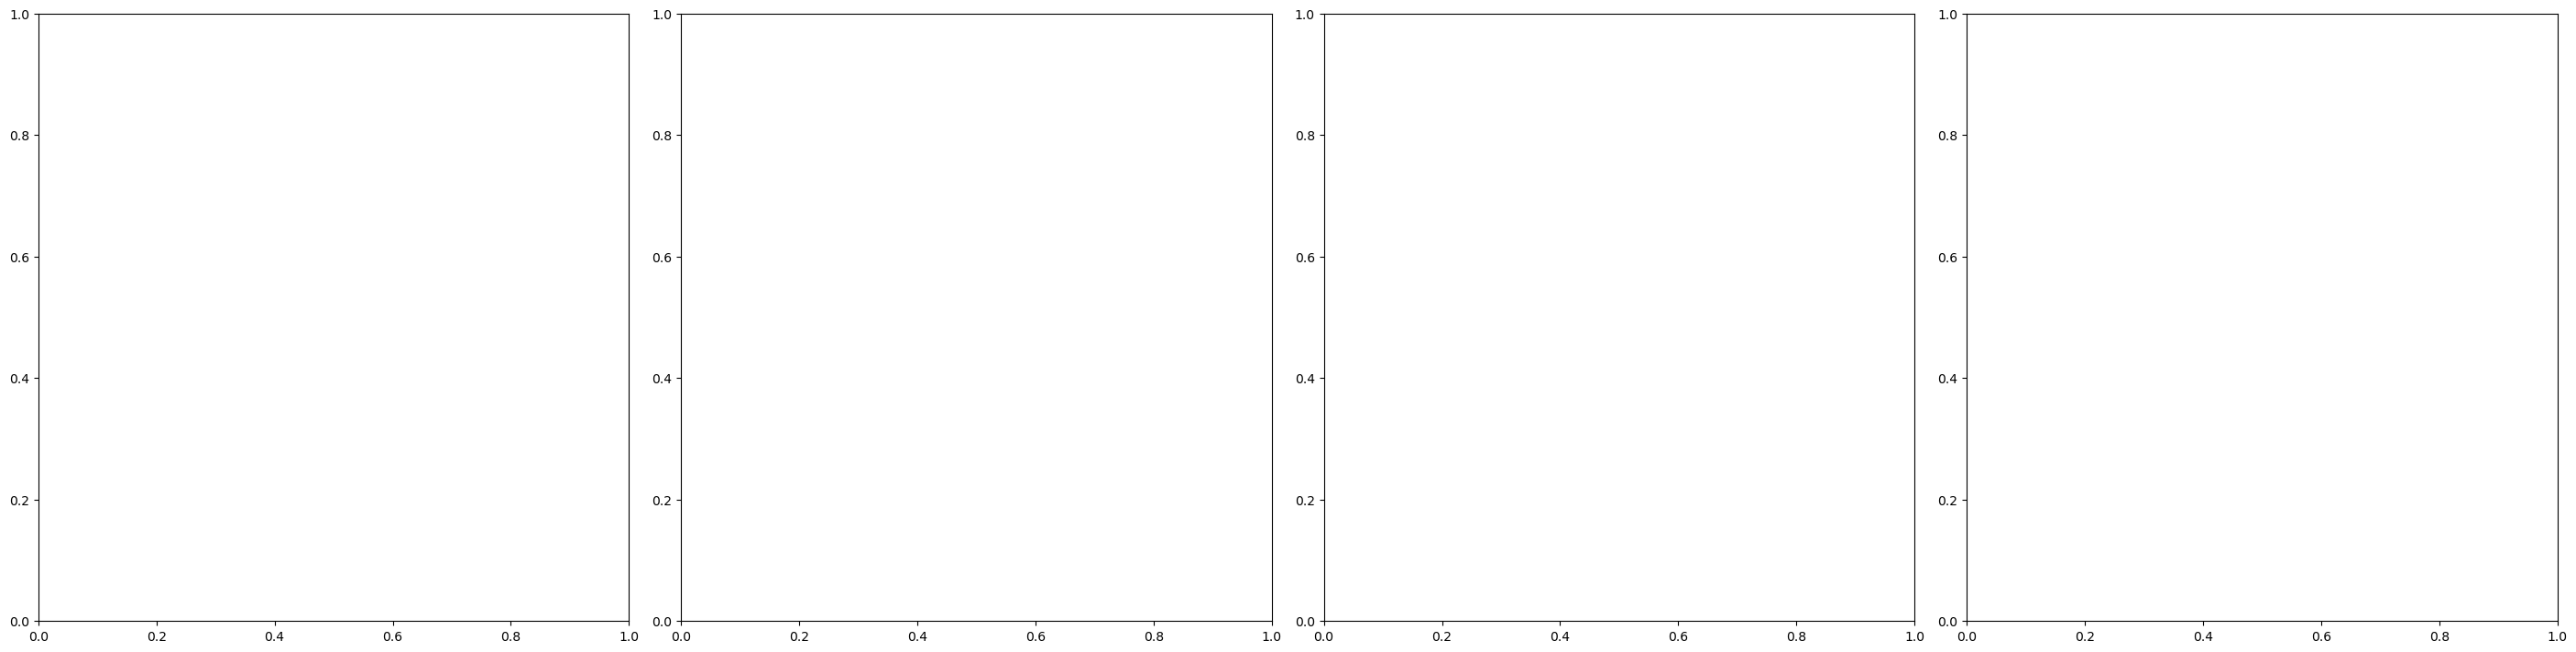

In [4]:
# Just read stuff back in...
            
def plotobj(data, label, time = 8, ax = None, colors='k', alpha=1.0, cref_thresh = 40., marker="s", w_thresh=3.5):
    
    DBZ  = data[label]['dbz'][time]
    W    = data[label]['w'][time]
    PRES = data[label]['pres'][time]
    THpert  = data[label]['pert_th'][time]
        
    mask_cref   = np.where(DBZ.max(axis=0) > cref_thresh, True, False)
    mask_w_3d   = np.where(PRES < 70000.0, W, np.nan)

    mask_w_2d   = np.nanmax(mask_w_3d, axis=0)
    mask_w_cref = (mask_w_2d > w_thresh) & mask_cref
    f_mask      = mask_w_cref.astype(np.int8)
    
    ctable = radar_colormap()
    levels = [5 + 5*n for n in range(15)]
    
    x = np.arange(DBZ.shape[1])
    y = np.arange(DBZ.shape[2])
    xx, yy = np.meshgrid(x,y)
    
    #ax.contour(DBZ.max(axis=0), levels=[35,], color='k')
    ax.scatter(xx[f_mask>0], yy[f_mask>0], s=10, c=colors, marker=marker, alpha=alpha, linewidths=0.25)
    
    #ax.contourf(np.where(THpert[0] < -1.0, THpert[0], np.nan), clevels=[-1,-2], color='b', alpha=0.5)
    ax.contourf(np.where(THpert[0] < -1.0, THpert[0], np.nan), clevels=[-1,], cmap=plt.get_cmap('bone'), alpha=0.3)

    ax.set_ylim(0., 256.)
    ax.set_xlim(0., 256.)
    
    return np.sum(f_mask > 0), 100*np.where(THpert[0] < -1.0, 1.0, 0.0).sum()/(THpert[0].shape[0]*THpert[0].shape[1])

#-----------------------------
allcape = ("C2000","C3500")
allshear = ("06","18")

for shear in allshear:
    for cape in allcape:
        
        for n in [1,2, 3, 4, 5, 6]:
            
            fig, ax = plt.subplots(1,4, constrained_layout=True,figsize=(28,7))

            label = "%s_%s" % (cape, shear)

            o4, pix = plotobj(models['cm1'], label, ax = ax[0], time=1+n*4-1, colors='b', marker="s")

            ax[0].set_title("CM1: Object Count: %3.3d  Cold Pool Size:  %3.1f%%" % (o4, pix), fontsize=16)

            o4, pix = plotobj(models['wrf'], label, ax = ax[2], time=1+n*4-1, colors='k', marker="s")

            ax[1].set_title("WRF:  Object Count: %3.3d  Cold Pool Size:  %3.1f%%" % (o4, pix), fontsize=16)

            o4, pix = plotobj(models['mpas'], label, ax = ax[1], time=1+n*4-1, colors='g', marker="s")

            ax[2].set_title("MPAS: Object Count: %3.3d  Cold Pool Size:  %3.1f%%" % (o4, pix), fontsize=16)
            
            o4, pix = plotobj(models['mpas3'], label, ax = ax[3], time=1+n*4-1, colors='r', marker="s")

            ax[3].set_title("MPAS-3OT: Object Count: %3.3d  Cold Pool Size:  %3.1f%%" % (o4, pix), fontsize=16)

            plt.suptitle("Experiment: %s        Cold Pool and CREF at %d Hour" % (label, n), fontsize=20)
            
            if savePlots: plt.savefig("Experiment_%s_Marker_Hour%d.png" % (label, n))

            plt.show()

In [2]:
wrf_dir  = '/work/wicker/climate_runs/WRF_v4.4.2/ideal'
cm1_dir  = '/work/wicker/climate_runs/cm1r20.3/run/'
mpas_dir = '/work/wicker/climate_runs/MPAS/ideal/'

models = {}


In [3]:
models['wrf-4']      = pickle2Obj(os.path.join(wrf_dir, '4th/object.pkl'),retObj=False)
models['cm1-4']      = pickle2Obj(os.path.join(cm1_dir, '4th/object.pkl'),retObj=False)
# models['mpas']     = pickle2Obj(os.path.join(mpas_dir, 'base/object.pkl'),retObj=False)
# models['mpas3']    = pickle2Obj(os.path.join(mpas_dir, 'vis01_3rd/object.pkl'),retObj=False)


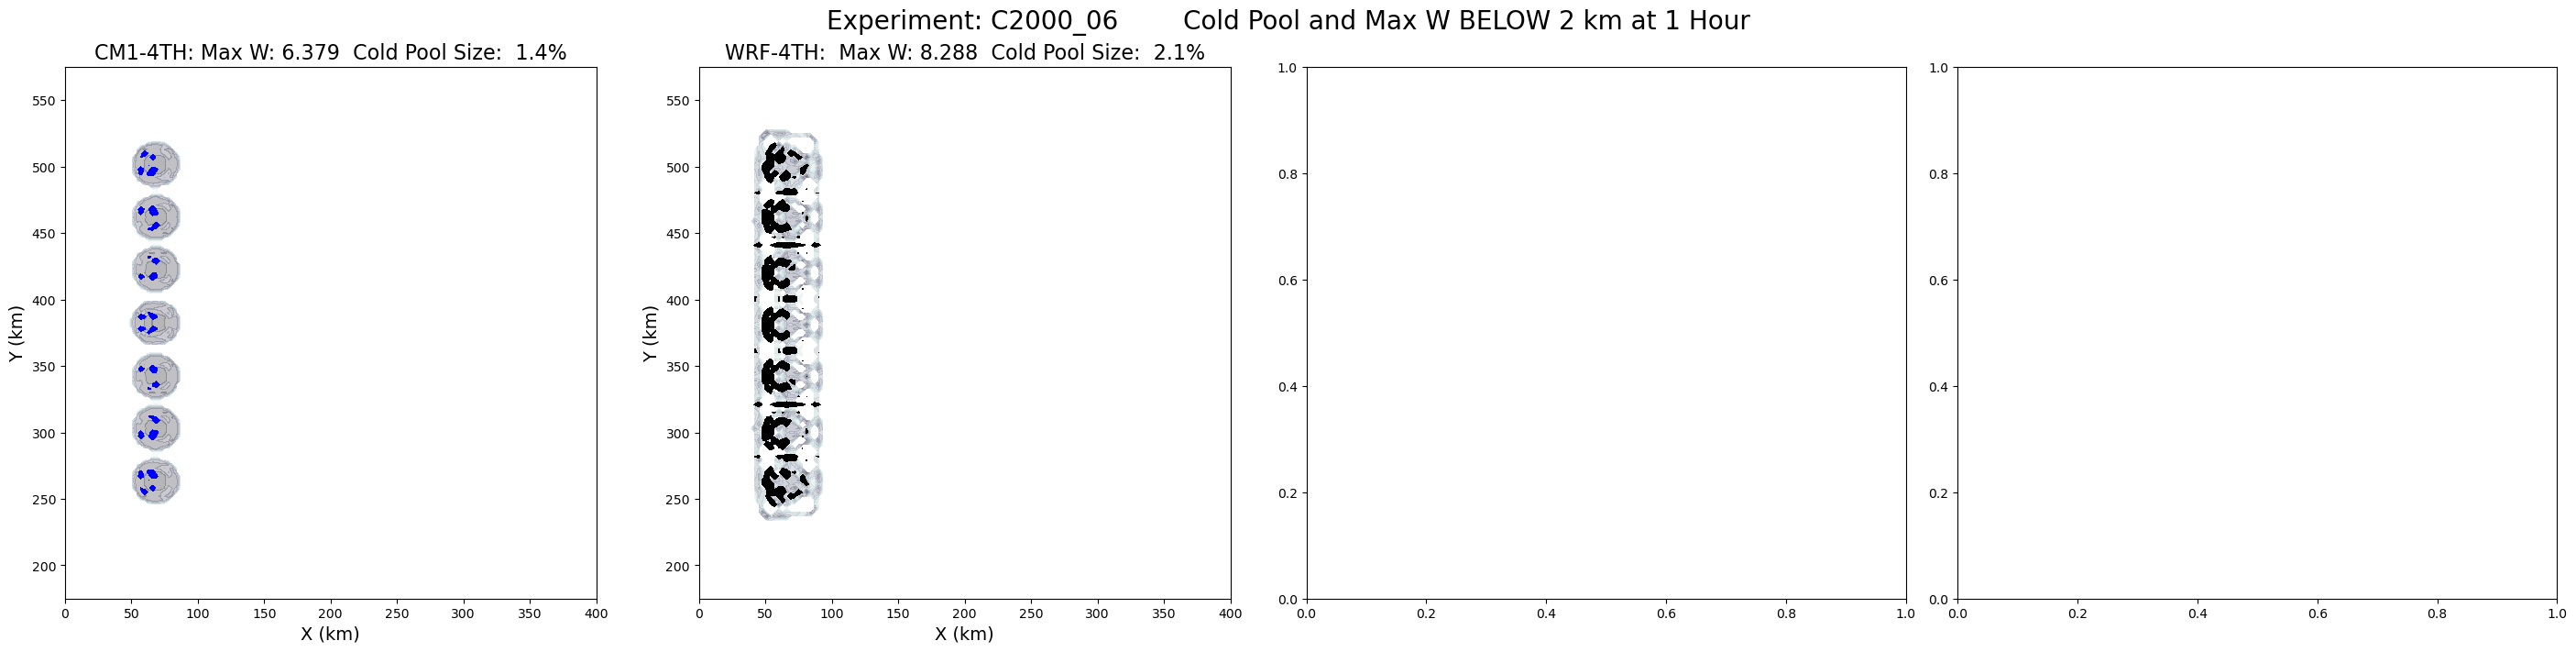

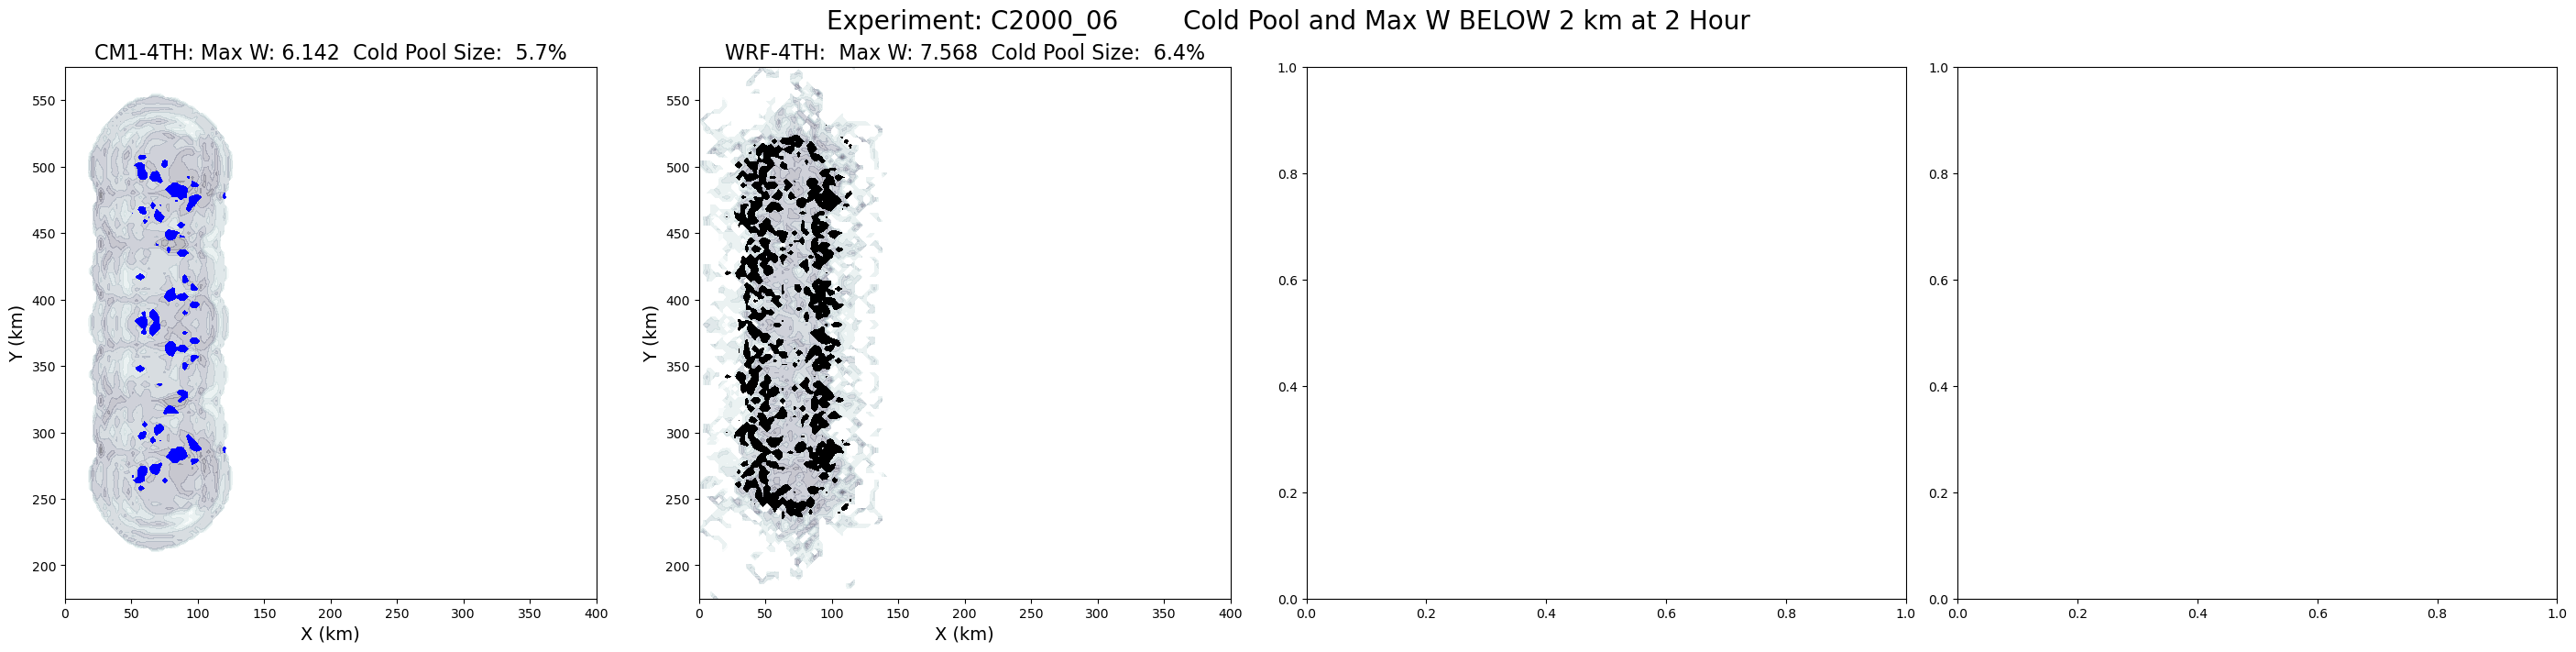

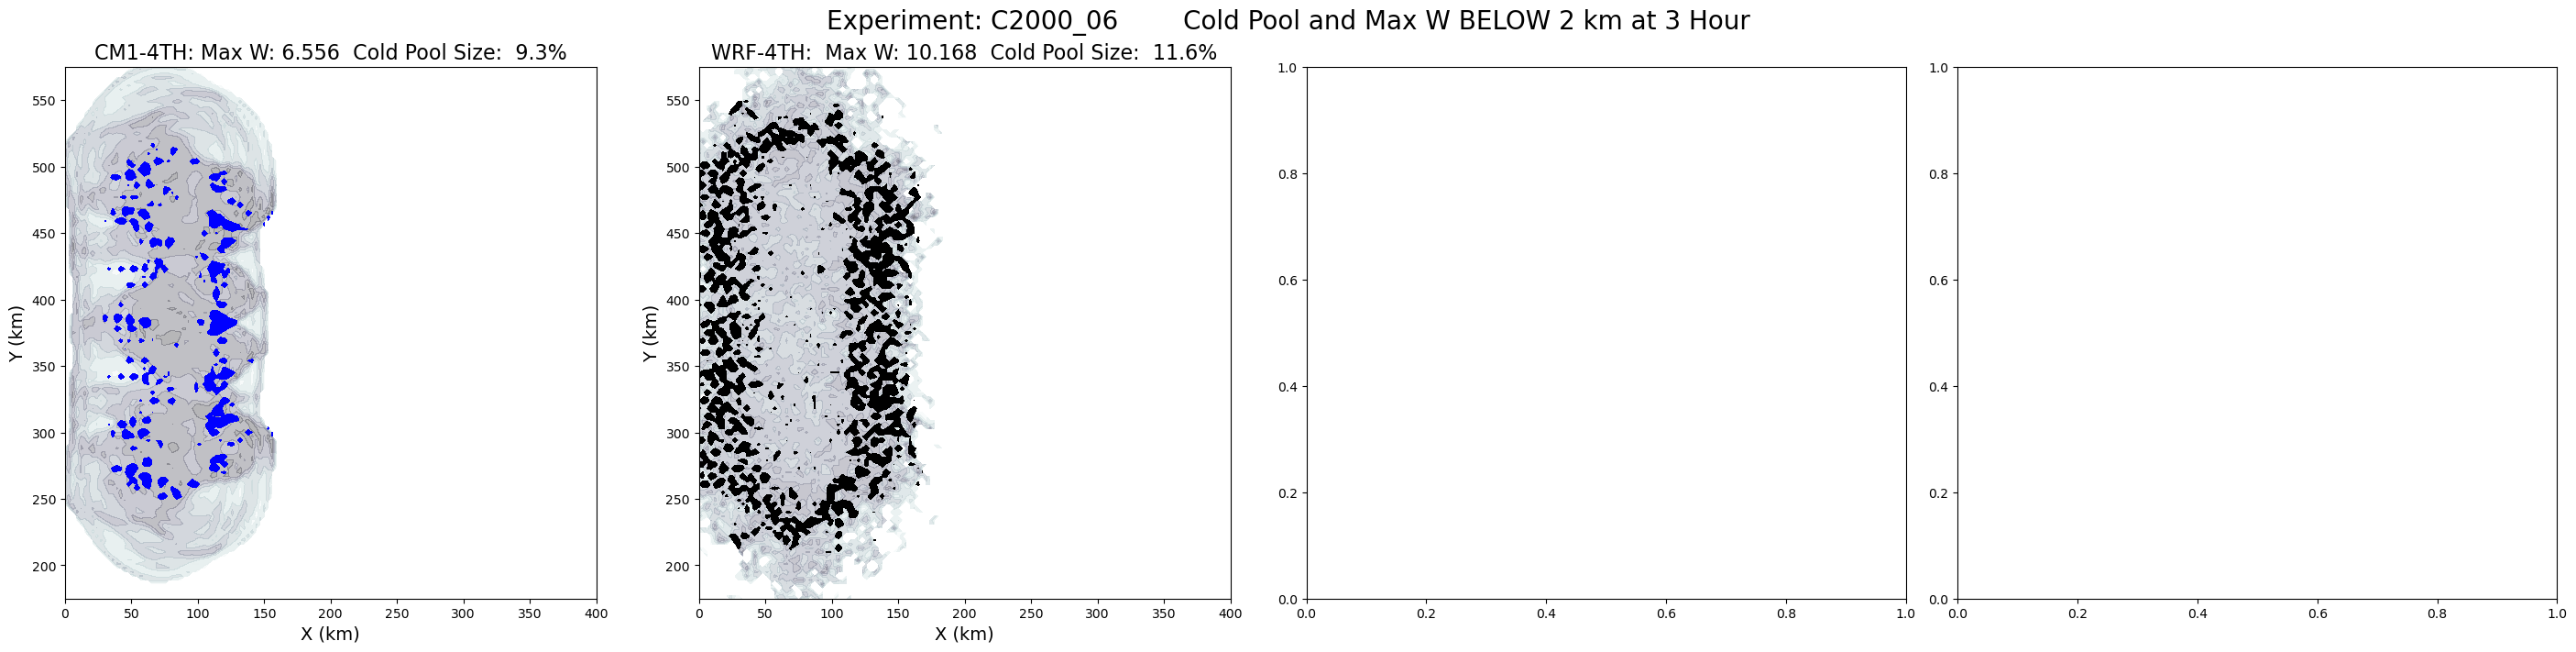

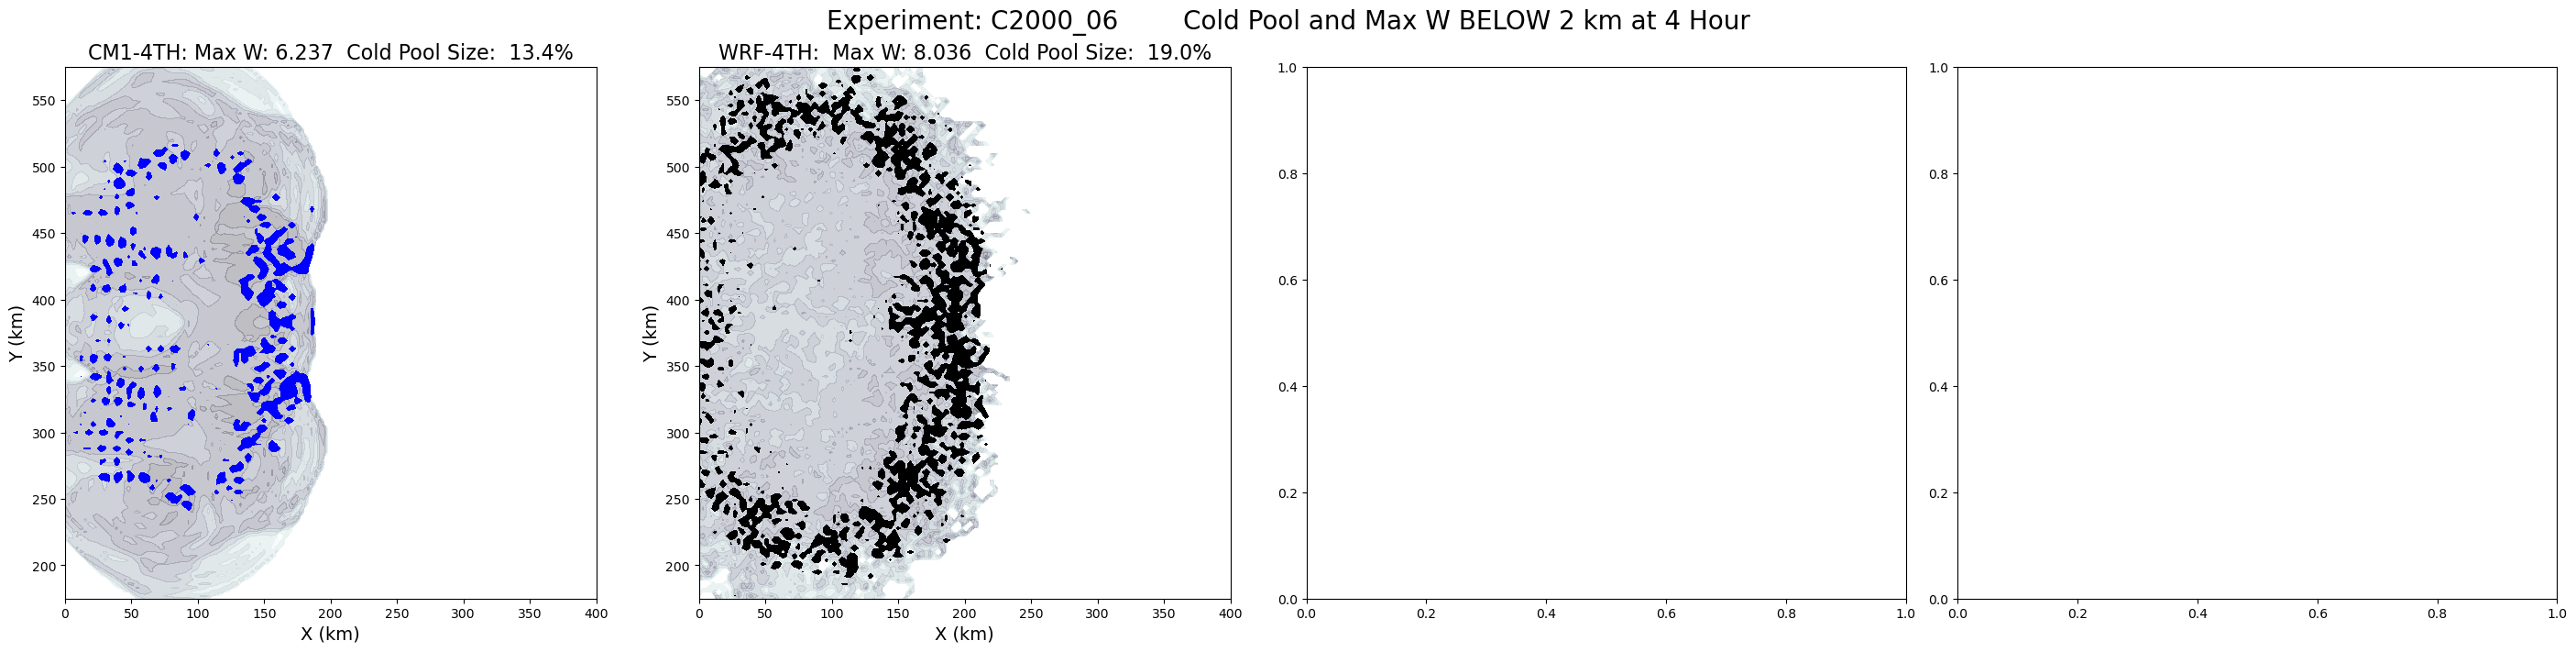

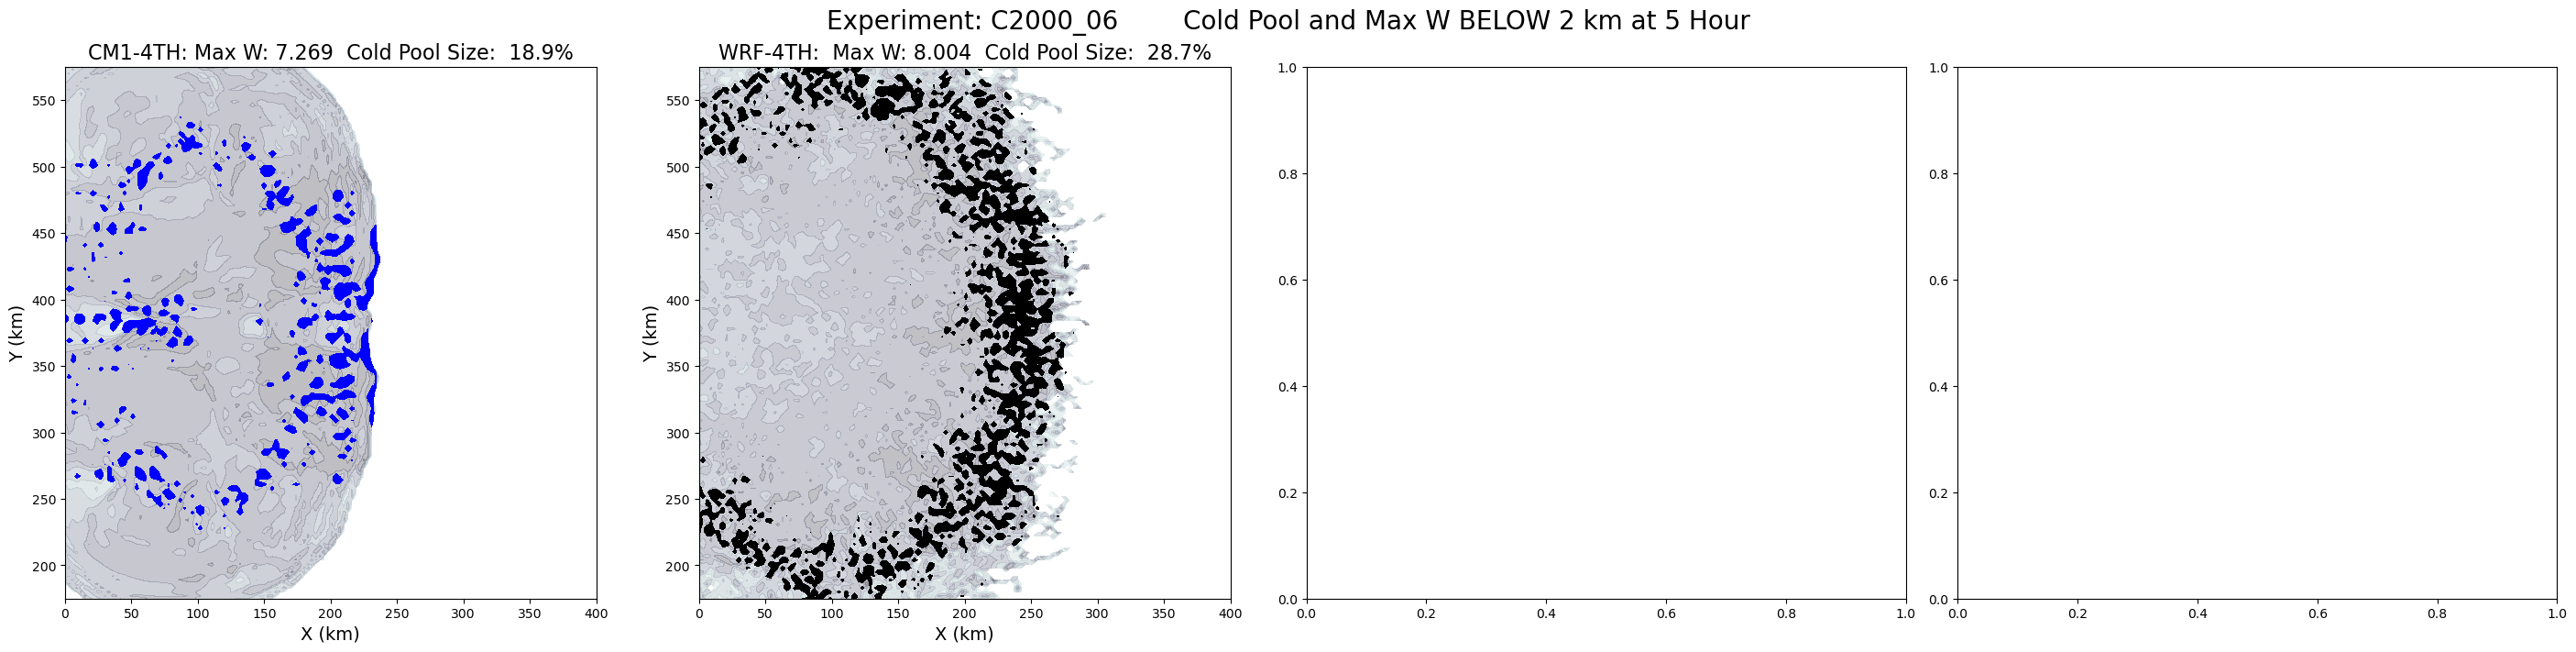

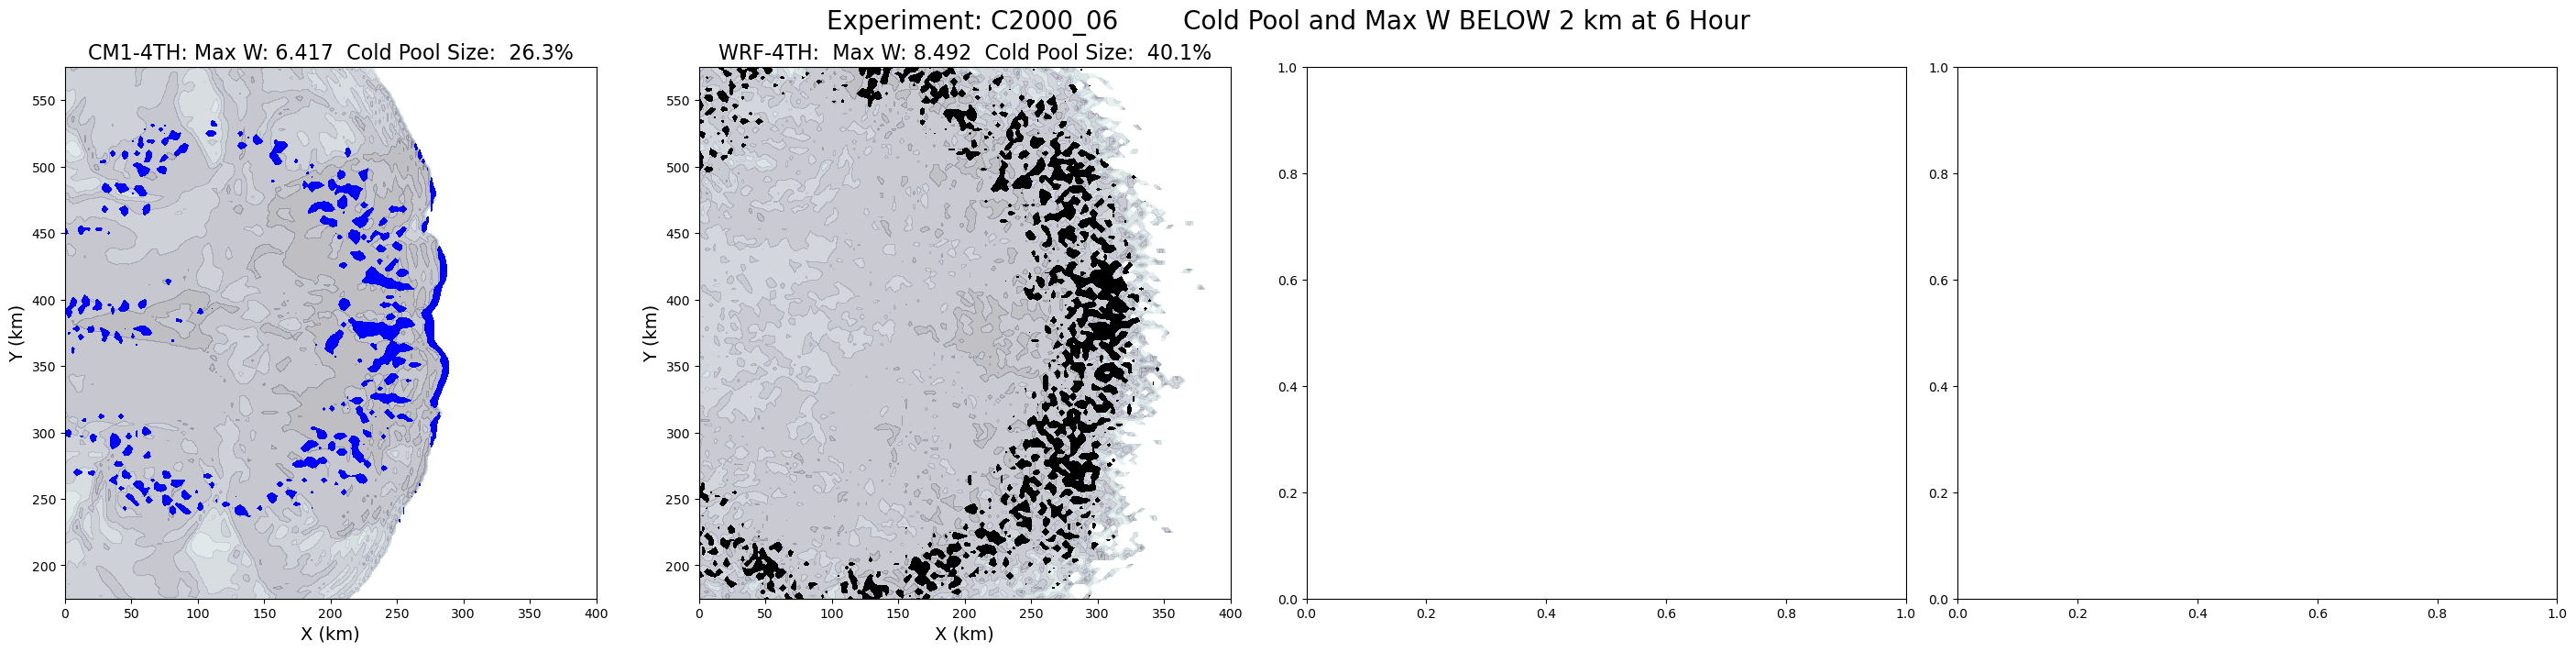

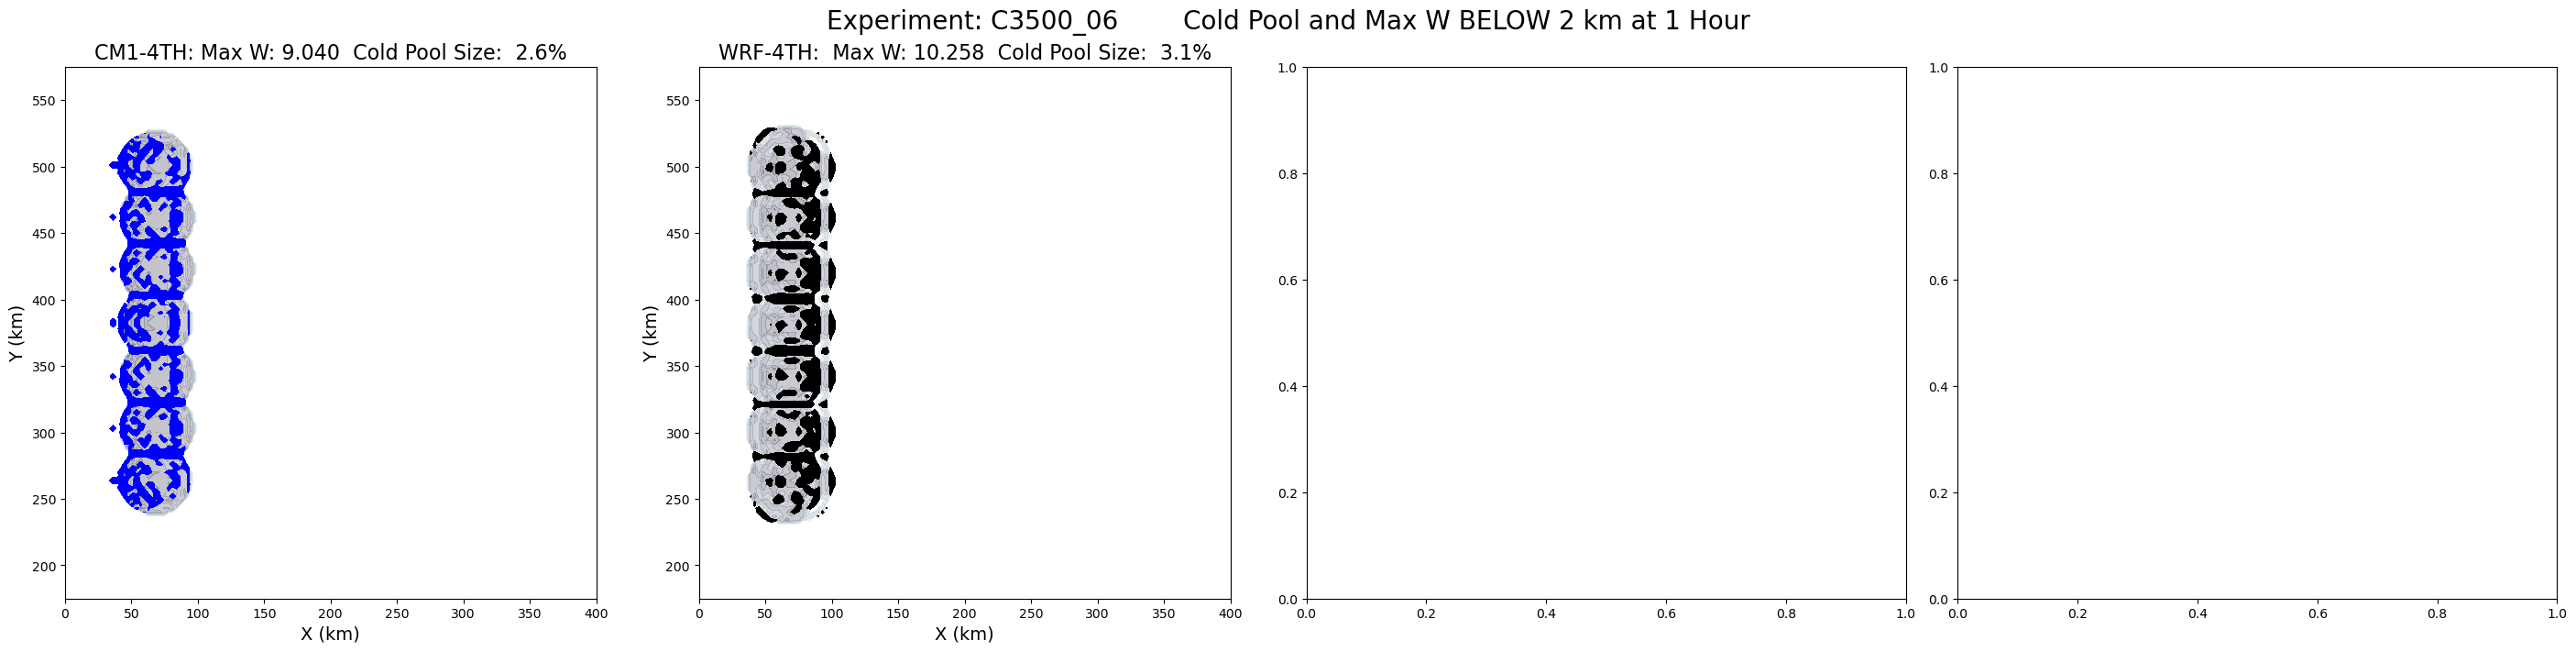

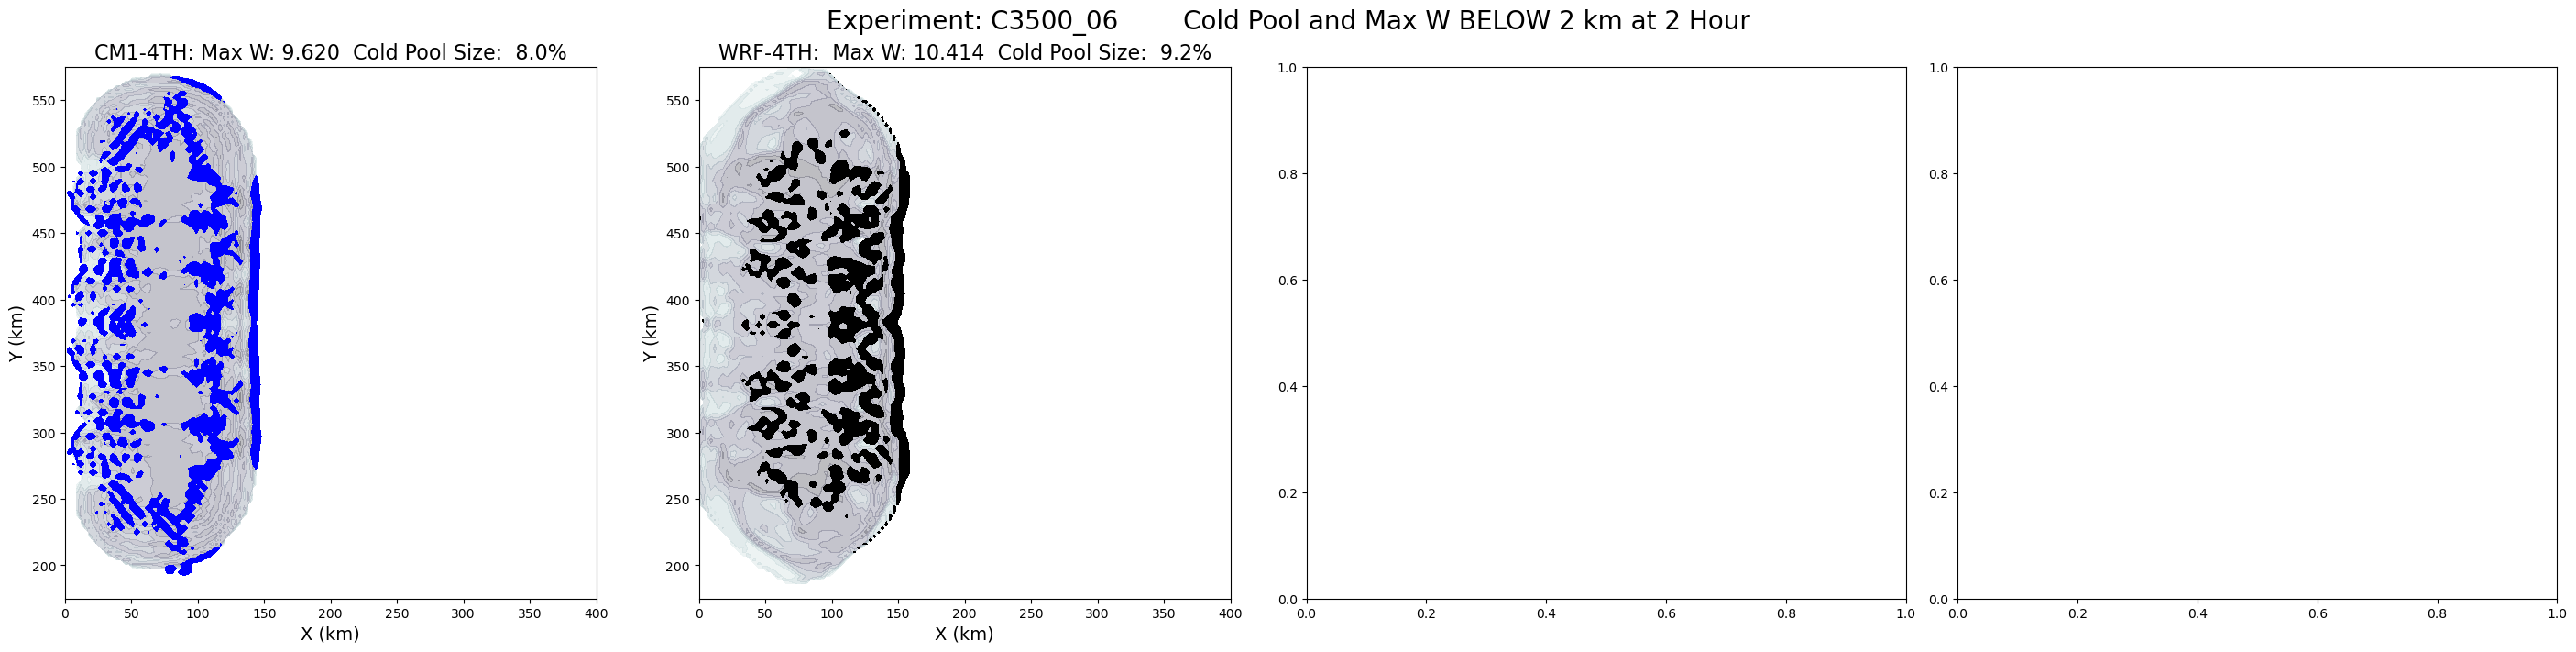

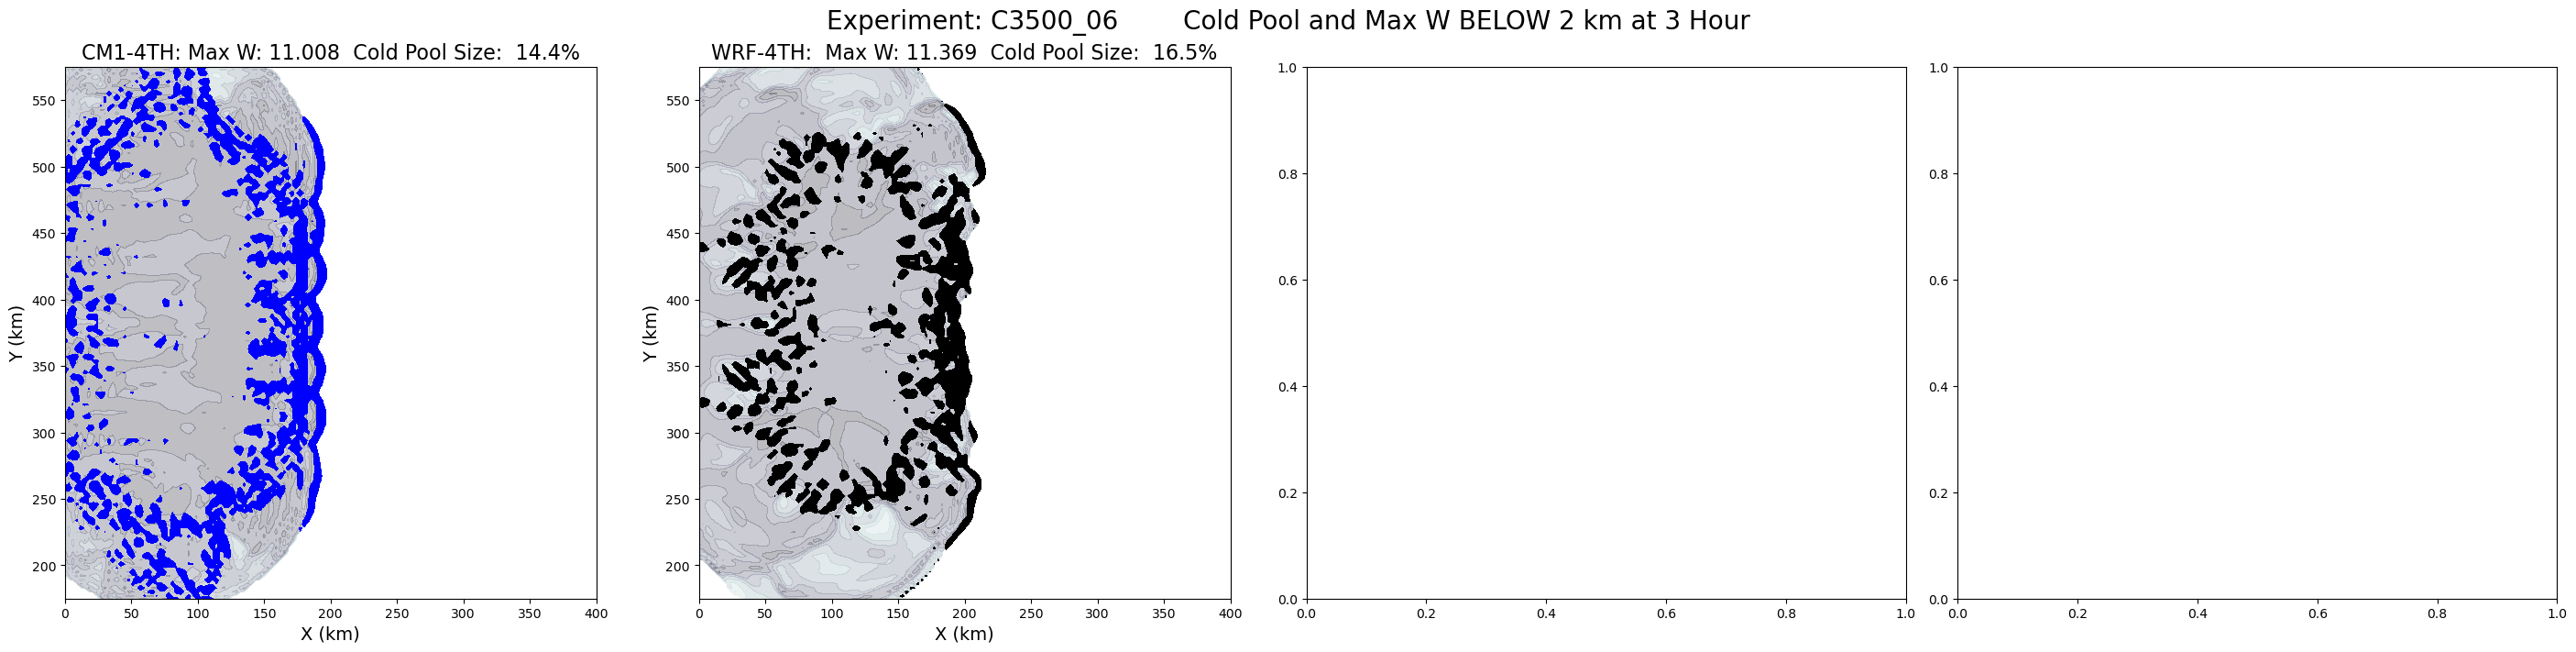

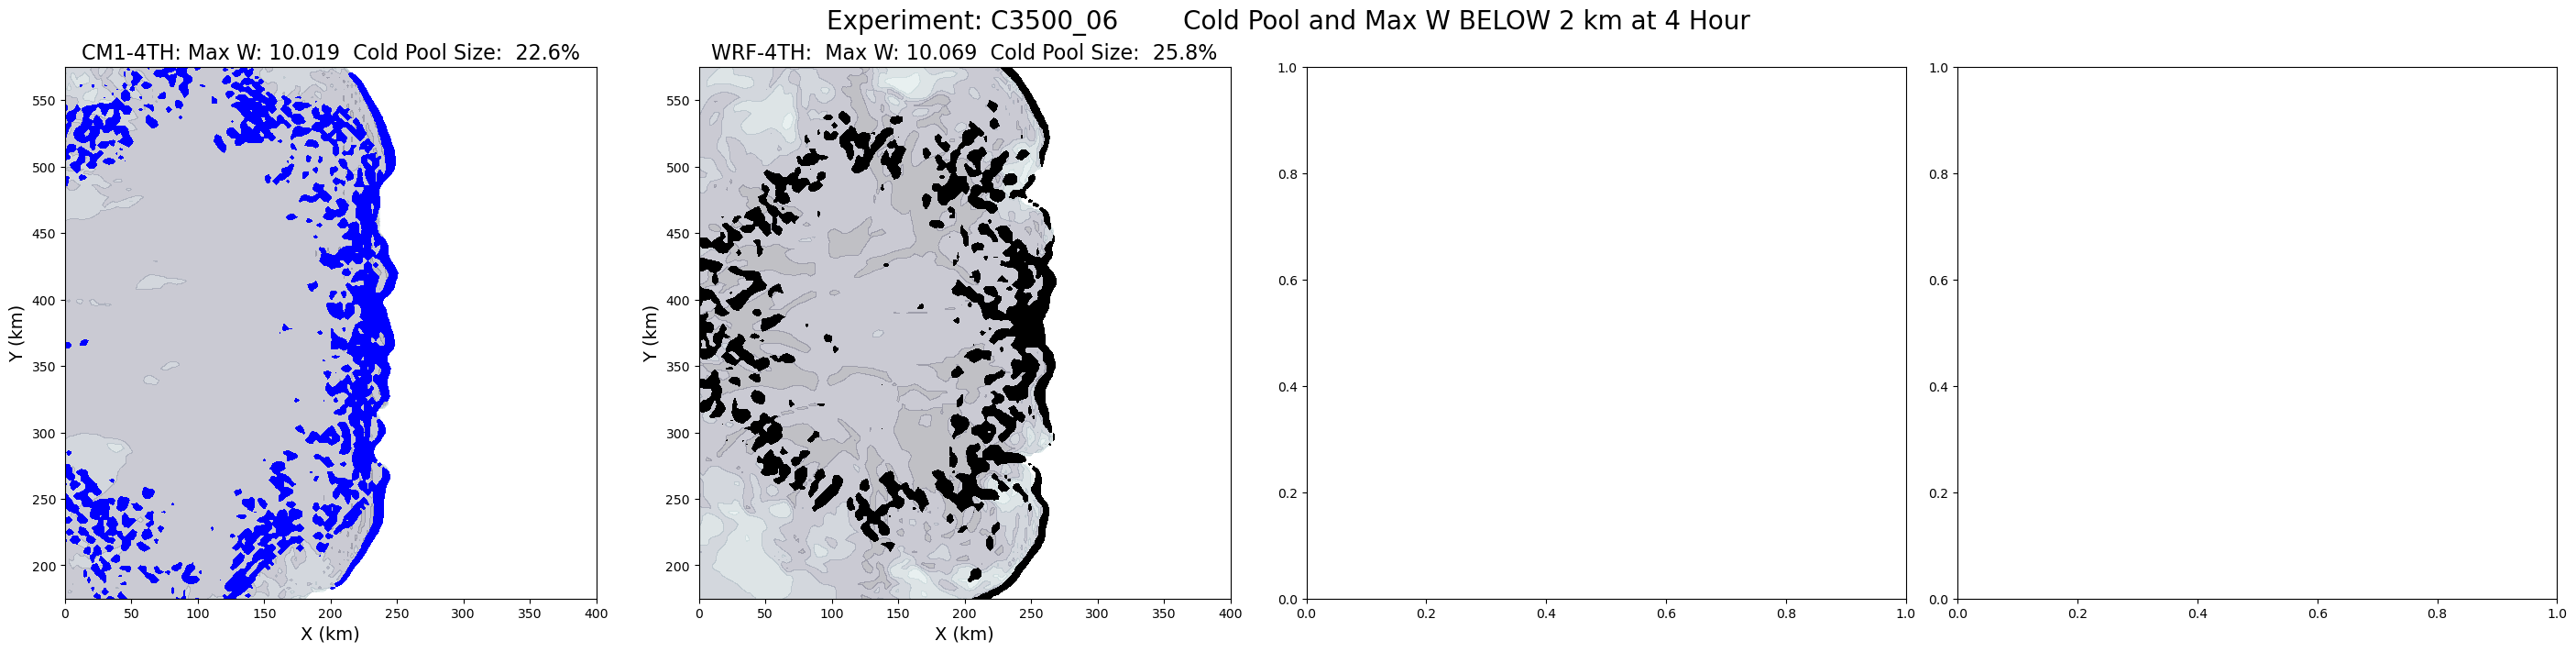

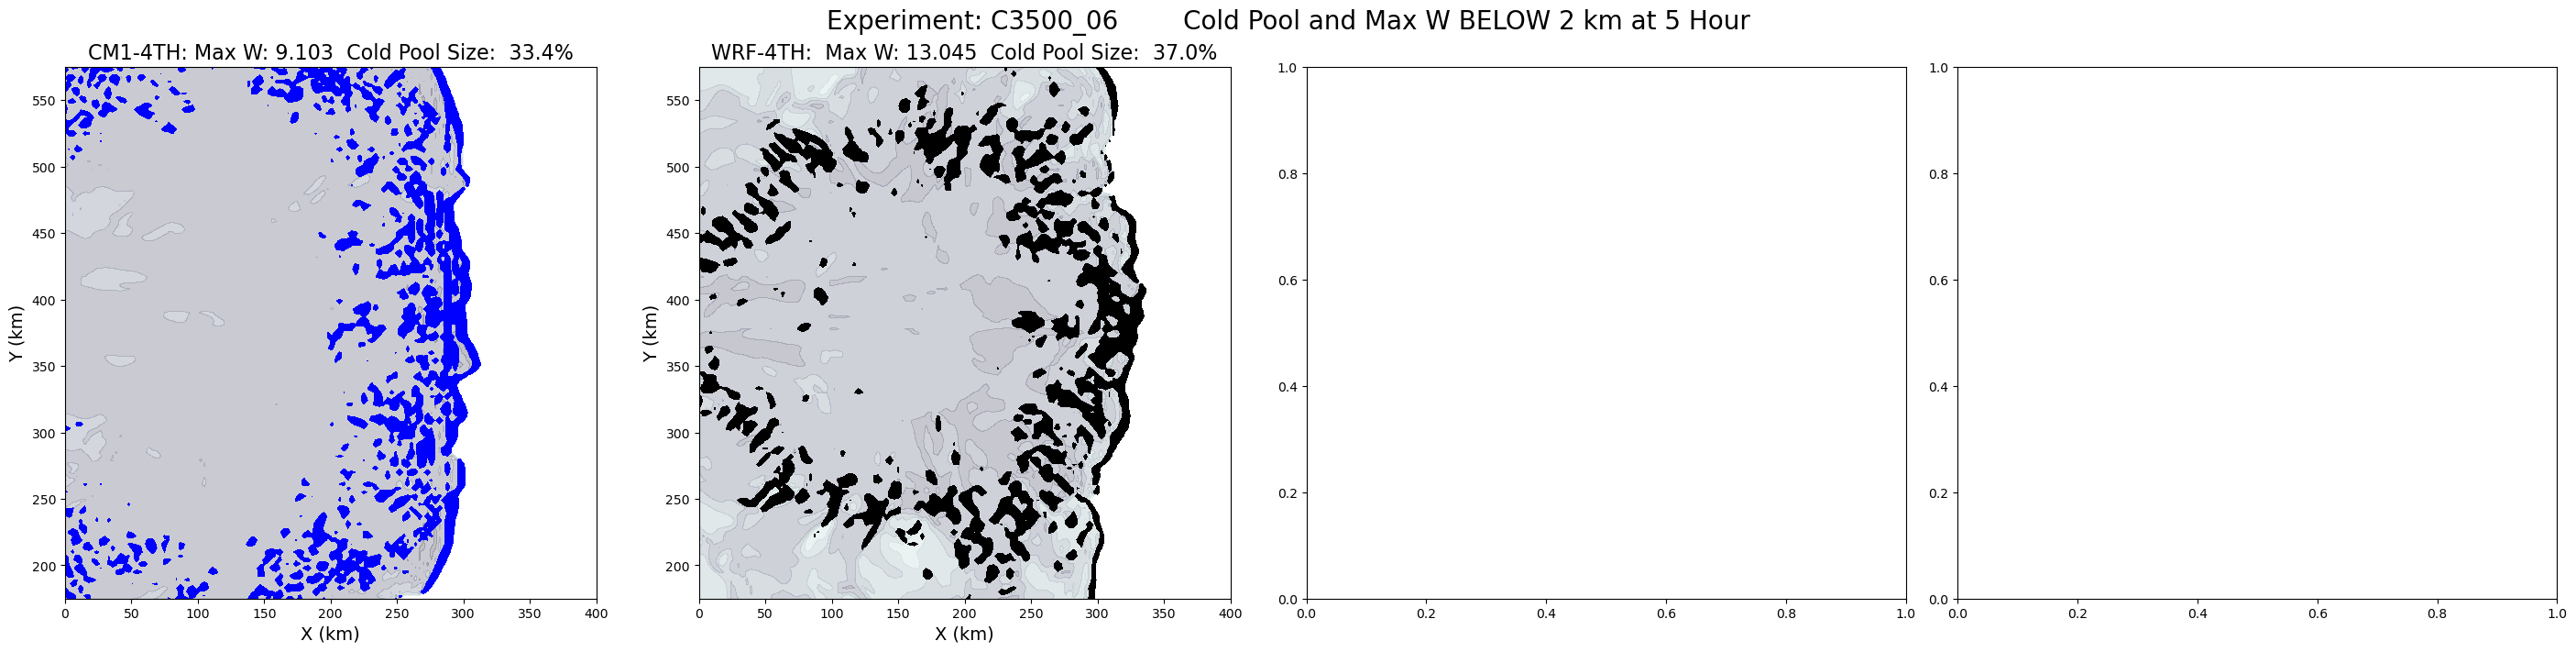

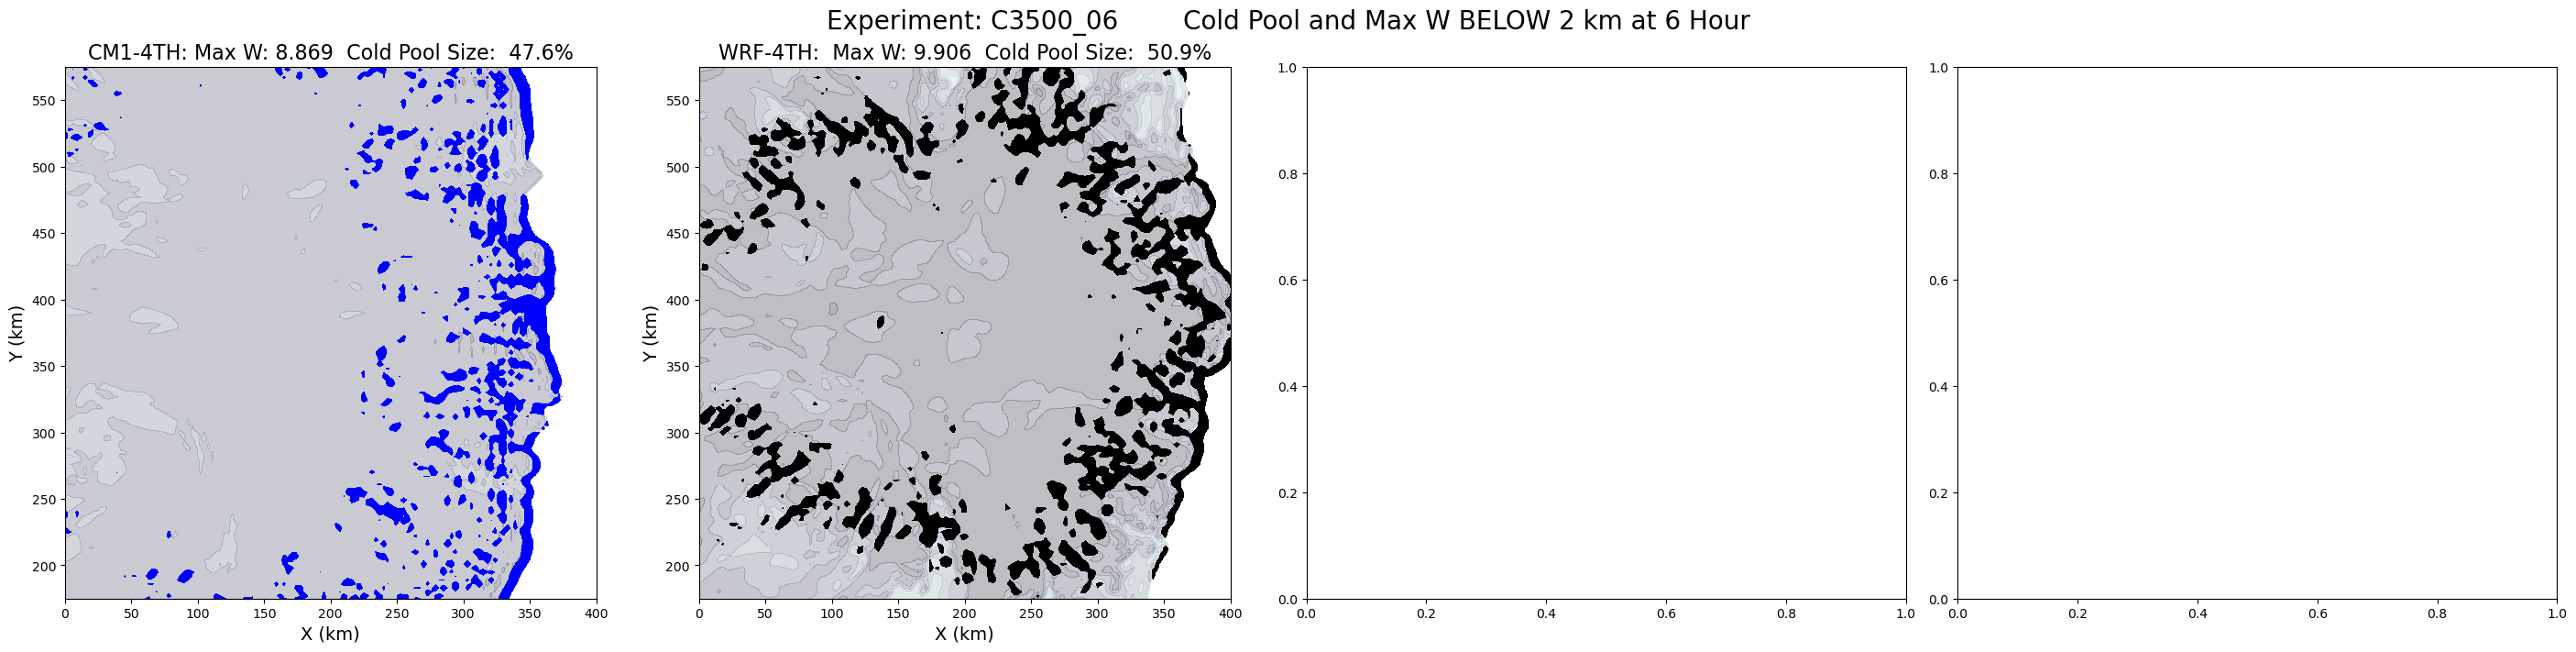

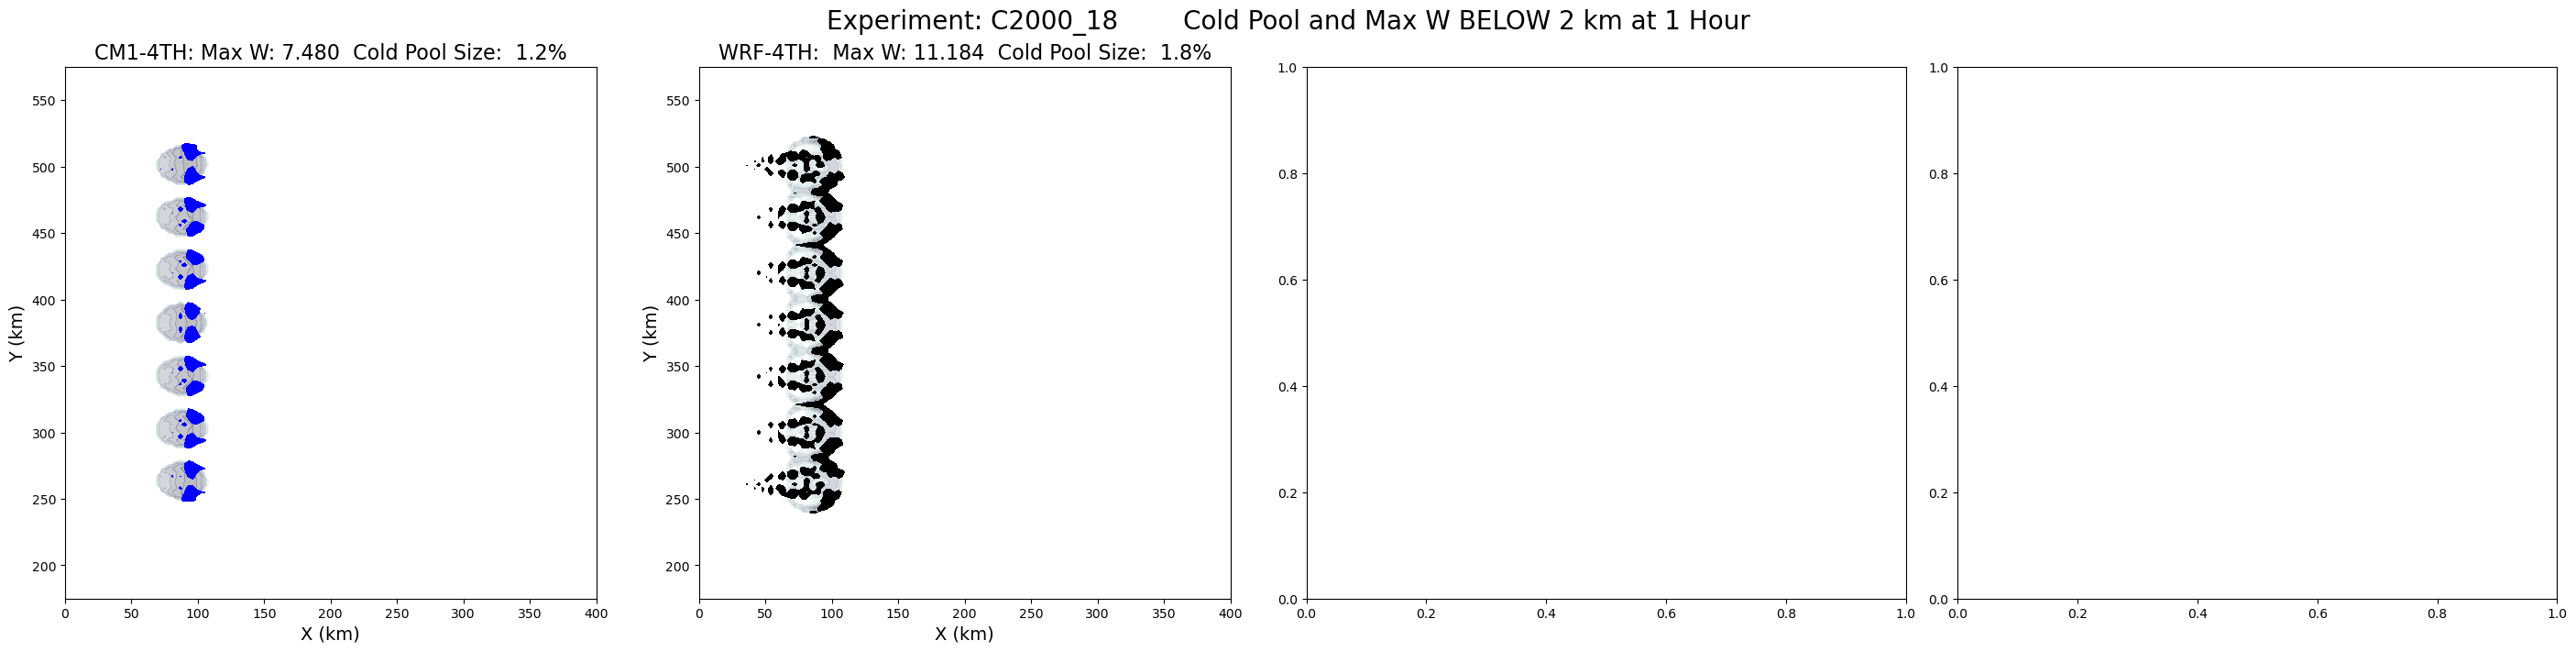

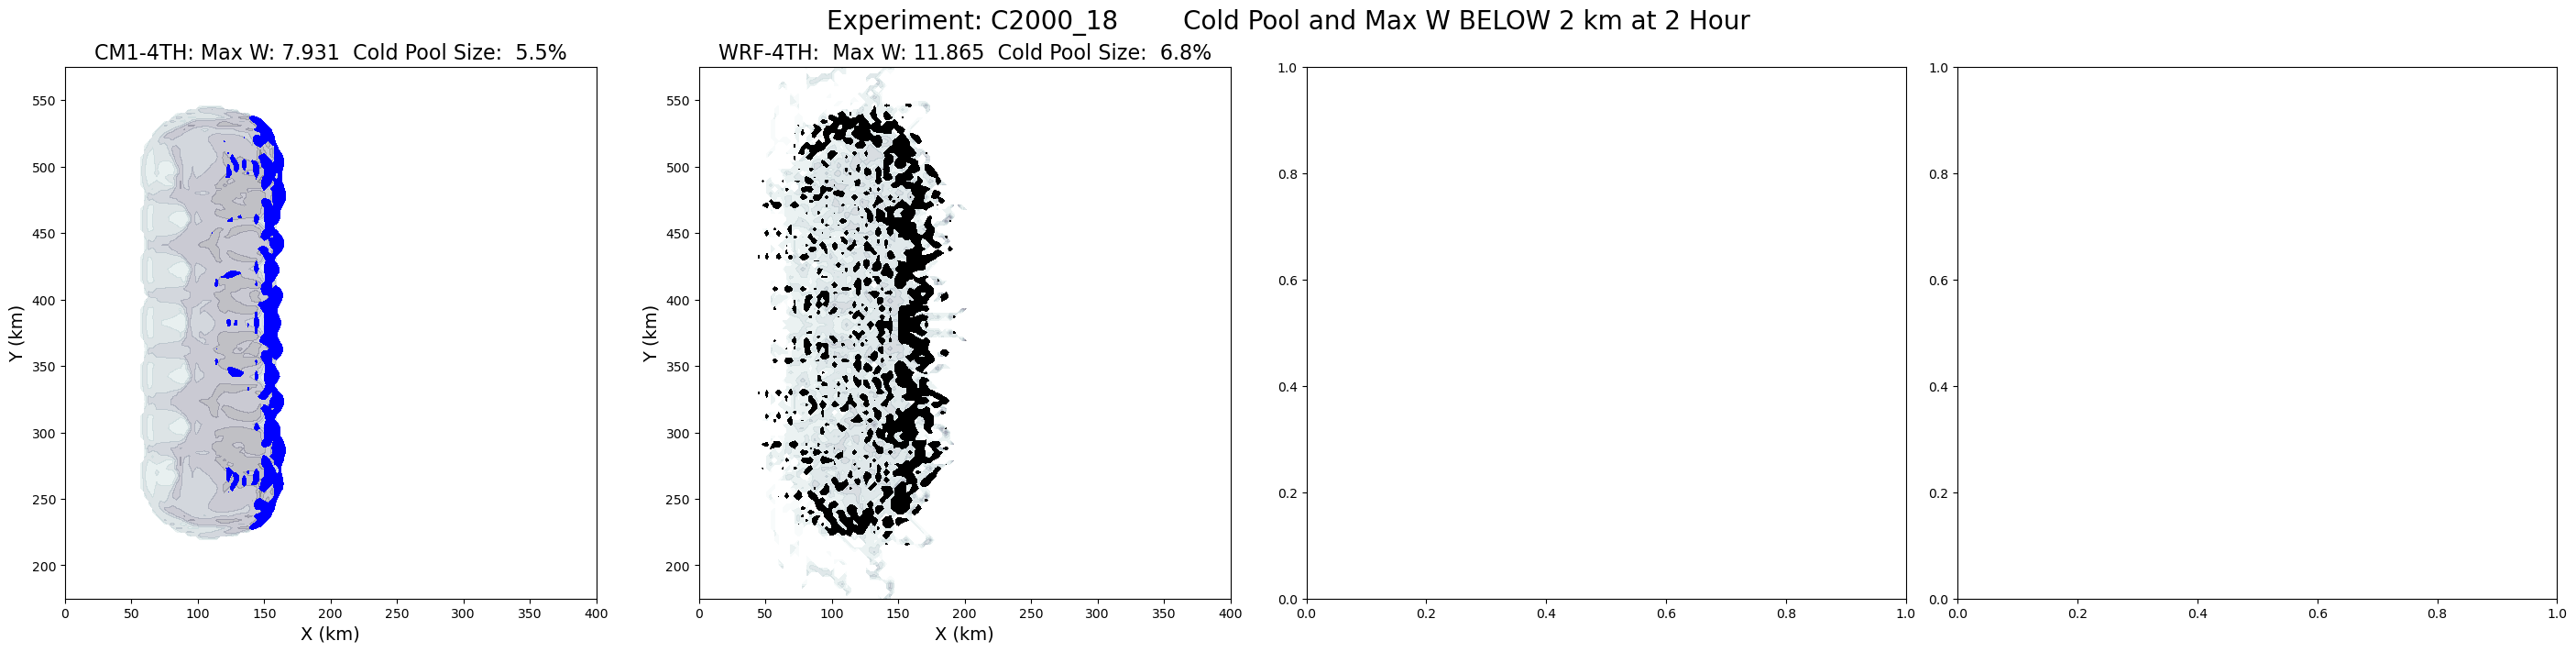

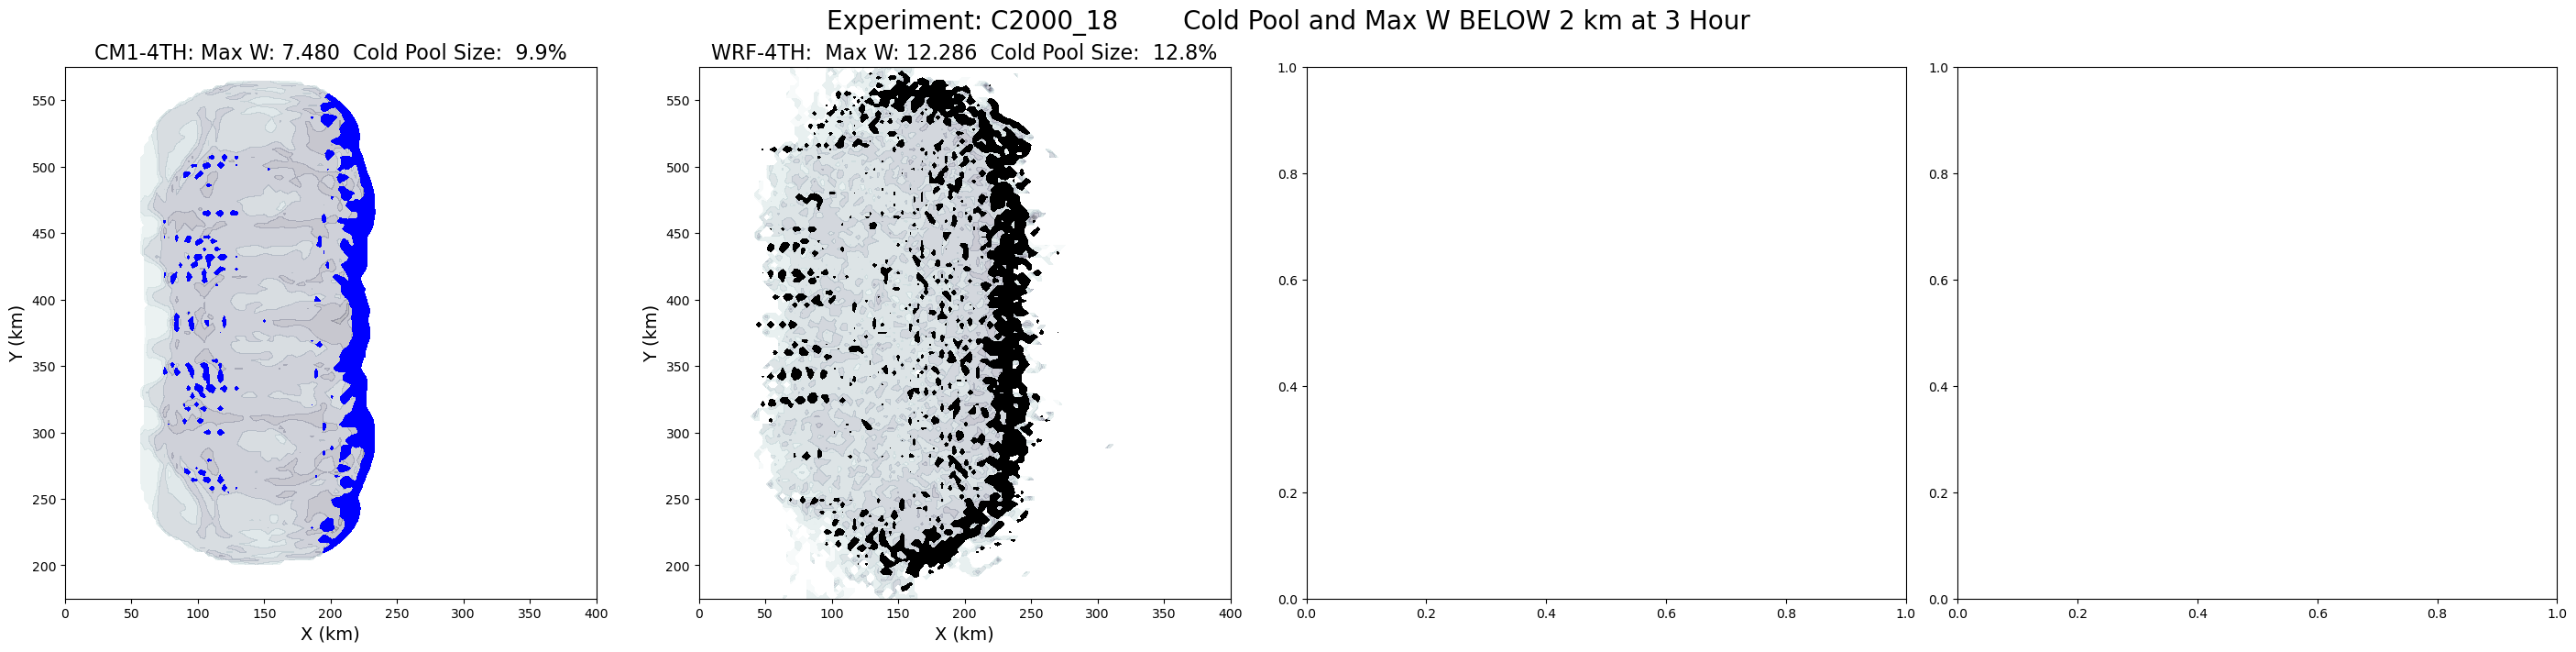

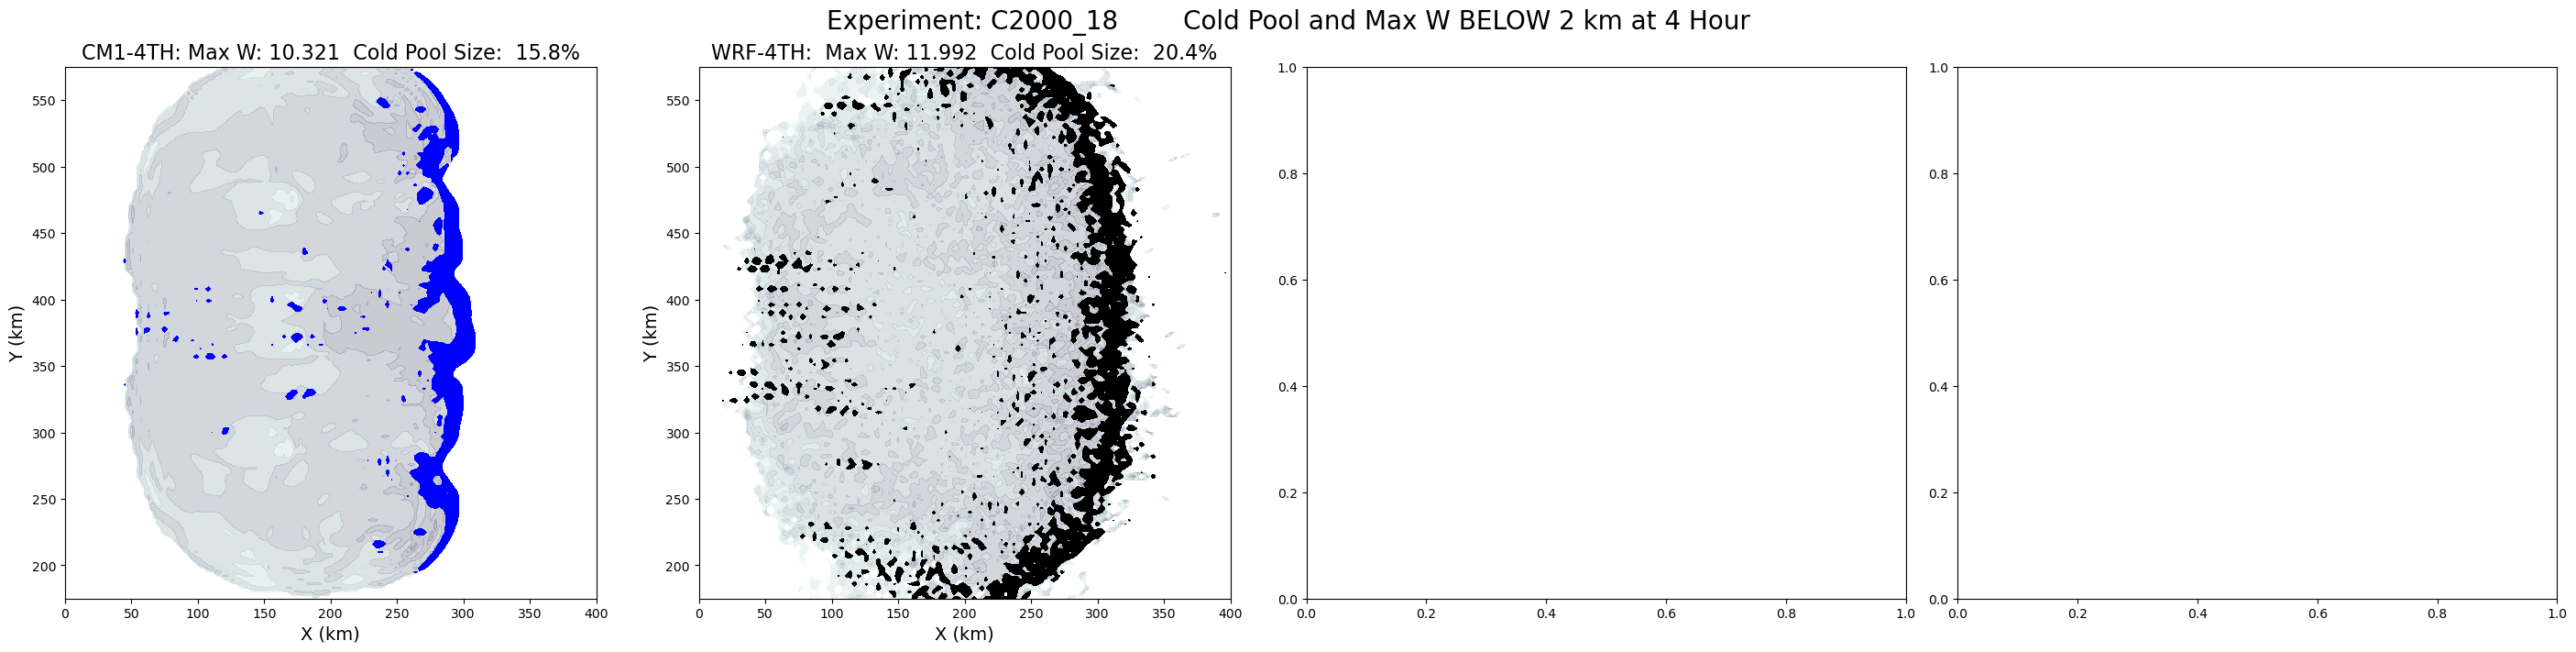

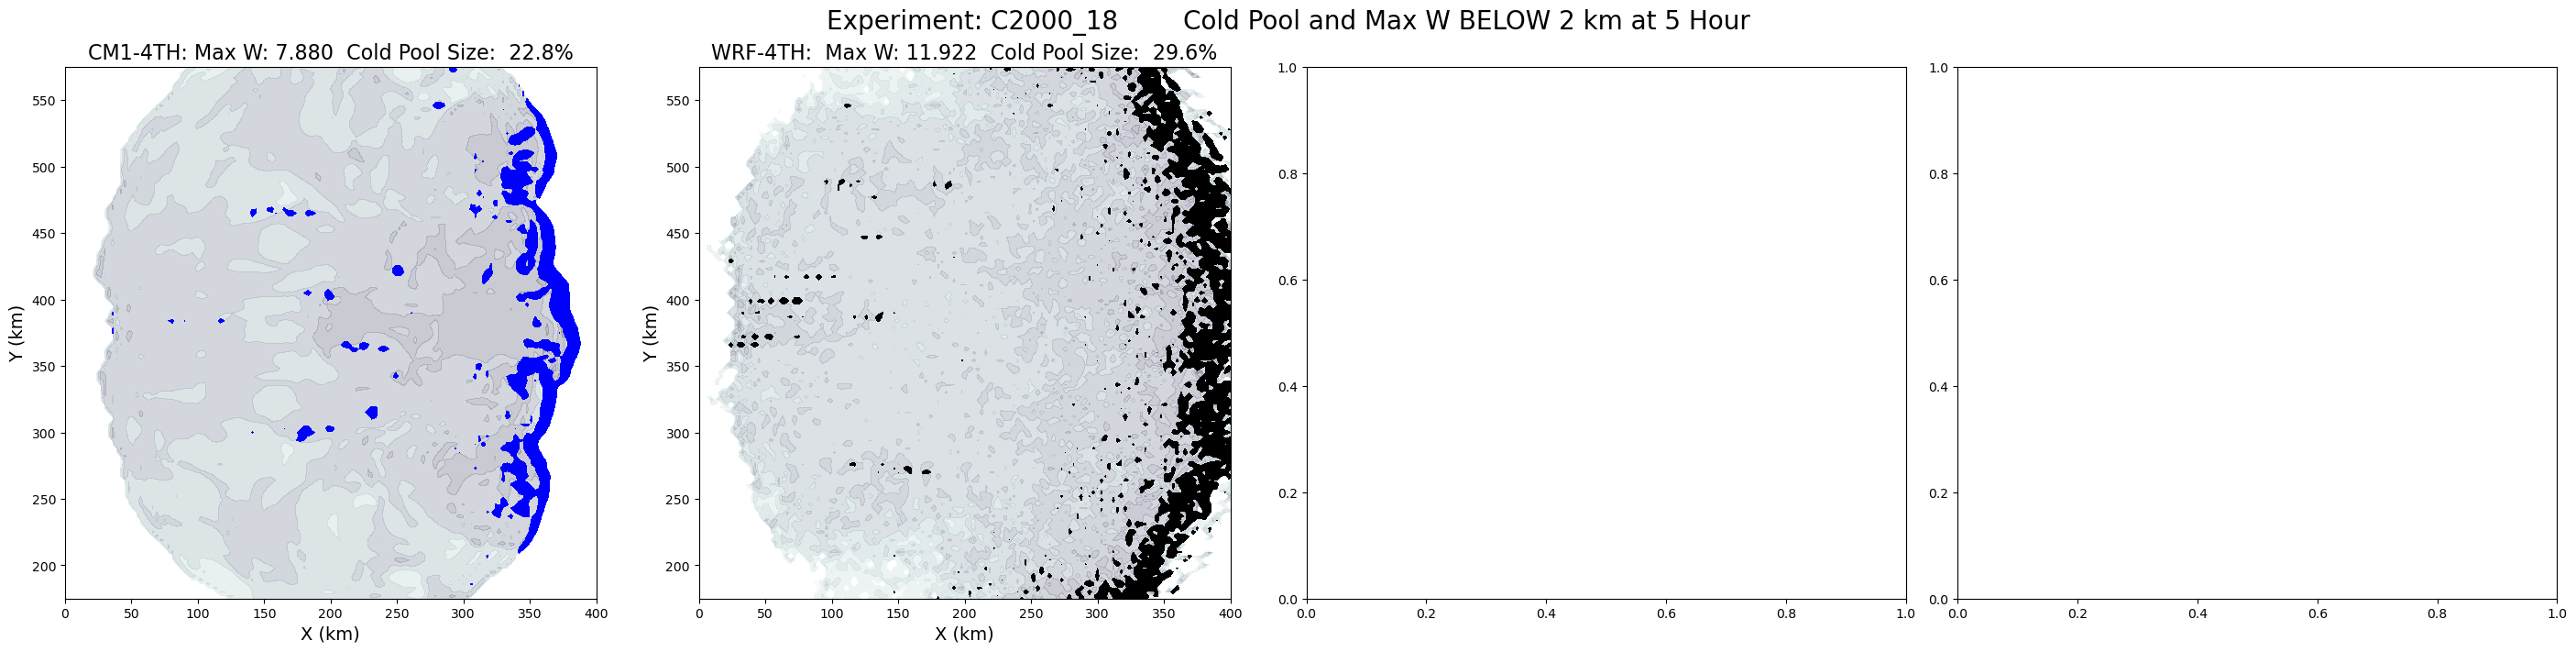

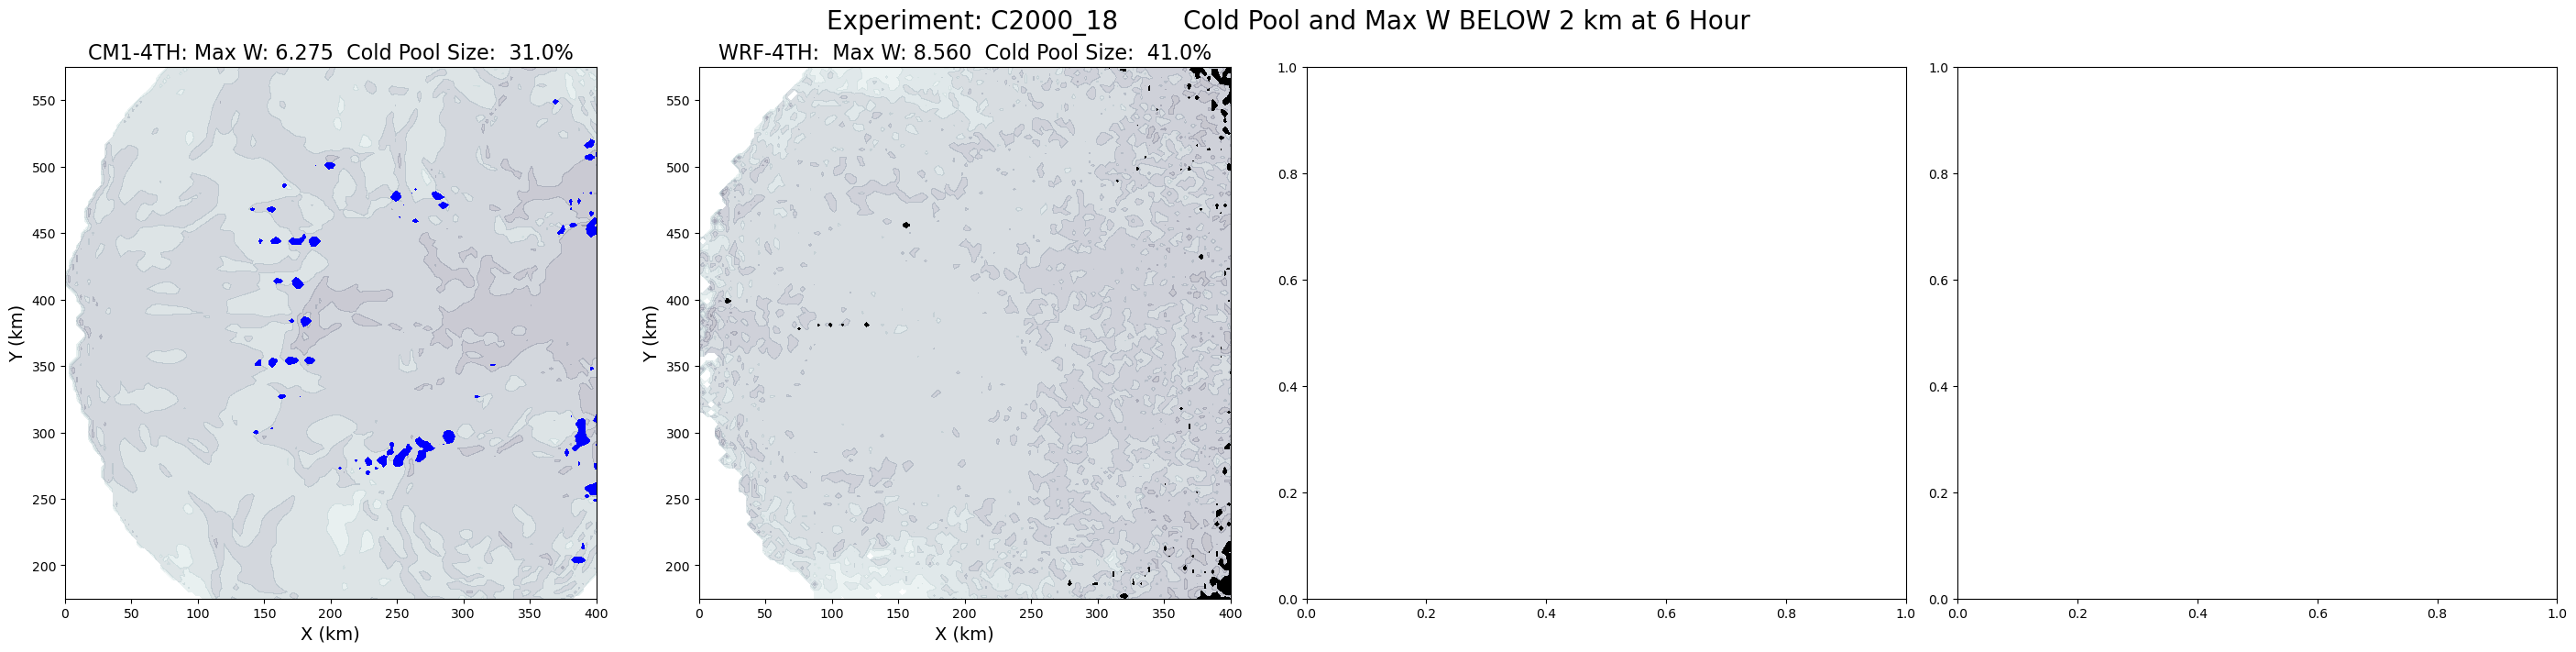

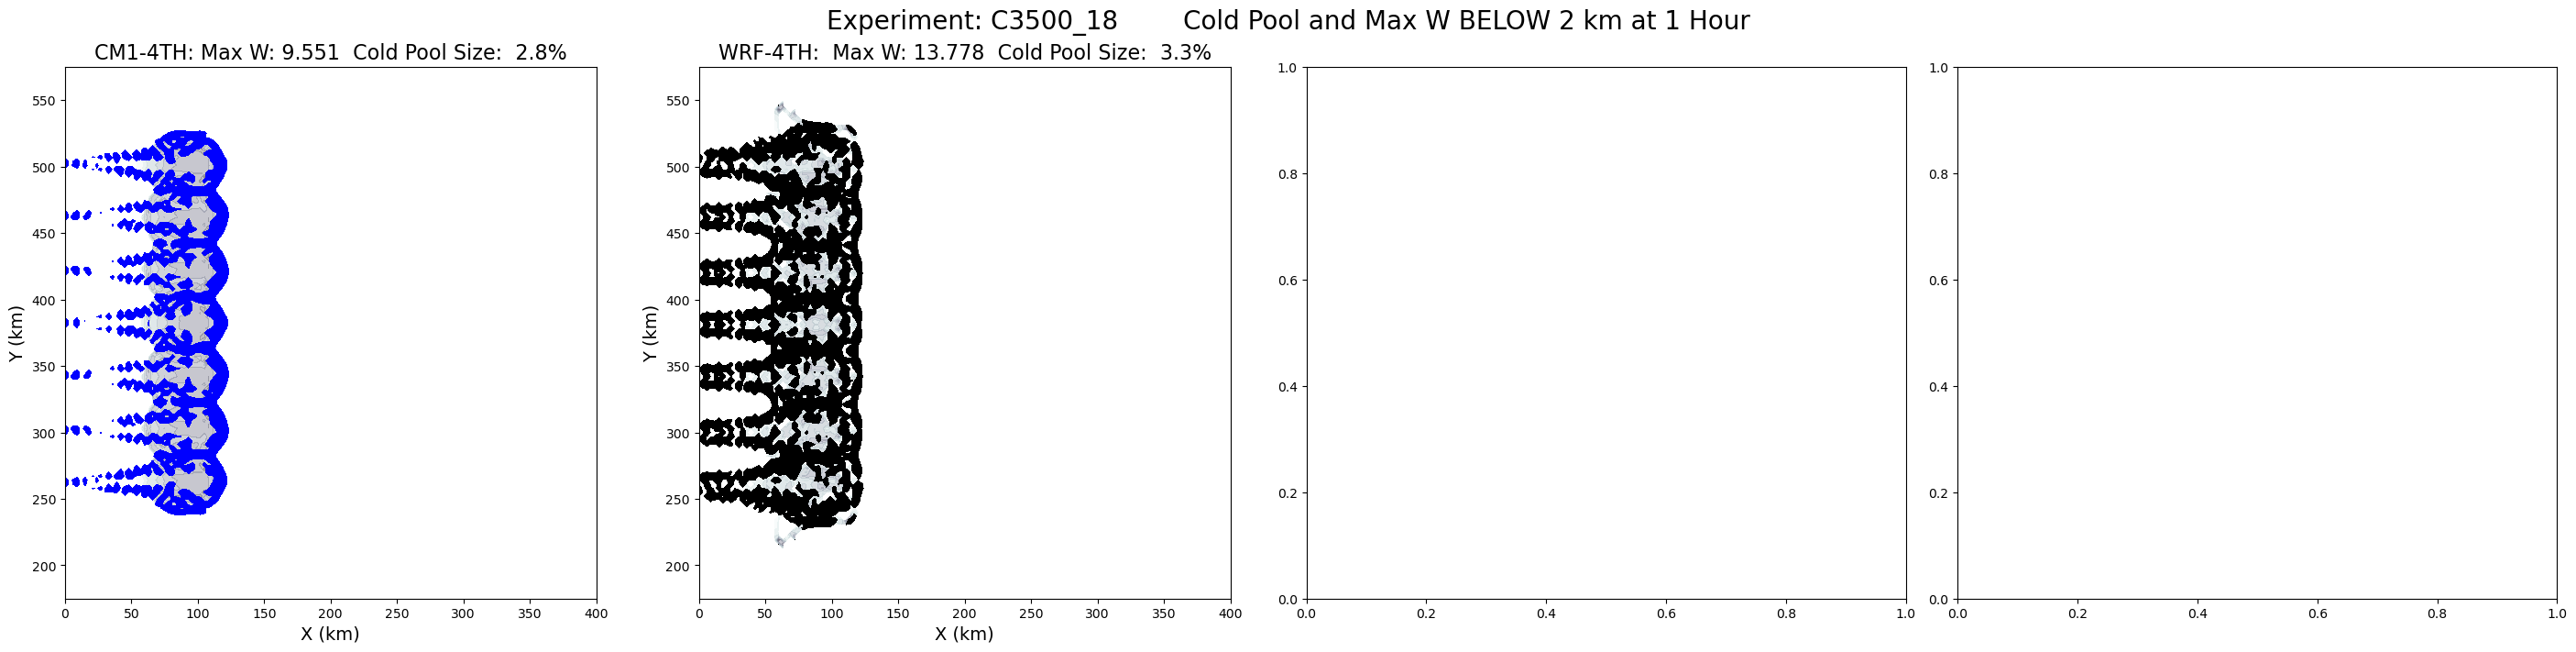

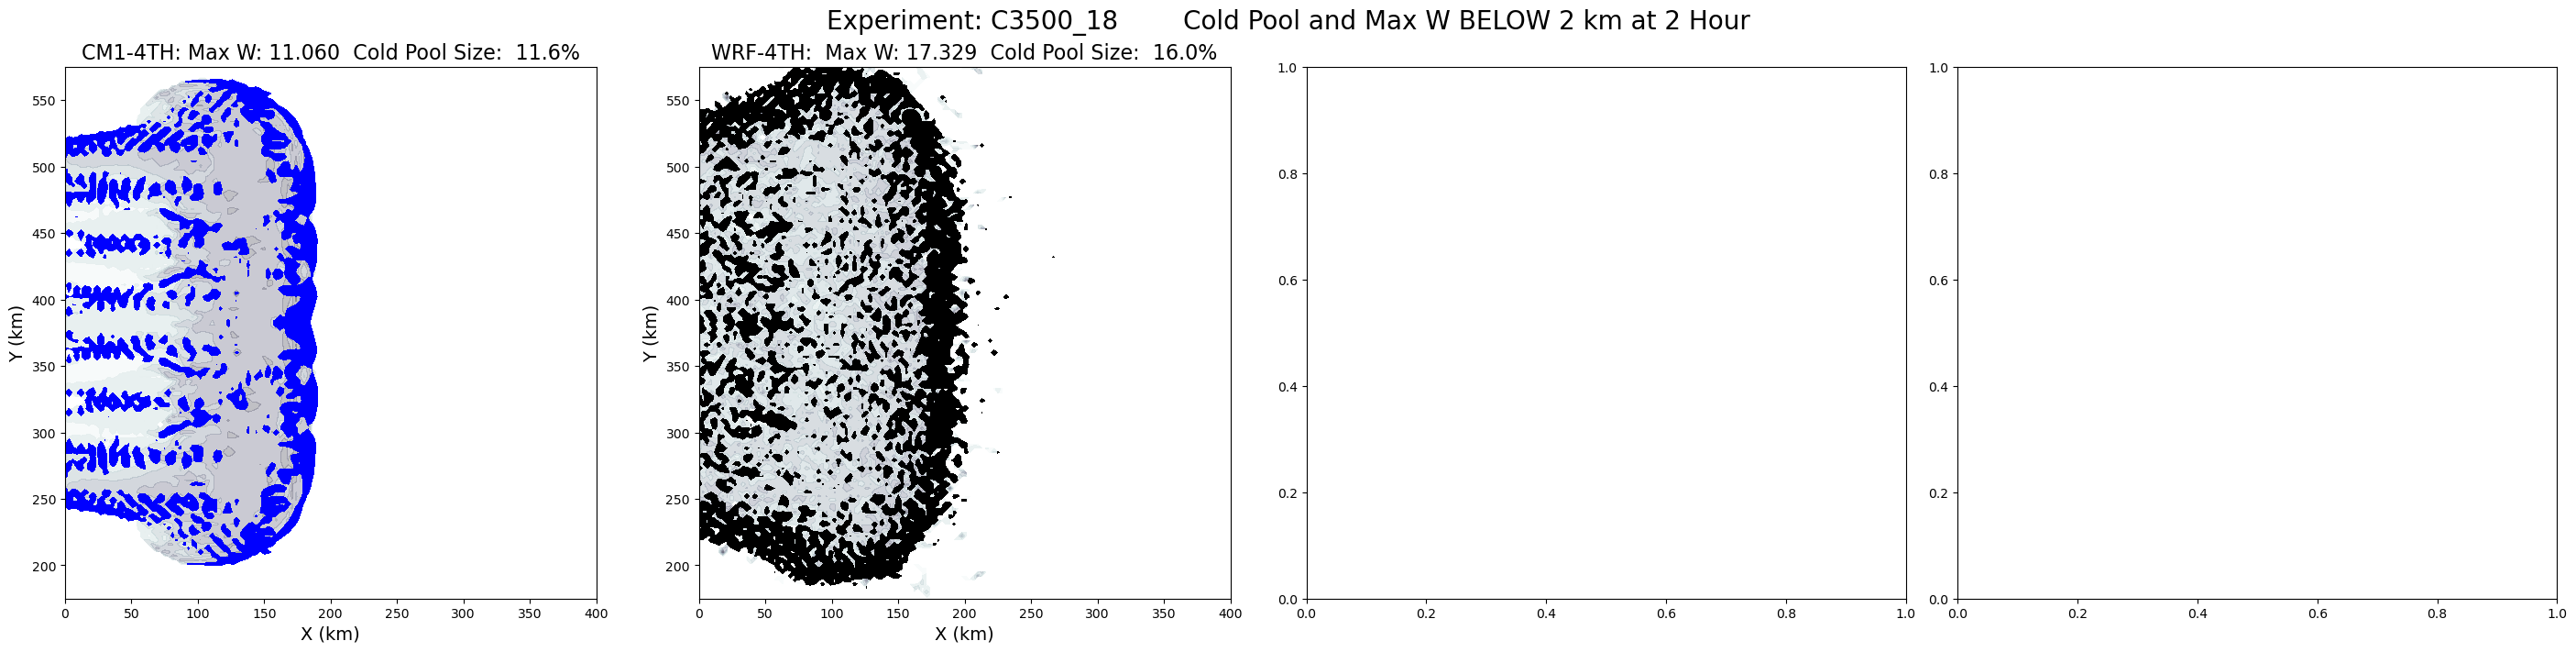

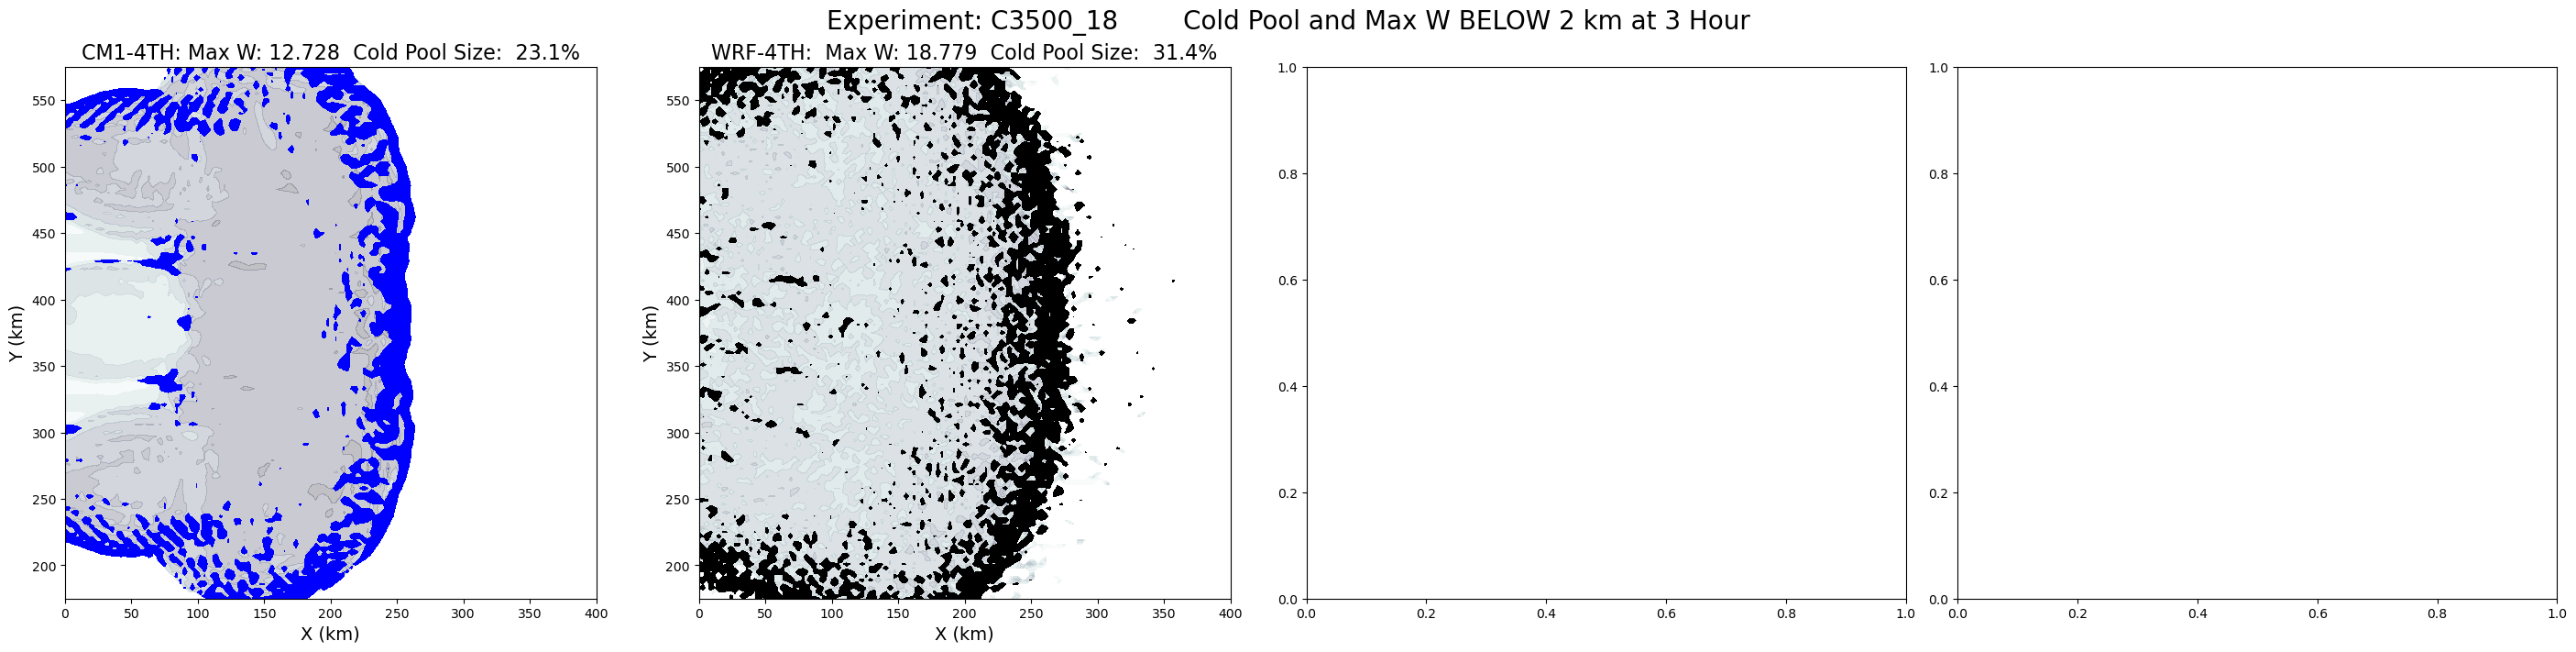

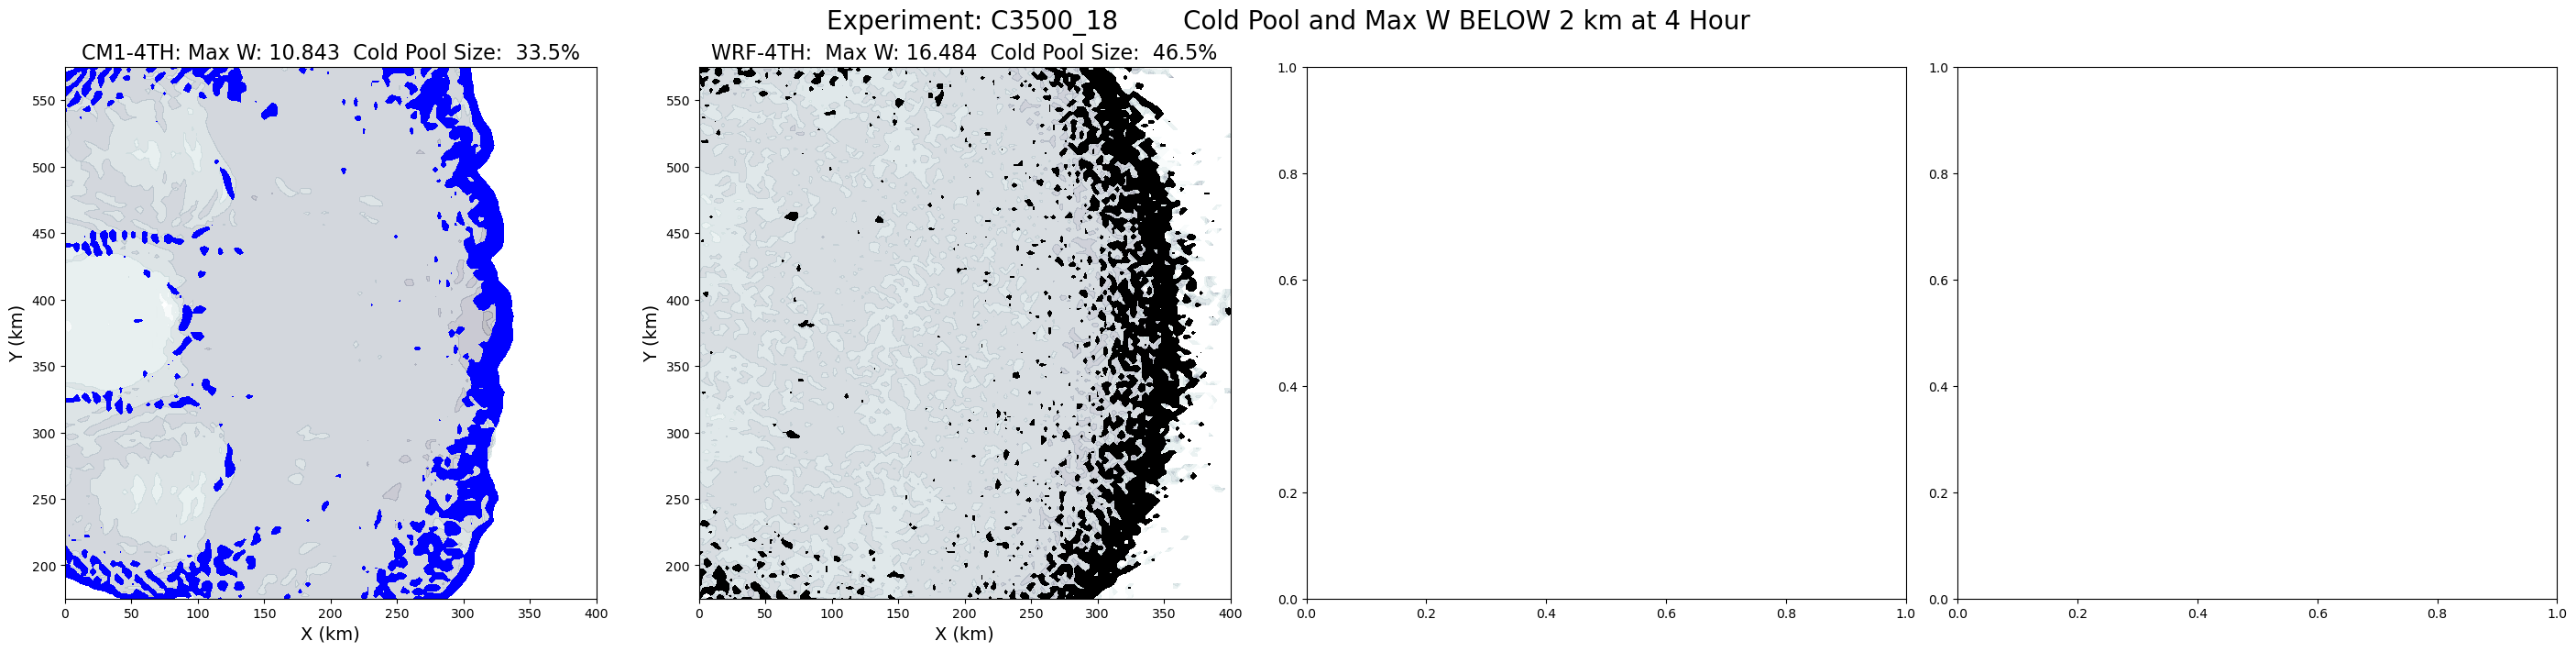

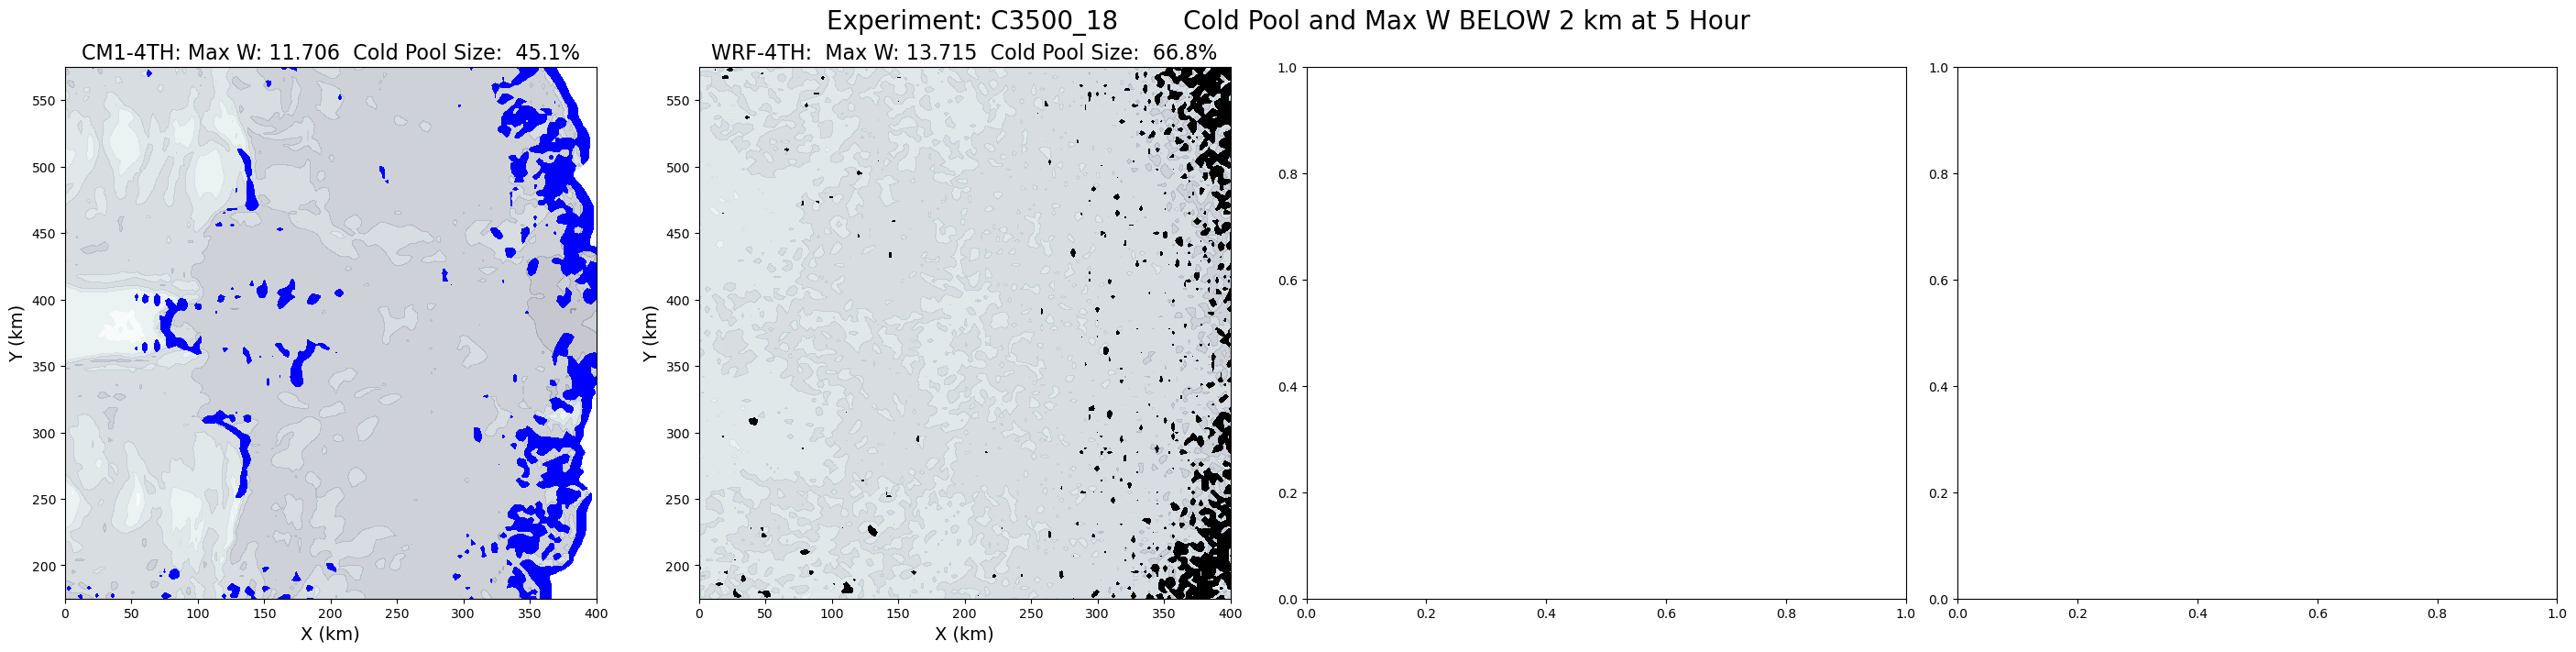

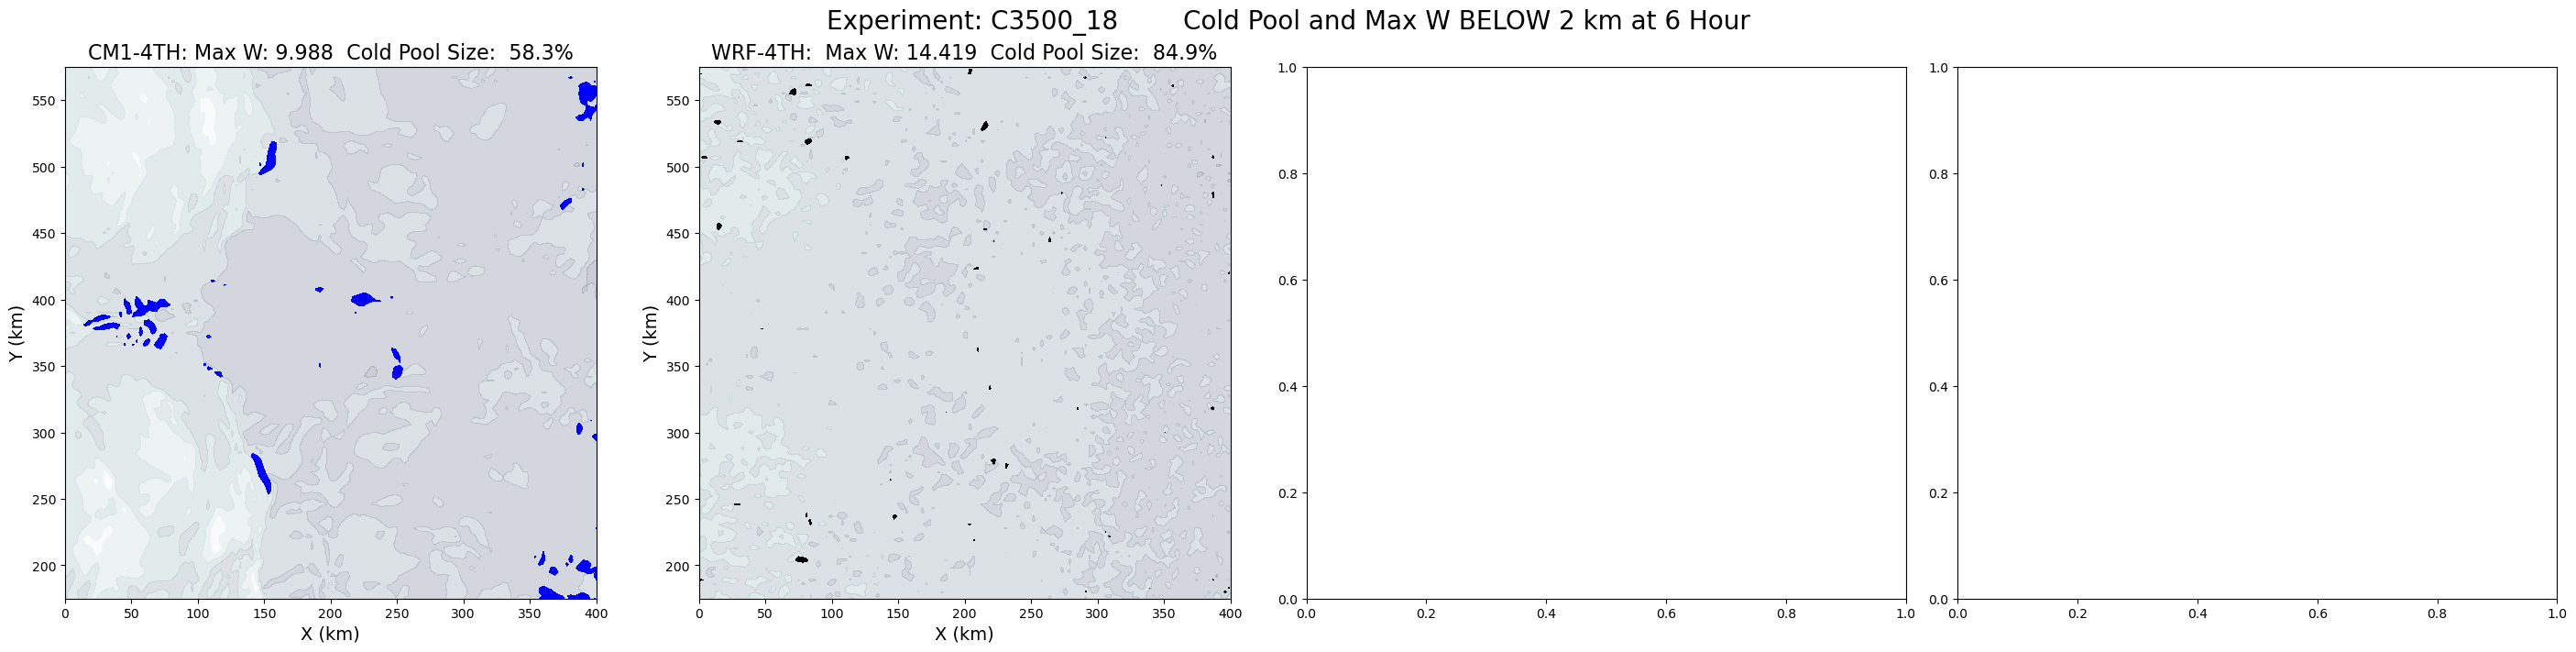

In [5]:
# Just read stuff back in...
            
def plotw(data, label, time = 8, klevel = 18, ax = None, colors='k', alpha=1.0, cref_thresh = 40., marker="s", w_thresh=5.):
    
    W    = data[label]['w'][time,0:klevel]

    THpert  = data[label]['pert_th'][time]
        
    # ctable = radar_colormap()
    # levels = [5 + 5*n for n in range(15)]
    
    x = 3.0*np.arange(W.shape[1])
    y = 3.0*np.arange(W.shape[2])
    xx, yy = np.meshgrid(x,y)
    
    #ax.contourf(np.where(THpert[0] < -1.0, THpert[0], np.nan), clevels=[-1,-2], color='b', alpha=0.5)
    ax.contourf(xx, yy, np.where(THpert[0] < -1.0, THpert[0], np.nan), clevels=[-1,], cmap=plt.get_cmap('bone'), alpha=0.3)

    ax.contourf(xx, yy, W.max(axis=0), levels=[1.,100.], colors=colors)

    # ax.set_ylim(0.5*yy.max() - 225, 0.5*yy.max() + 225)
    ax.set_ylim(175., 575.)
    ax.set_xlim(0., 400.)
    ax.set_xlabel('X (km)', fontsize=14)
    ax.set_ylabel('Y (km)', fontsize=14)
    ax.set_aspect('equal')
    
    return W.max(), 100*np.where(THpert[0] < -1.0, 1.0, 0.0).sum()/(THpert[0].shape[0]*THpert[0].shape[1])

#-----------------------------
allcape = ("C2000","C3500")
allshear = ("06","18")

for shear in allshear:
    for cape in allcape:
        
        for n in [1, 2, 3, 4, 5, 6]:
            
            fig, ax = plt.subplots(1,4, constrained_layout=True,figsize=(28,7))

            label = "%s_%s" % (cape, shear)

            o4, pix = plotw(models['cm1-4'], label, ax = ax[0], time=1+n*4-1, colors='b', marker="s")

            ax[0].set_title("CM1-4TH: Max W: %3.3f  Cold Pool Size:  %3.1f%%" % (o4, pix), fontsize=16)

            o4, pix = plotw(models['wrf-4'], label, ax = ax[1], time=1+n*4-1, colors='k', marker="s")

            ax[1].set_title("WRF-4TH:  Max W: %3.3f  Cold Pool Size:  %3.1f%%" % (o4, pix), fontsize=16)

            # o4, pix = plotw(models['mpas'], label, ax = ax[2], time=1+n*4-1, colors='g', marker="s")

            # ax[2].set_title("MPAS: Max W: %3.3f  Cold Pool Size:  %3.1f%%" % (o4, pix), fontsize=16)
            
            # o4, pix = plotw(models['mpas3'], label, ax = ax[3], time=1+n*4-1, colors='r', marker="s")

            # ax[3].set_title("MPAS-3OT: Max W: %3.3f  Cold Pool Size:  %3.1f%%" % (o4, pix), fontsize=16)

            plt.suptitle("Experiment: %s        Cold Pool and Max W BELOW 2 km at %d Hour" % (label, n), fontsize=20)
            
            plt.savefig("LL_W_Hour%d_%s.png" % (n, label))

            plt.show()

In [6]:
    
#models['mpas'] = pickle2Obj('object_stat/mpas_squall_3km_obj.pkl',retObj=False)


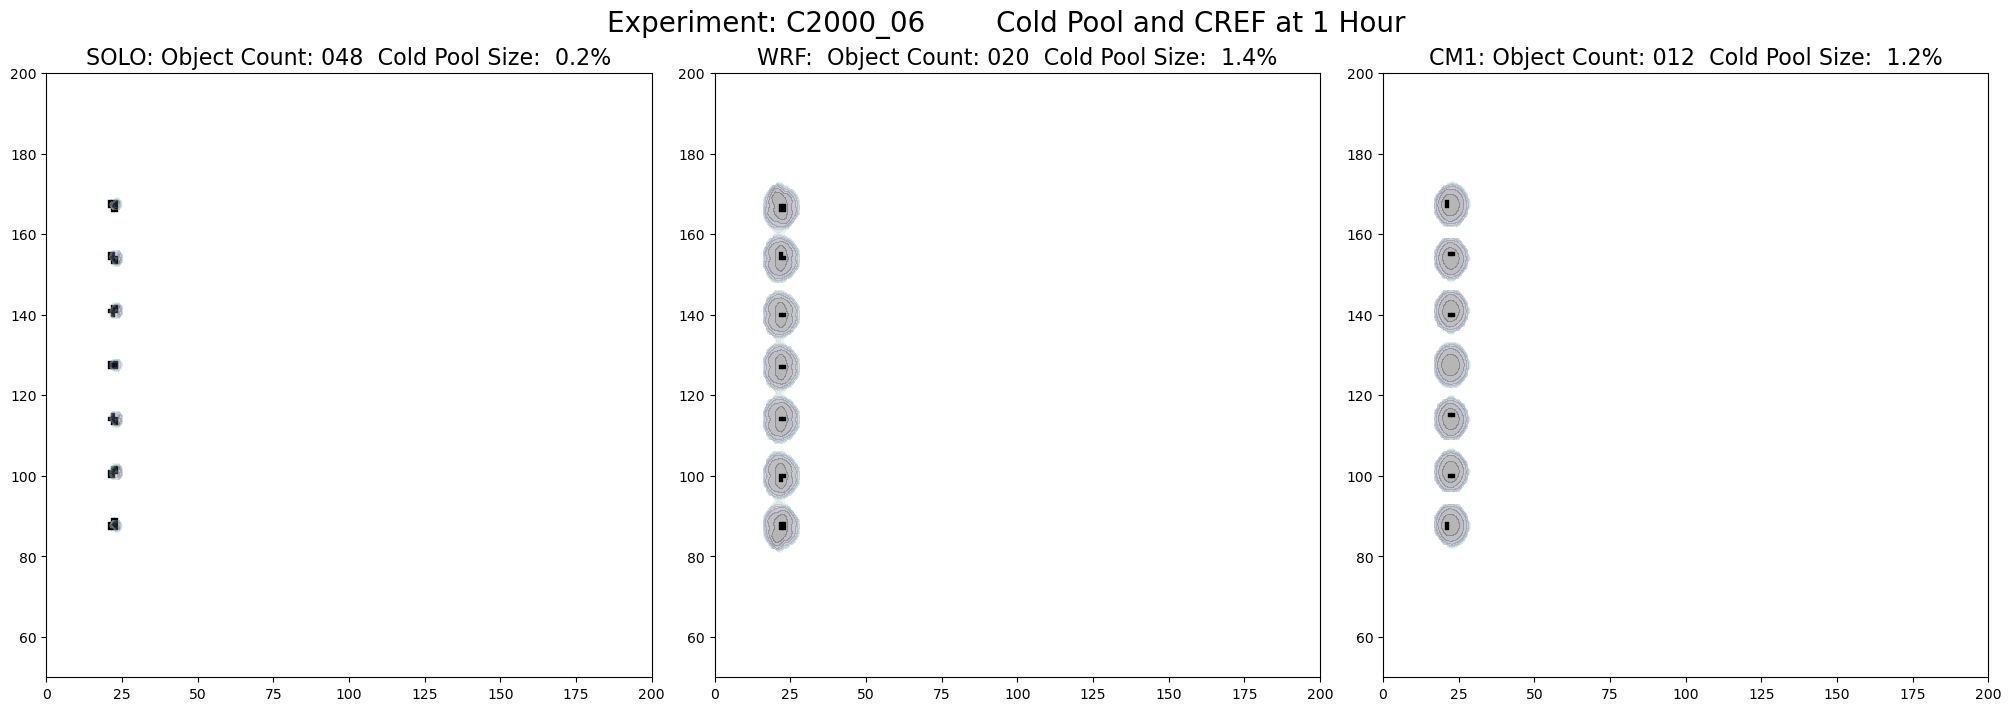

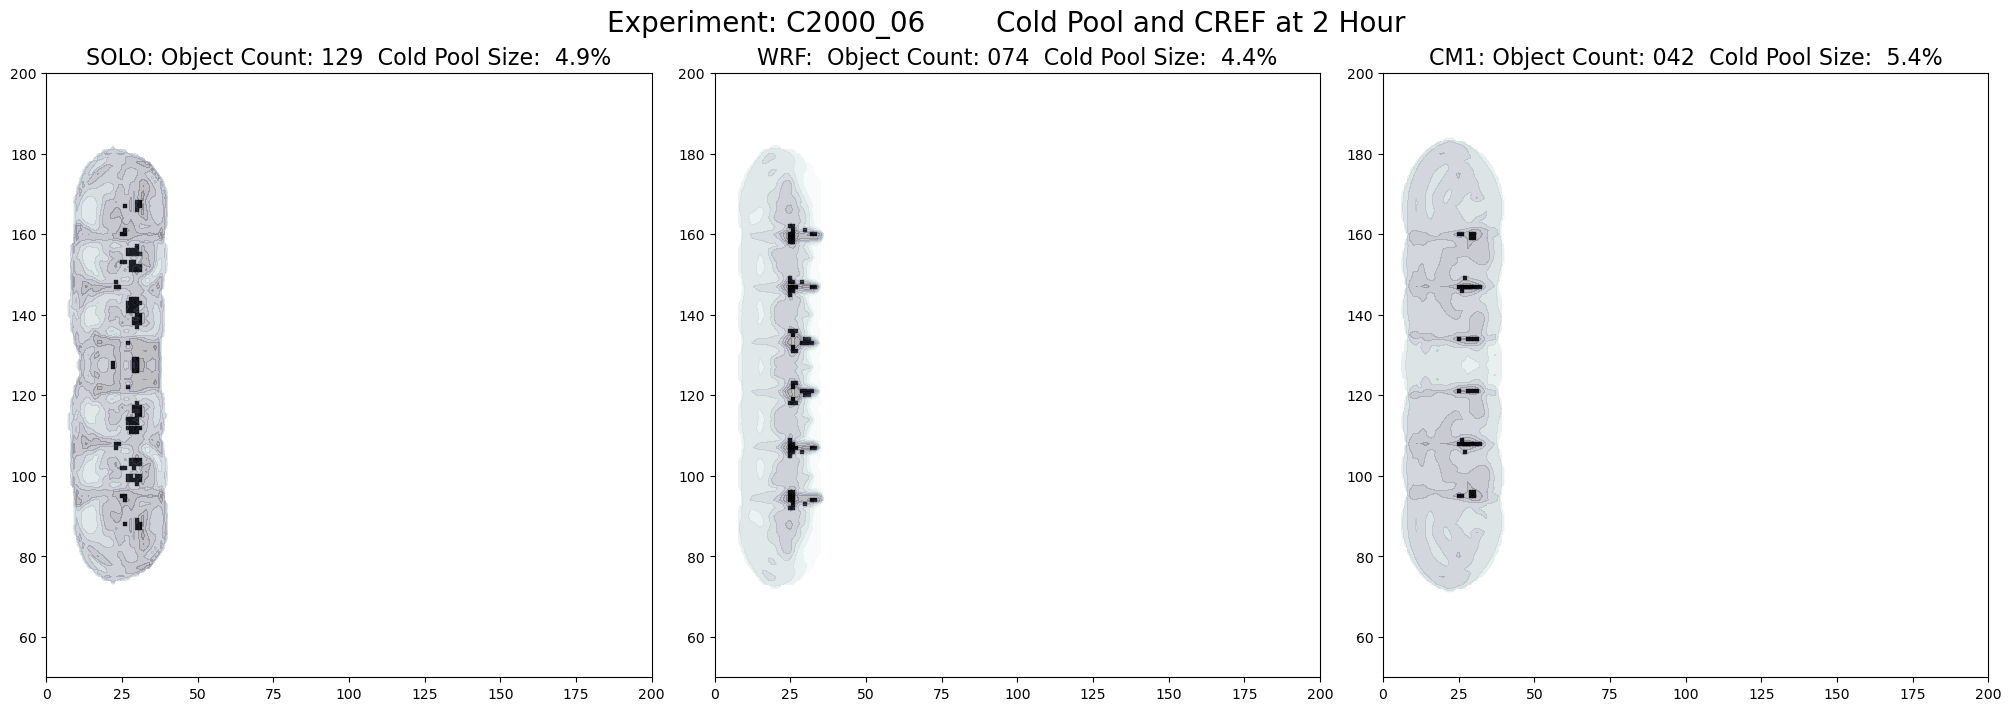

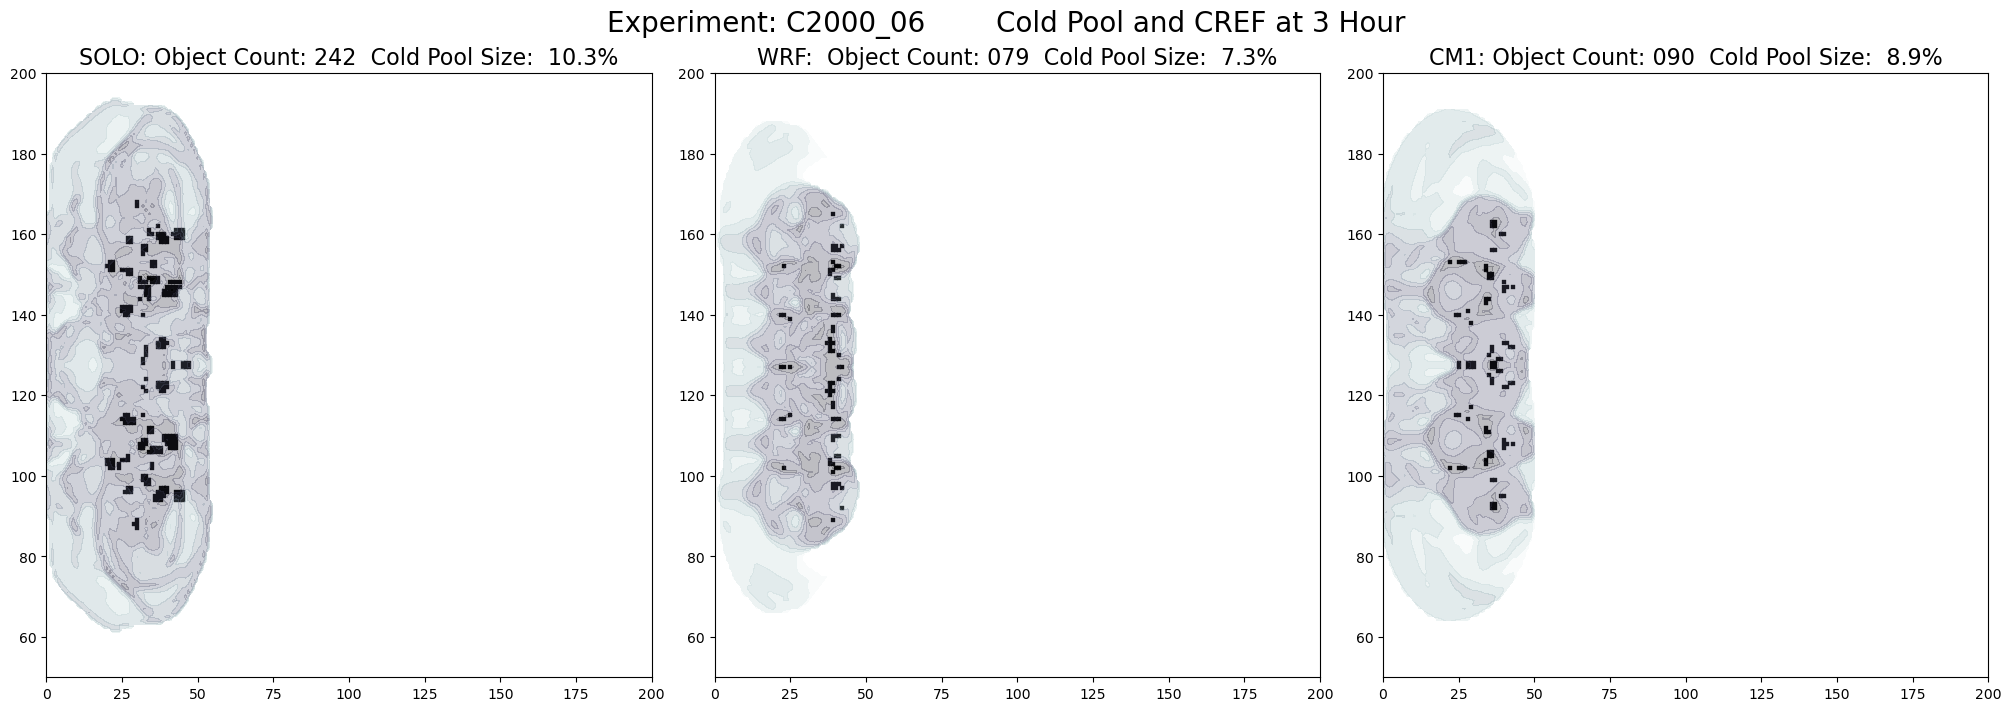

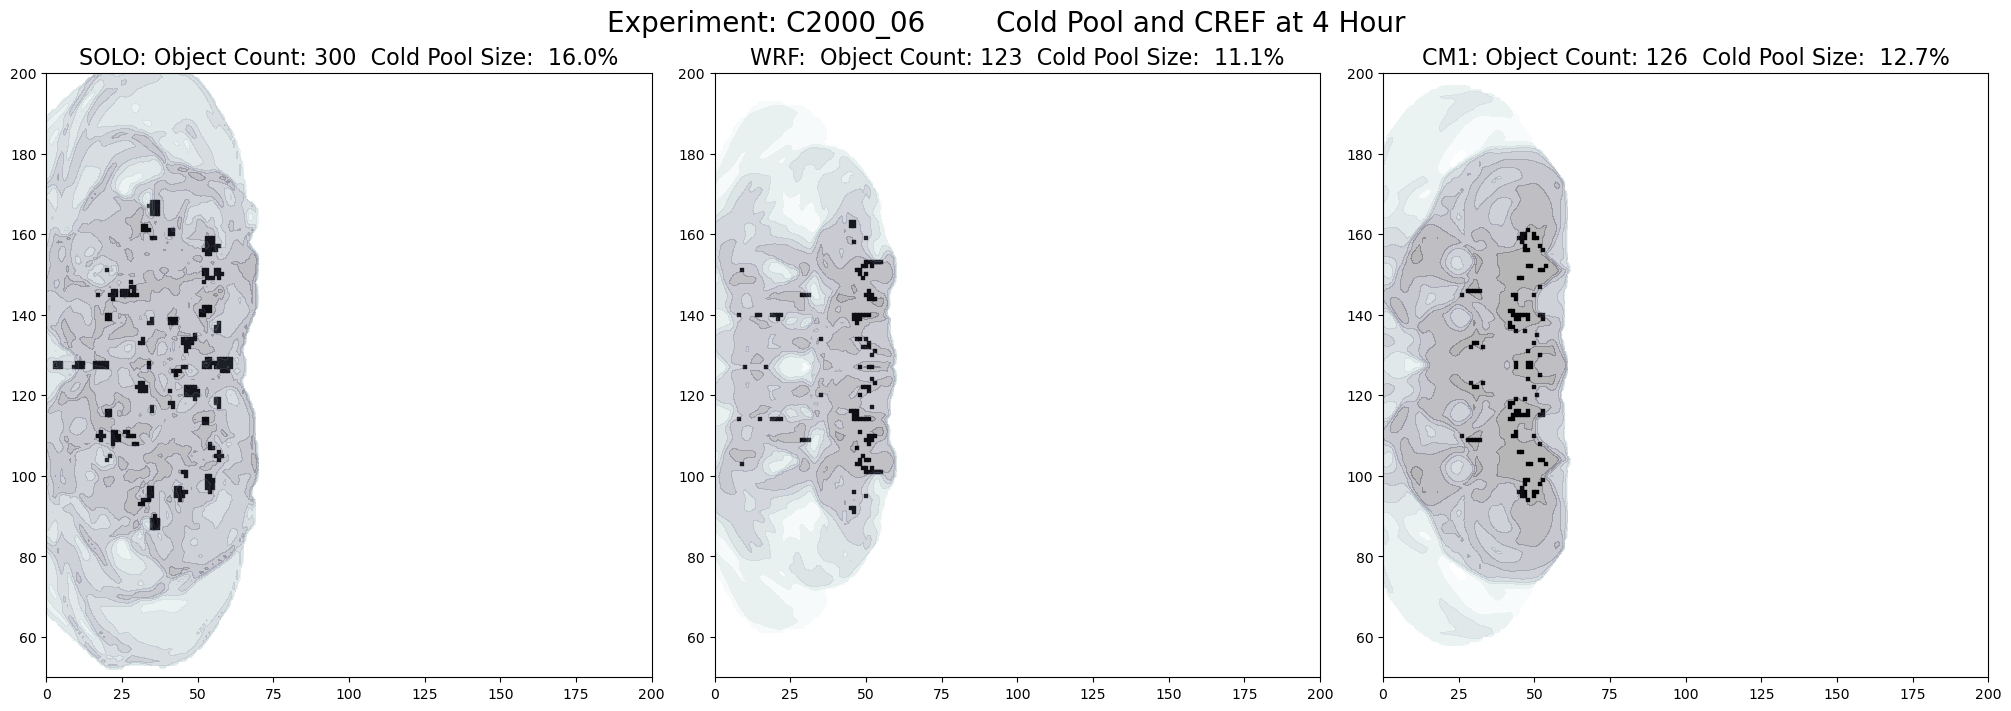

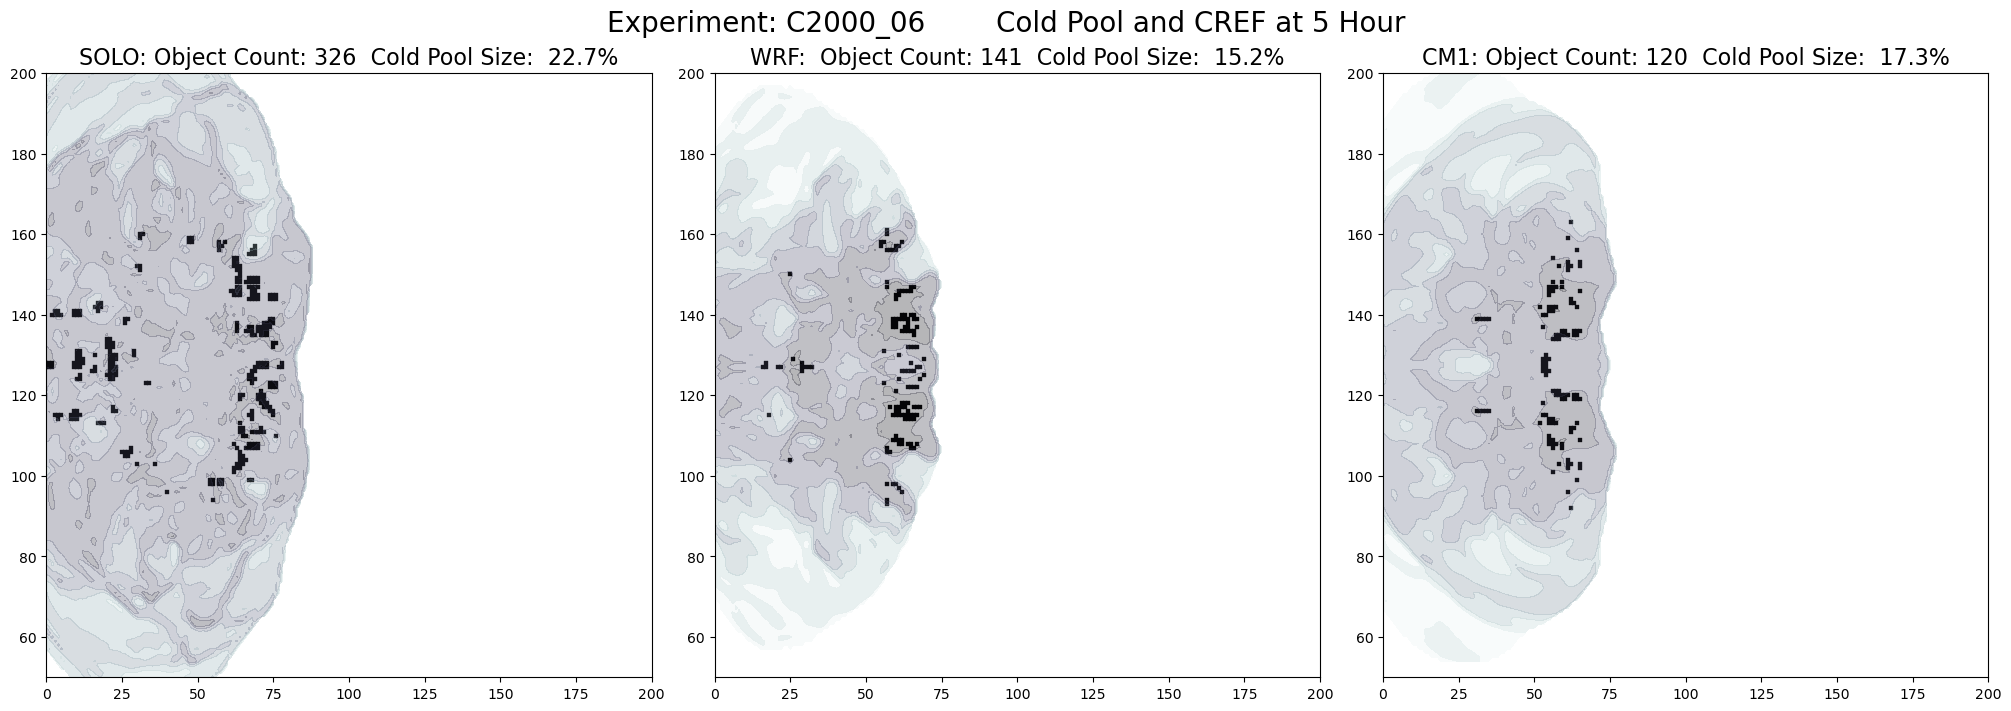

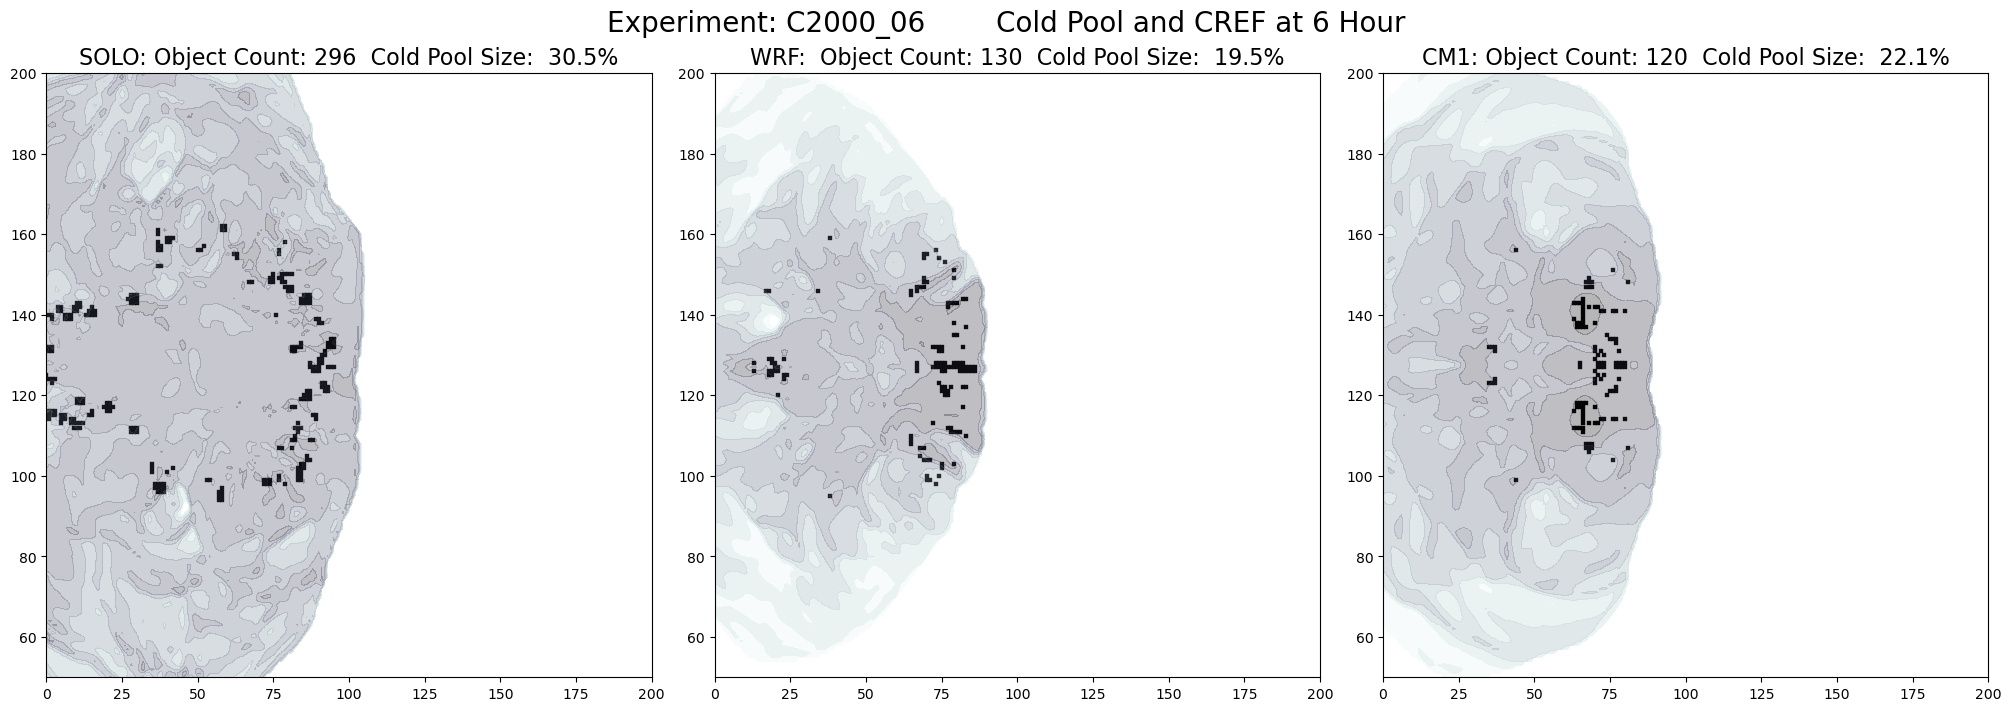

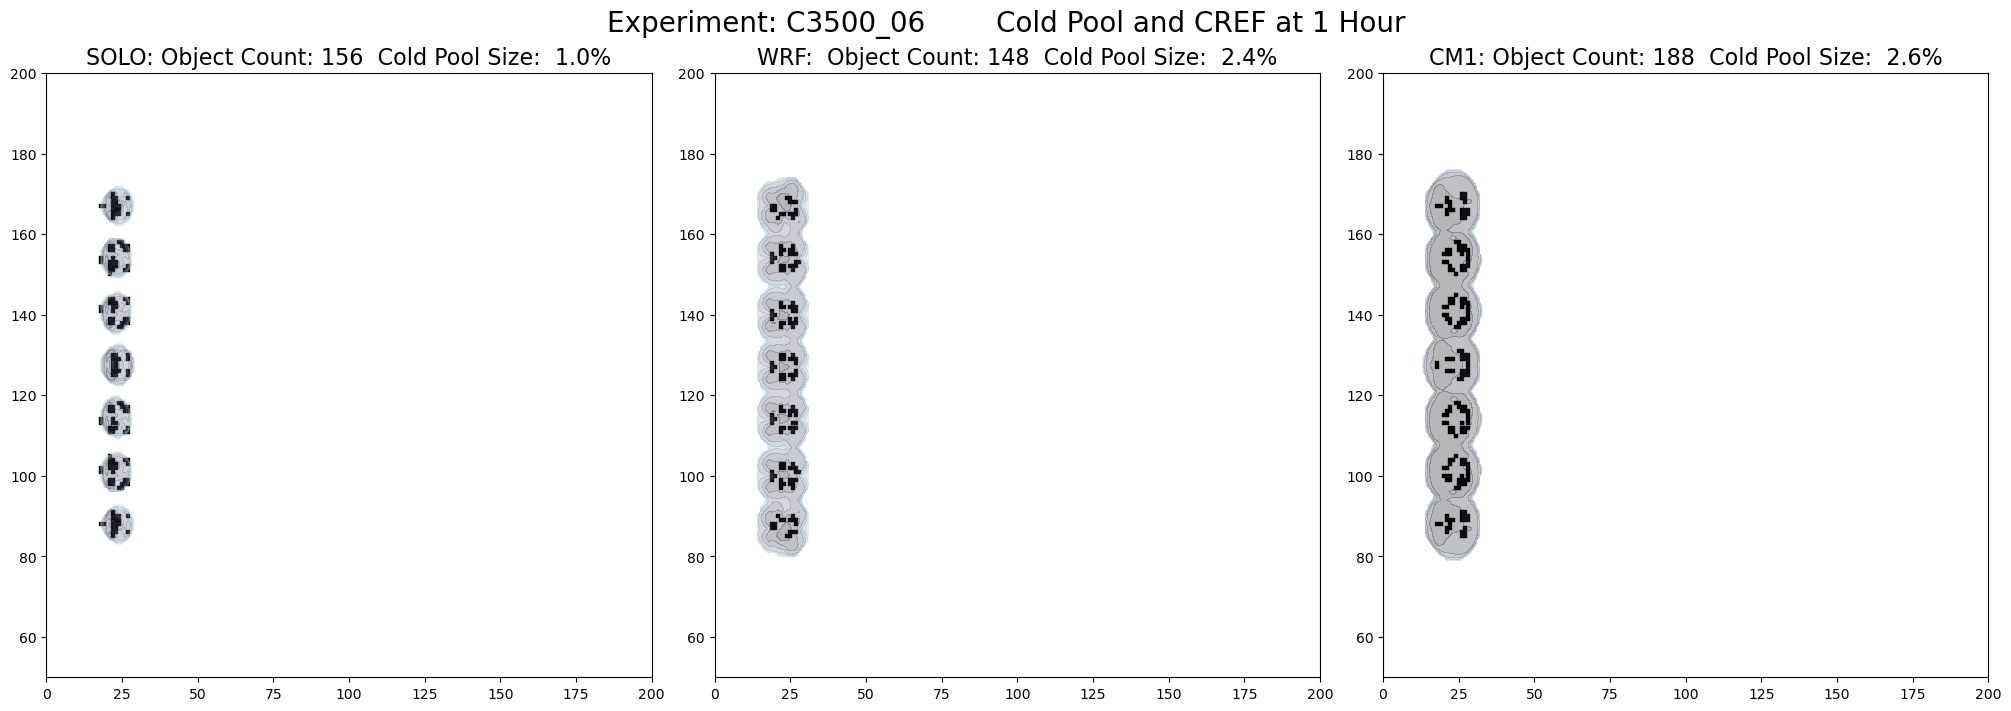

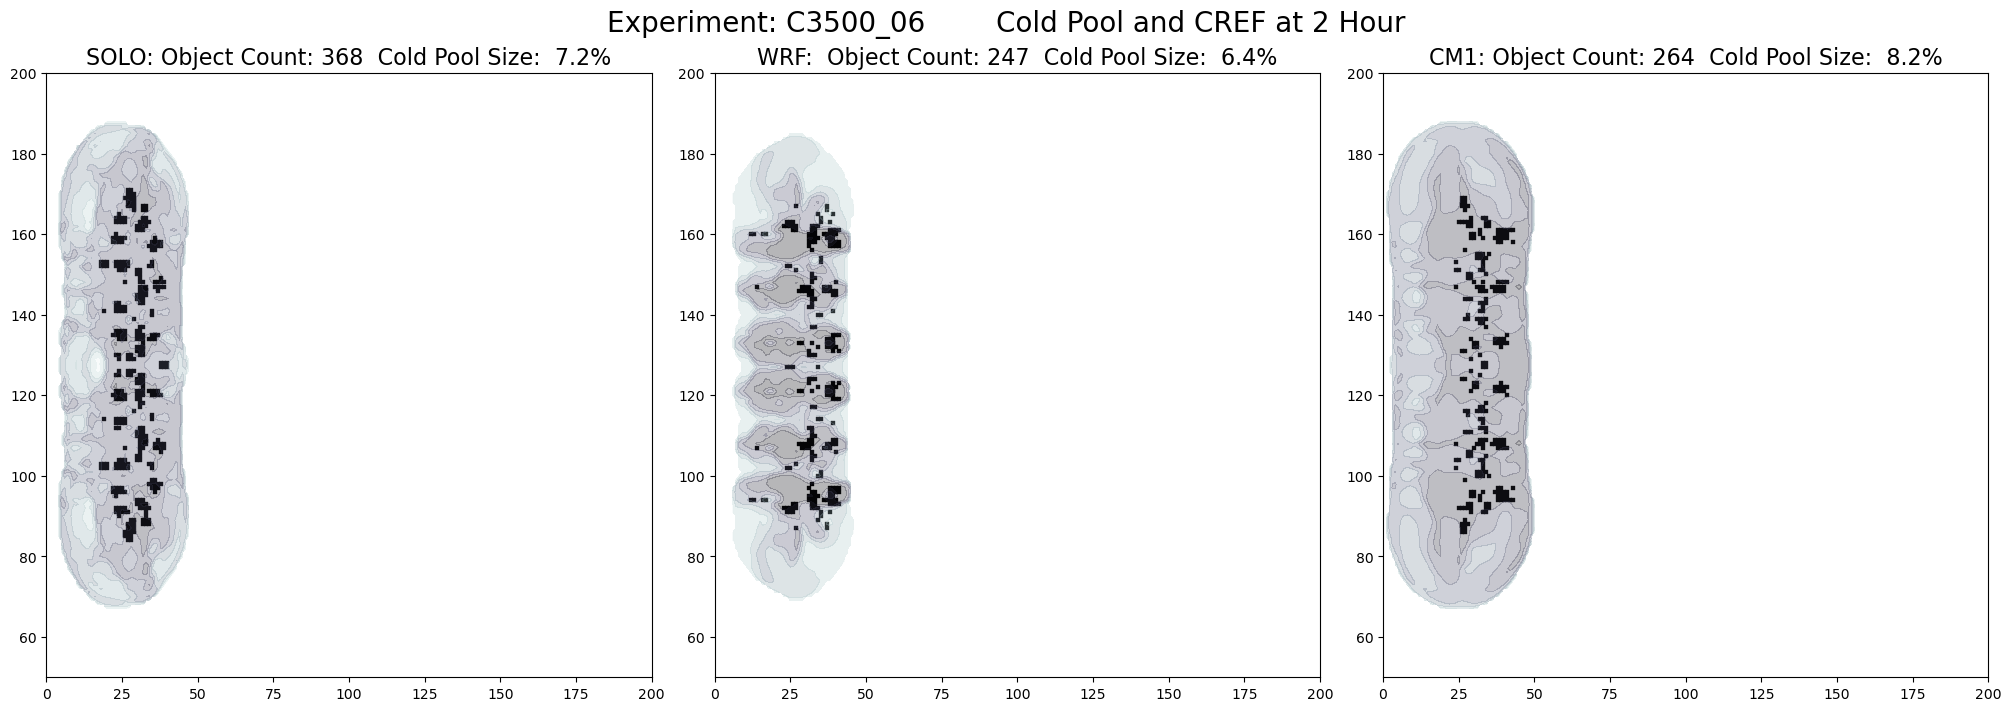

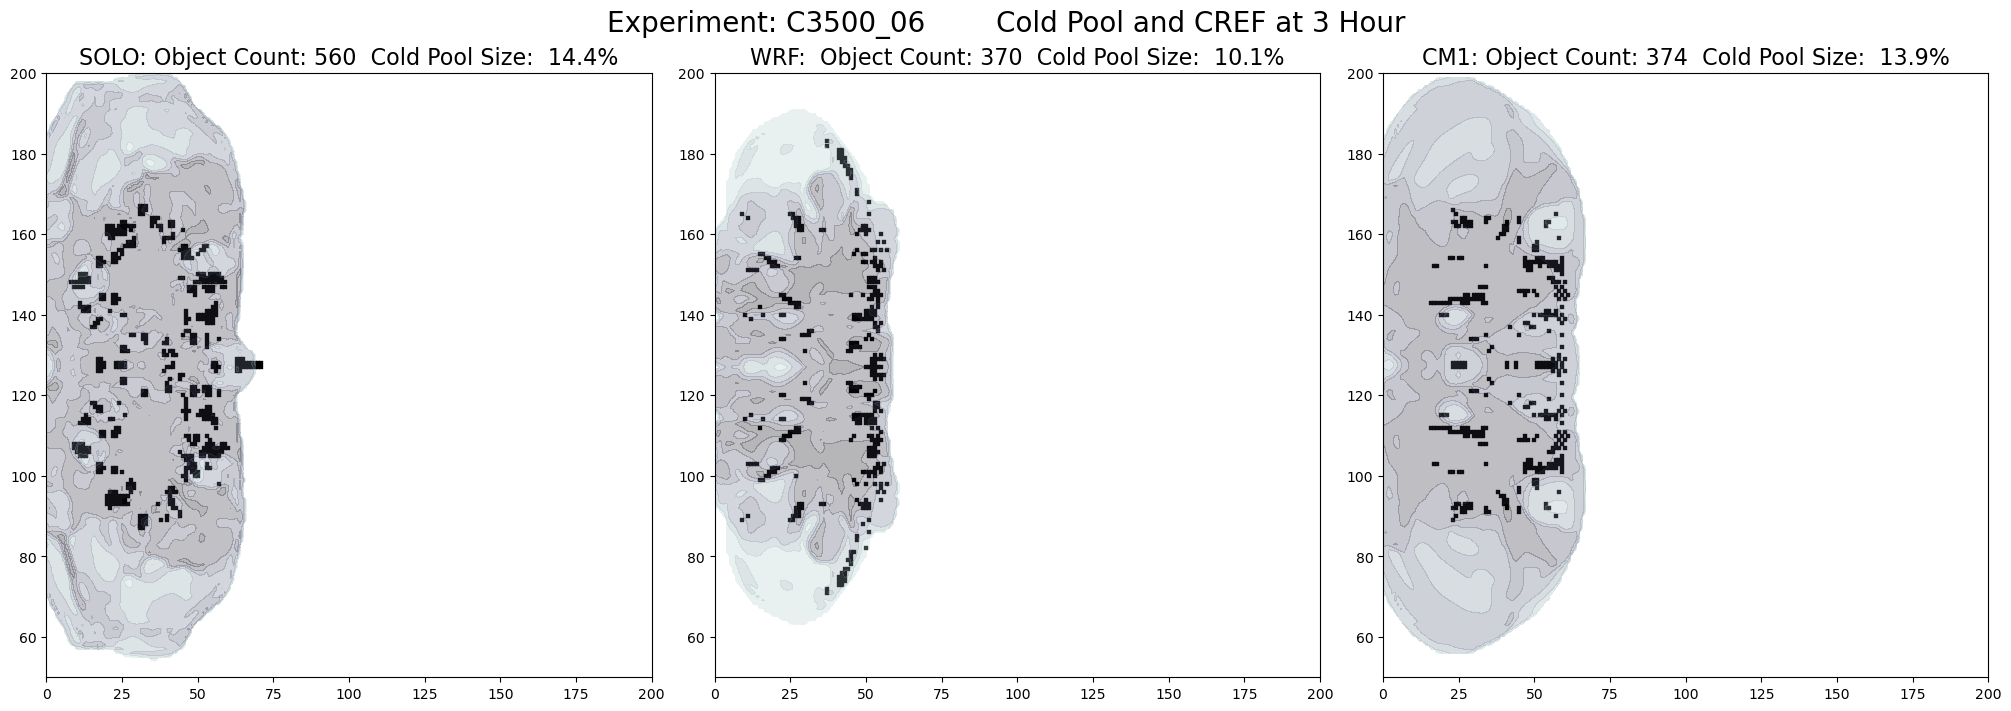

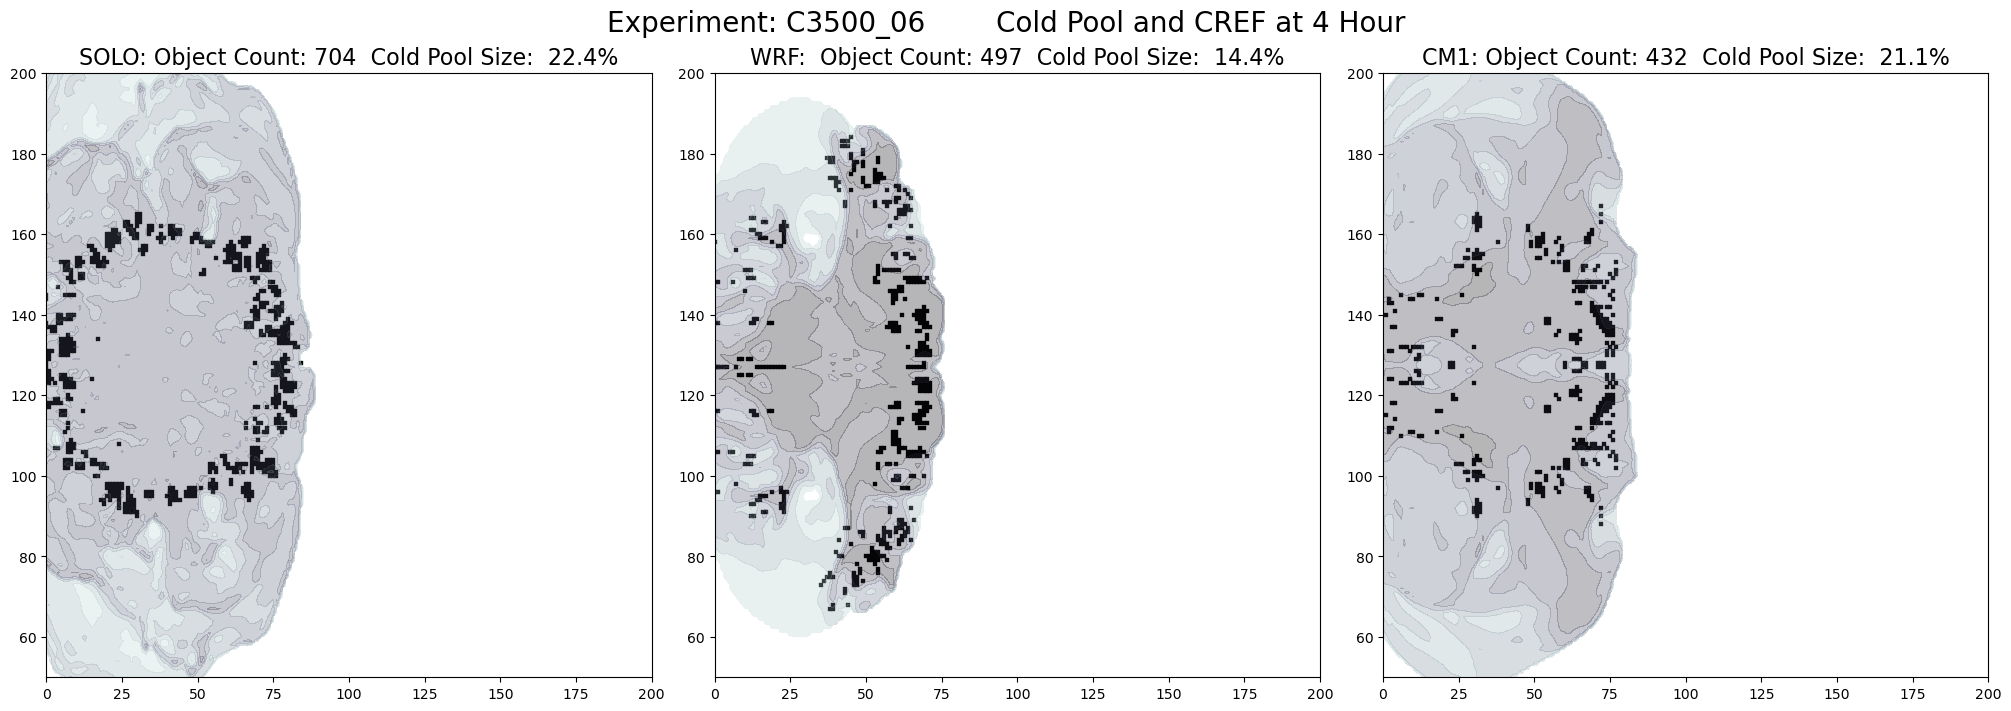

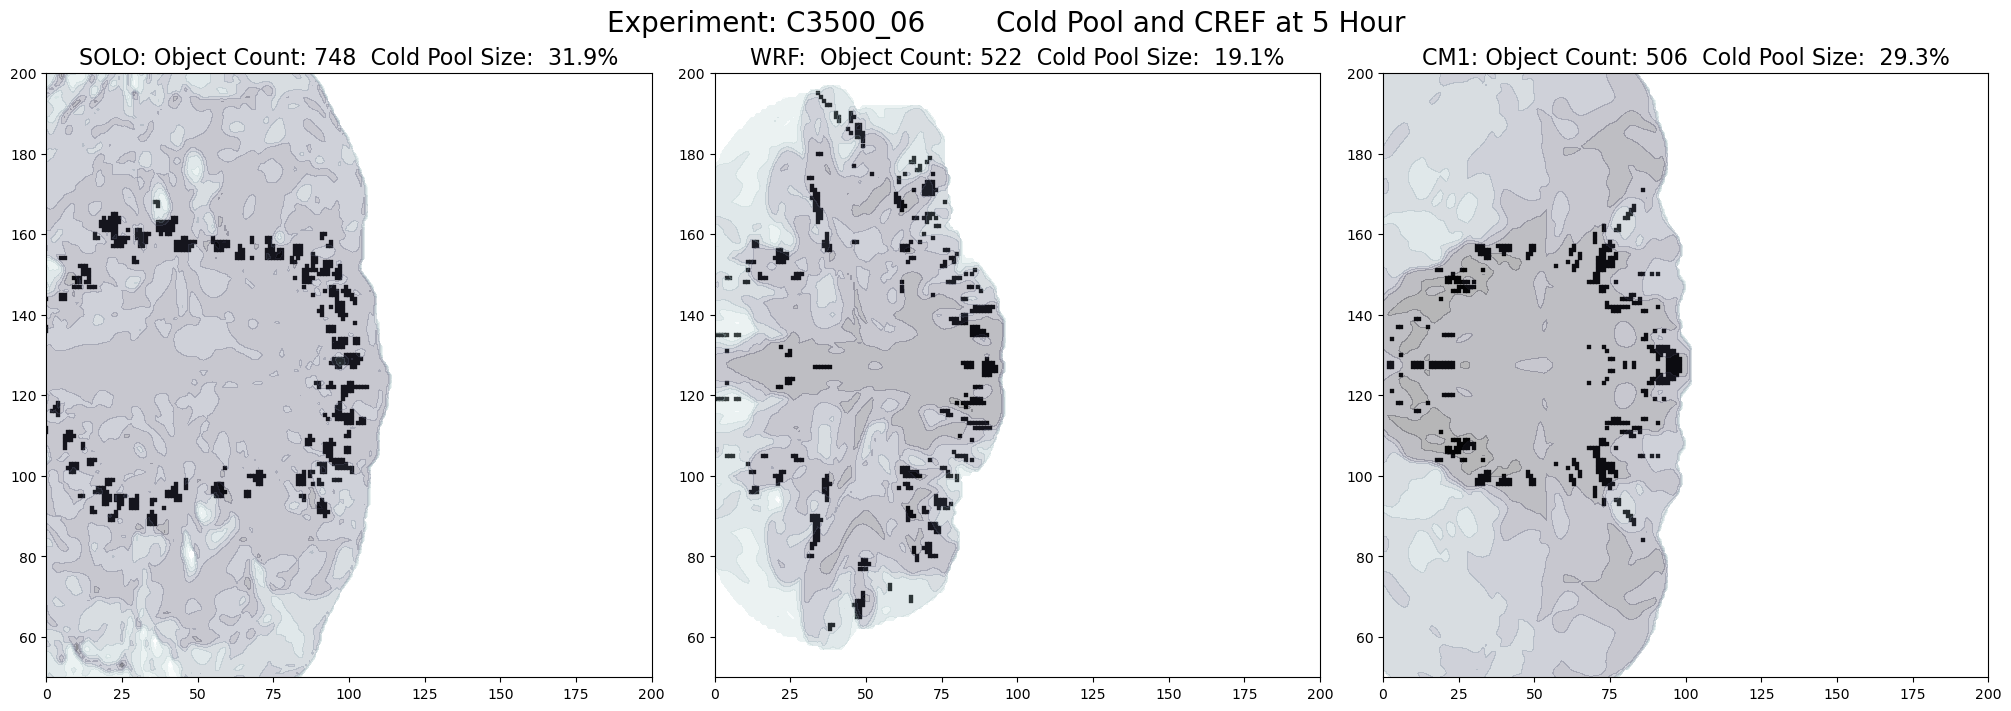

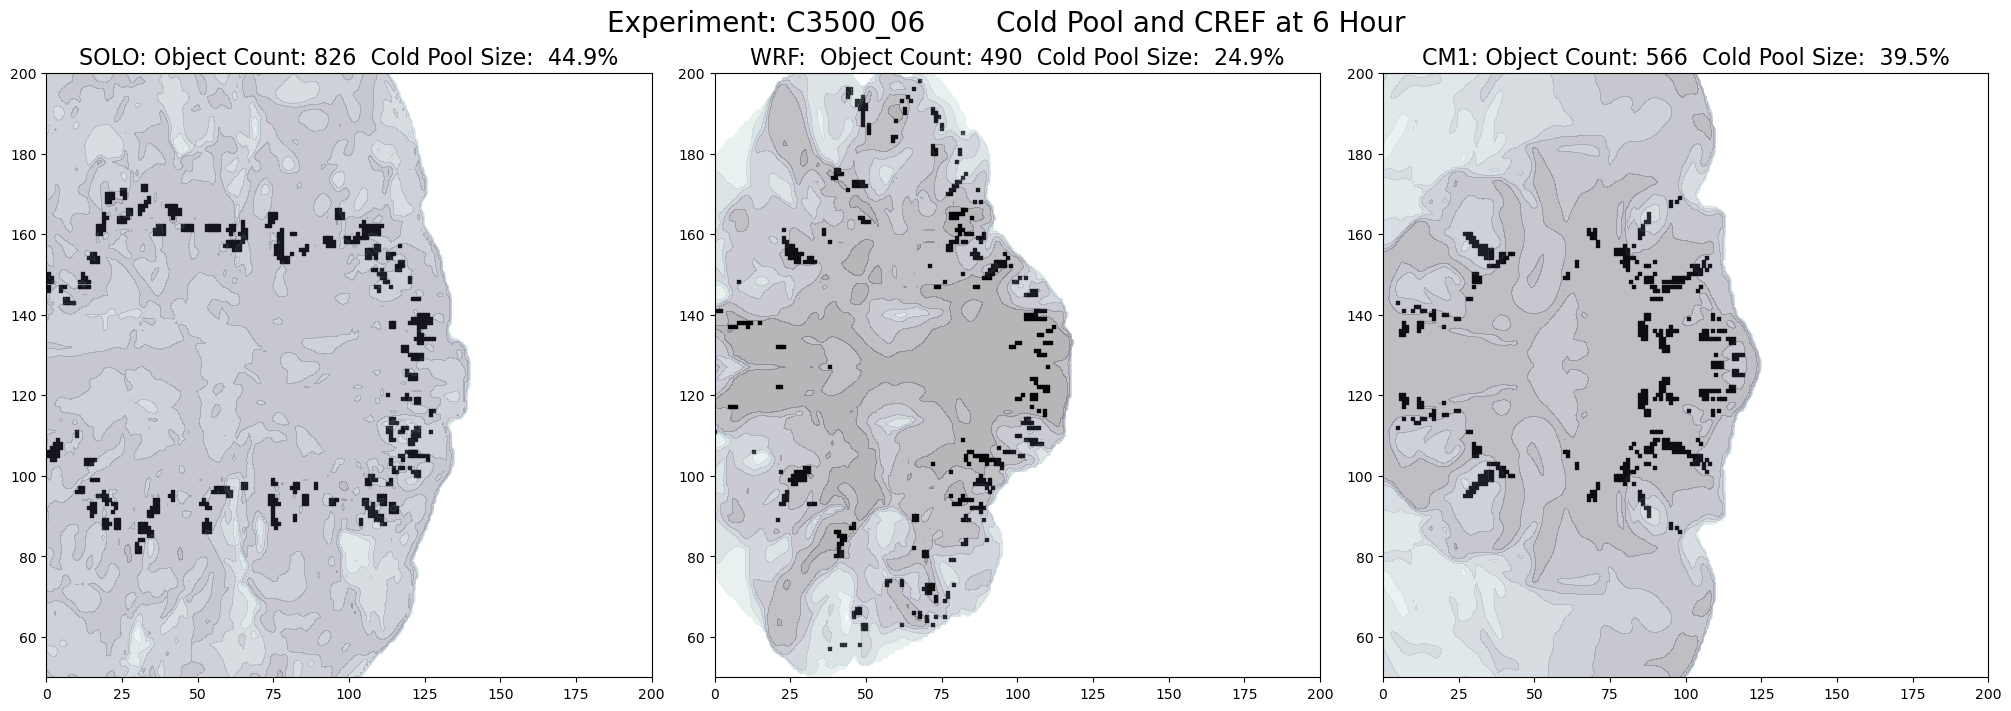

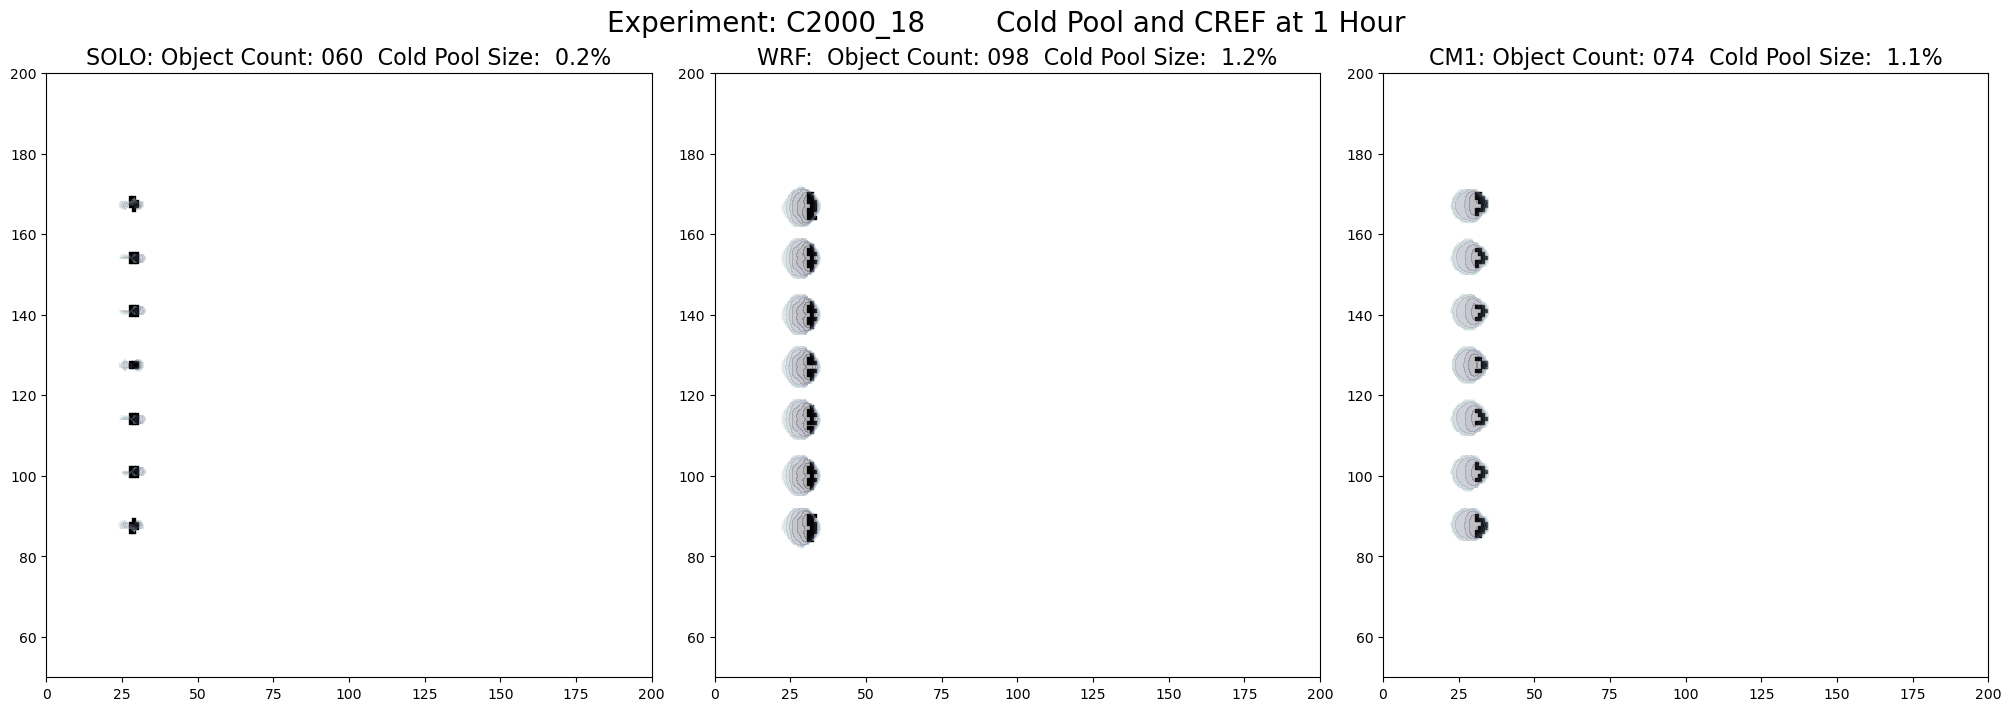

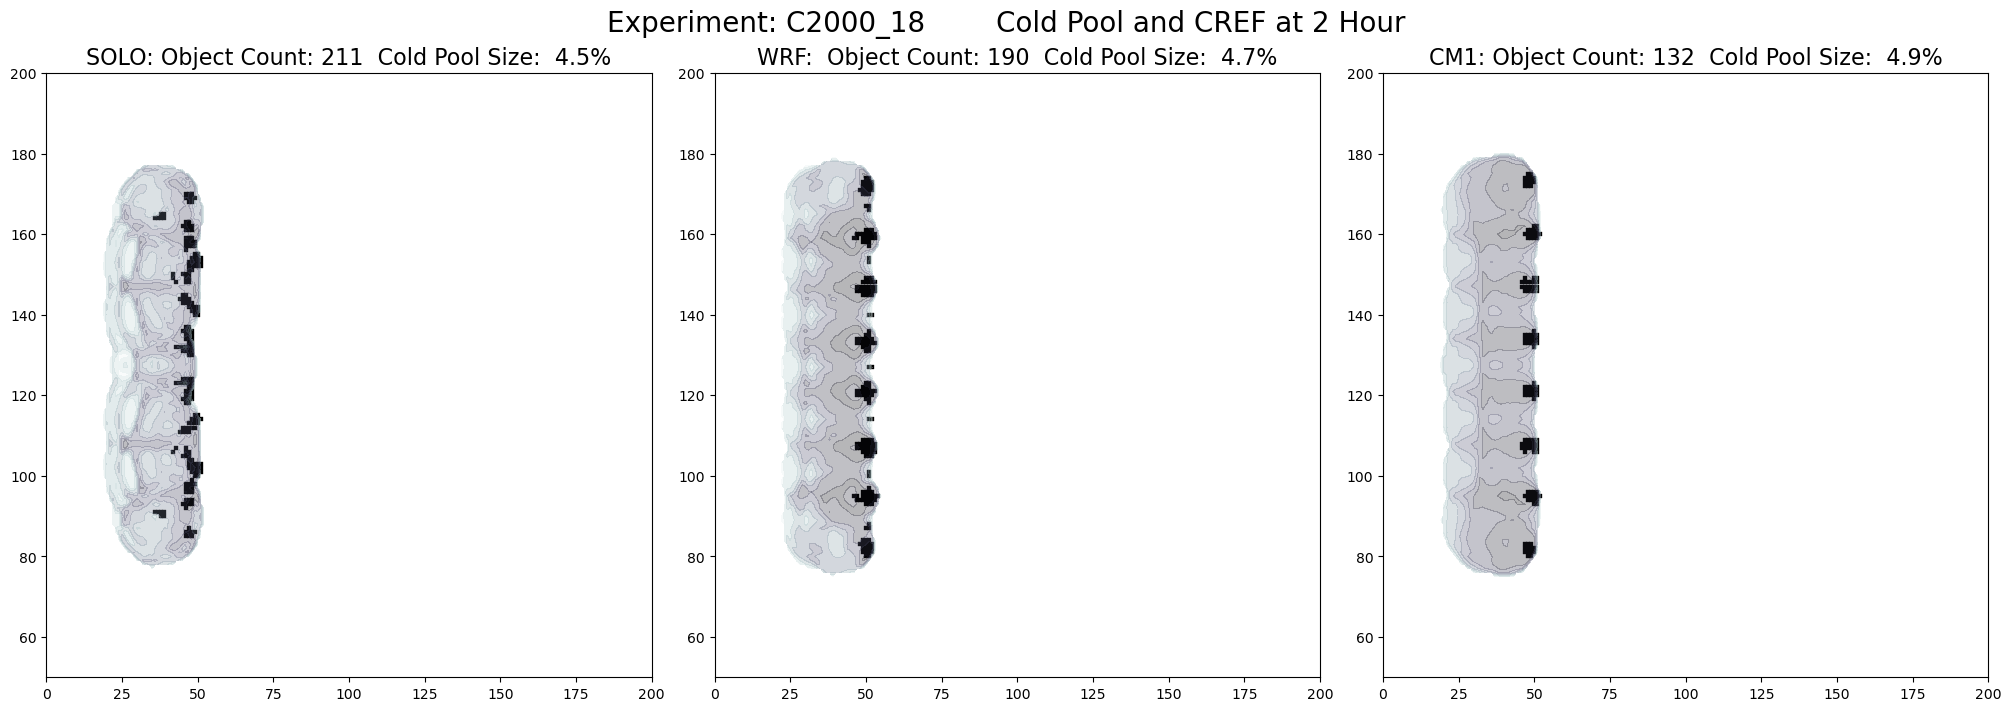

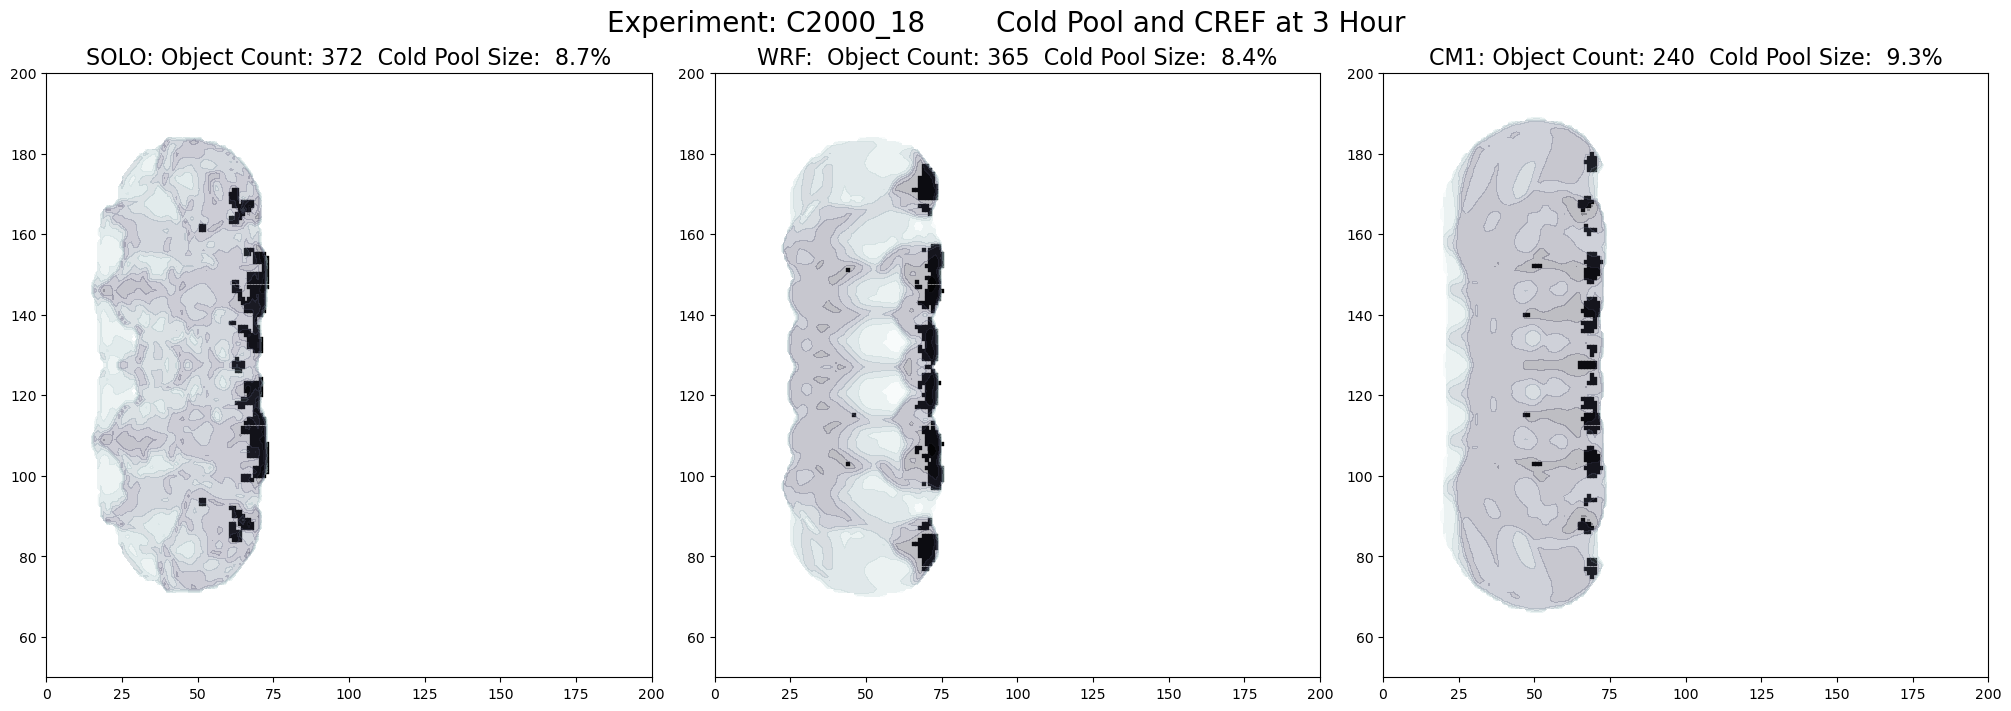

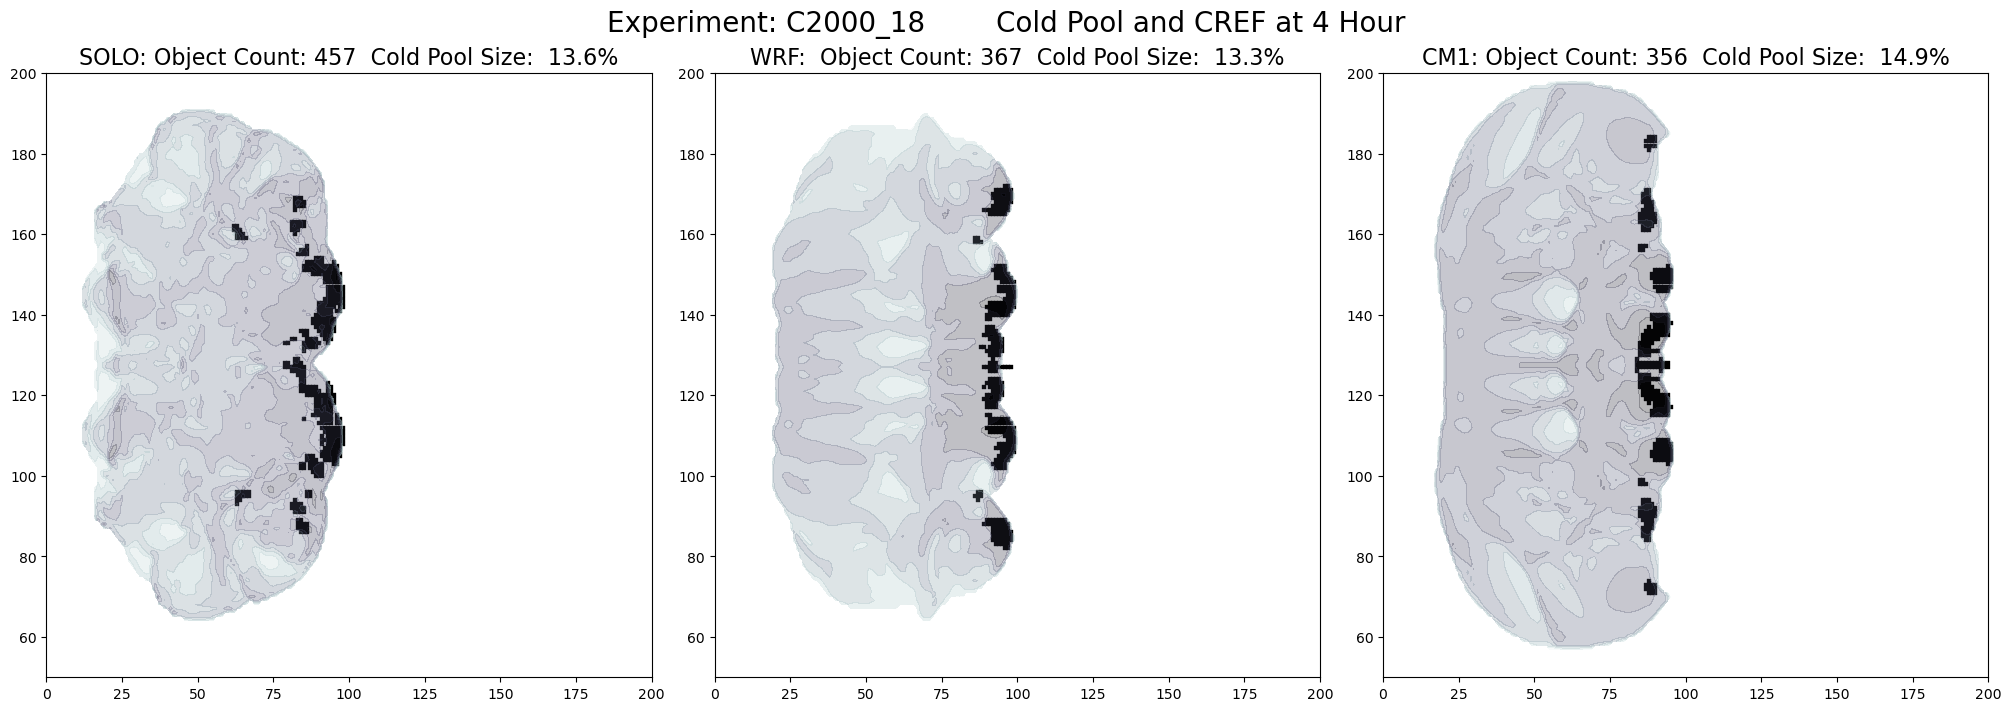

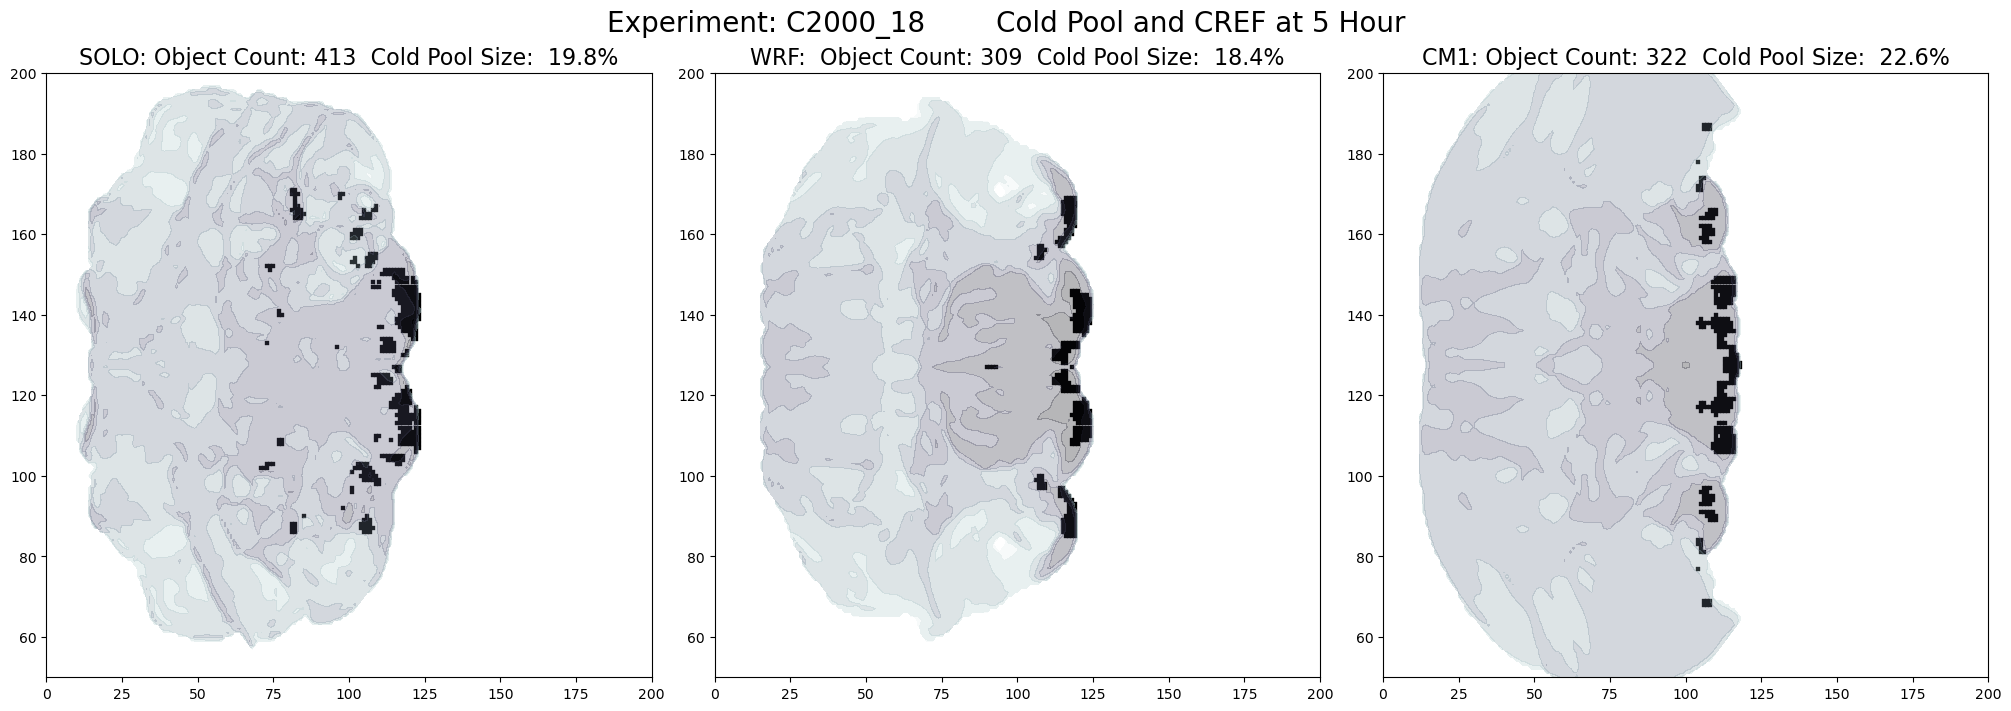

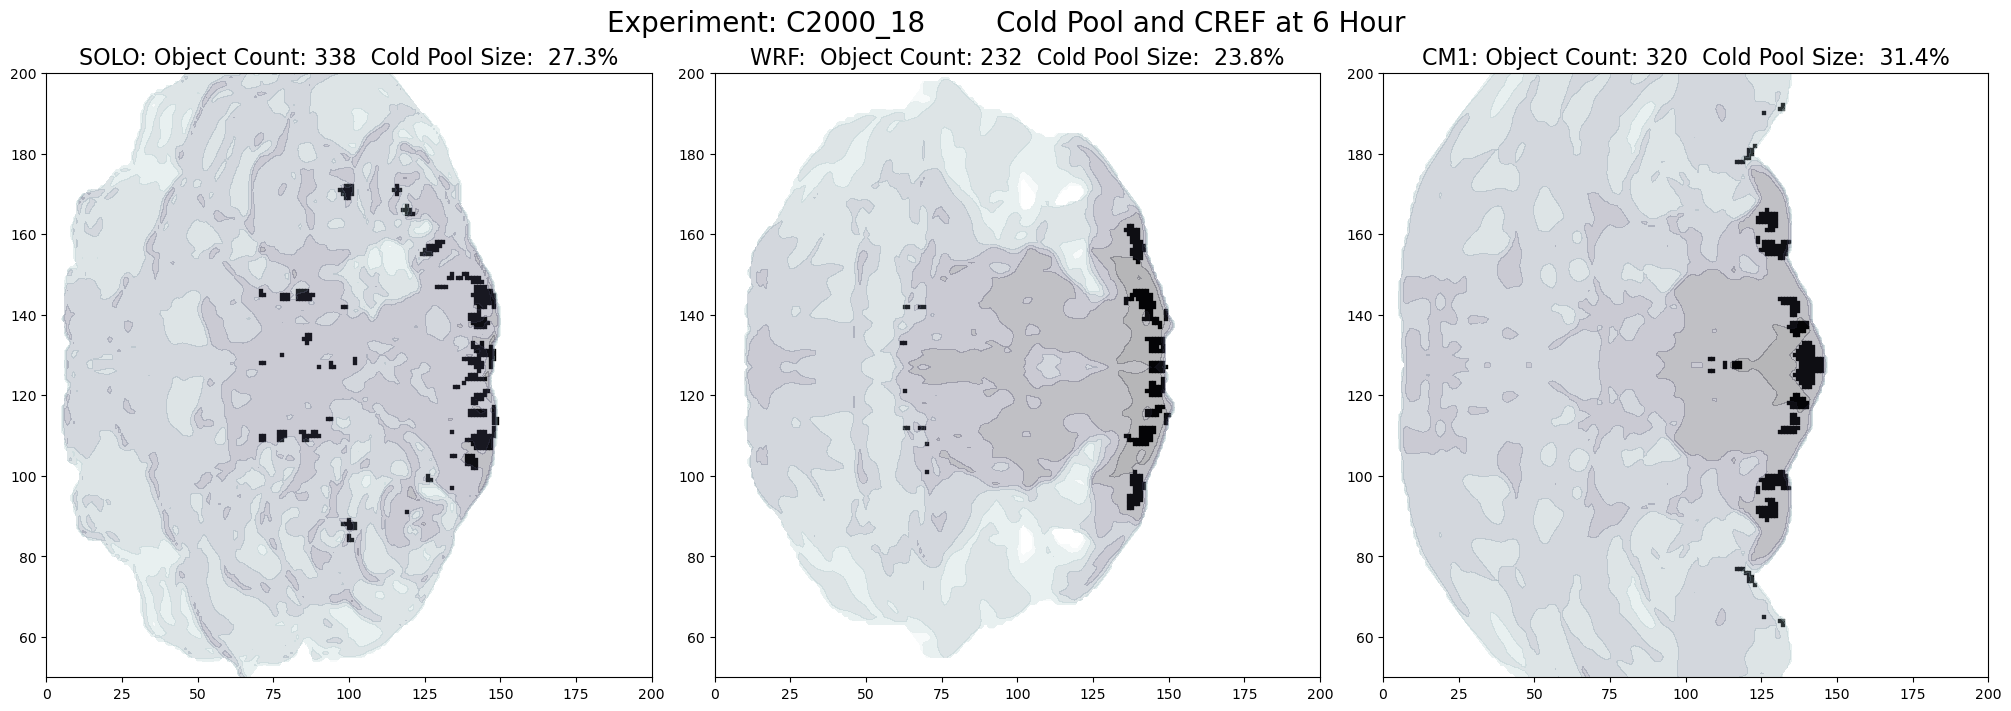

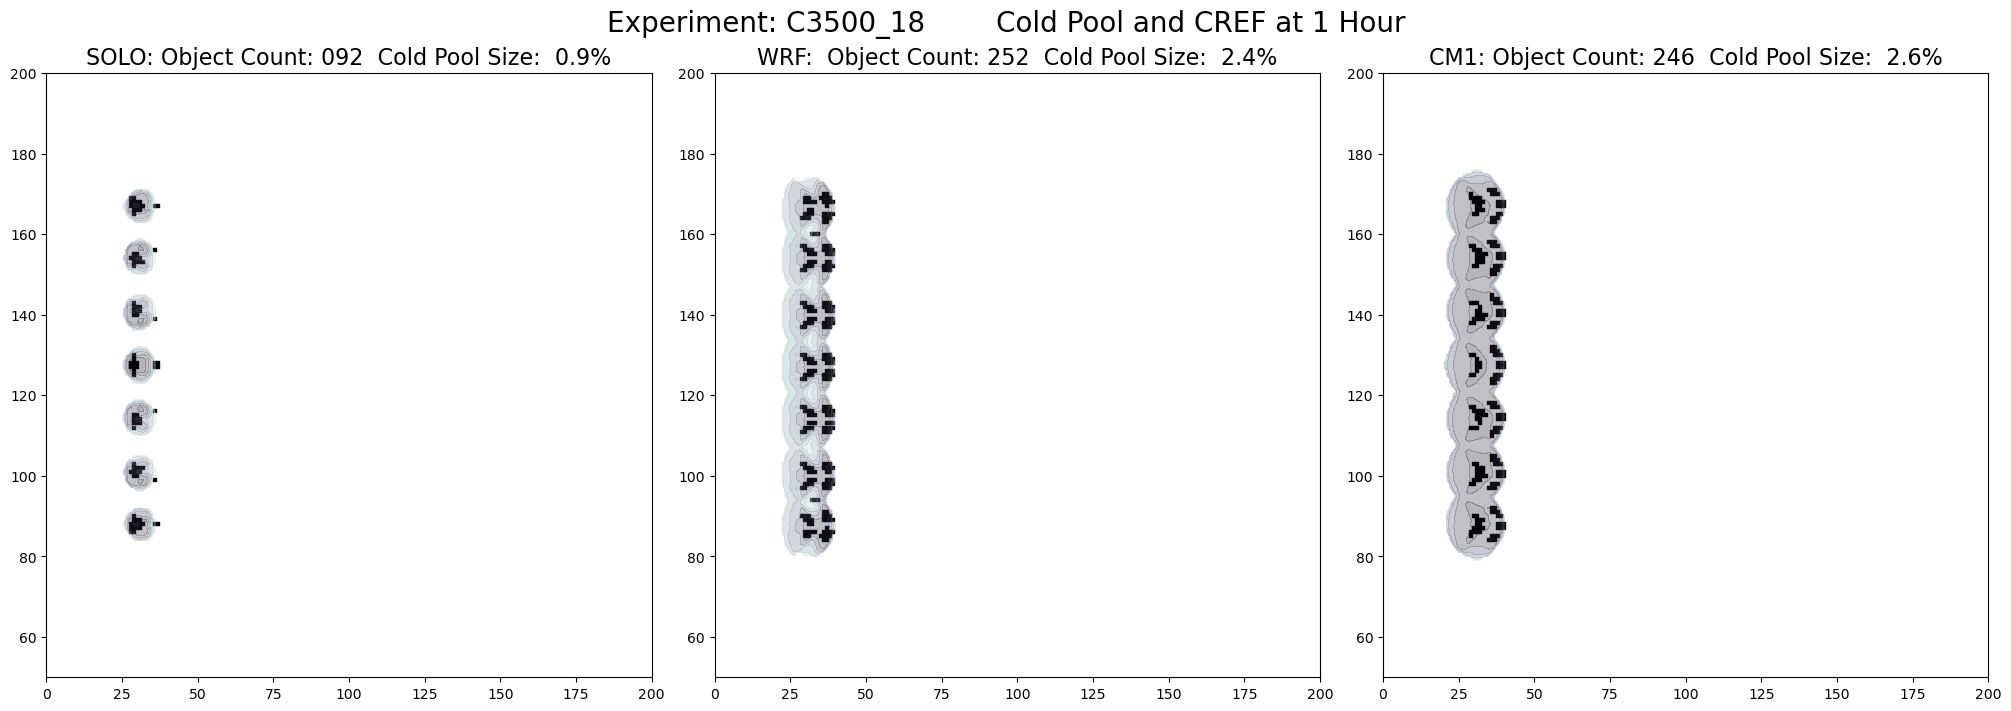

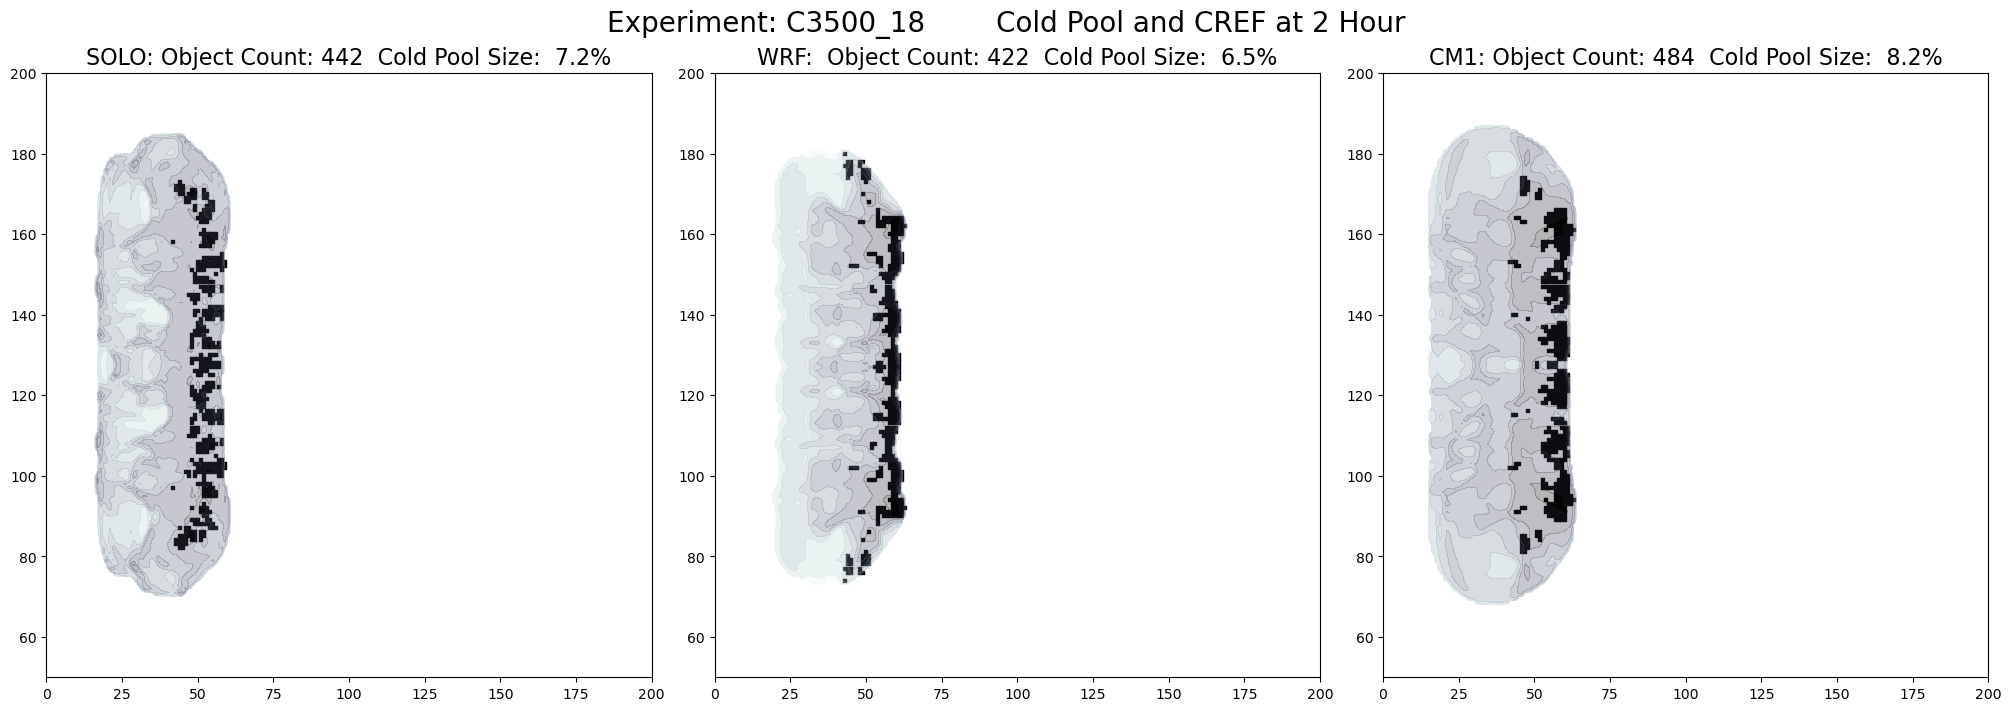

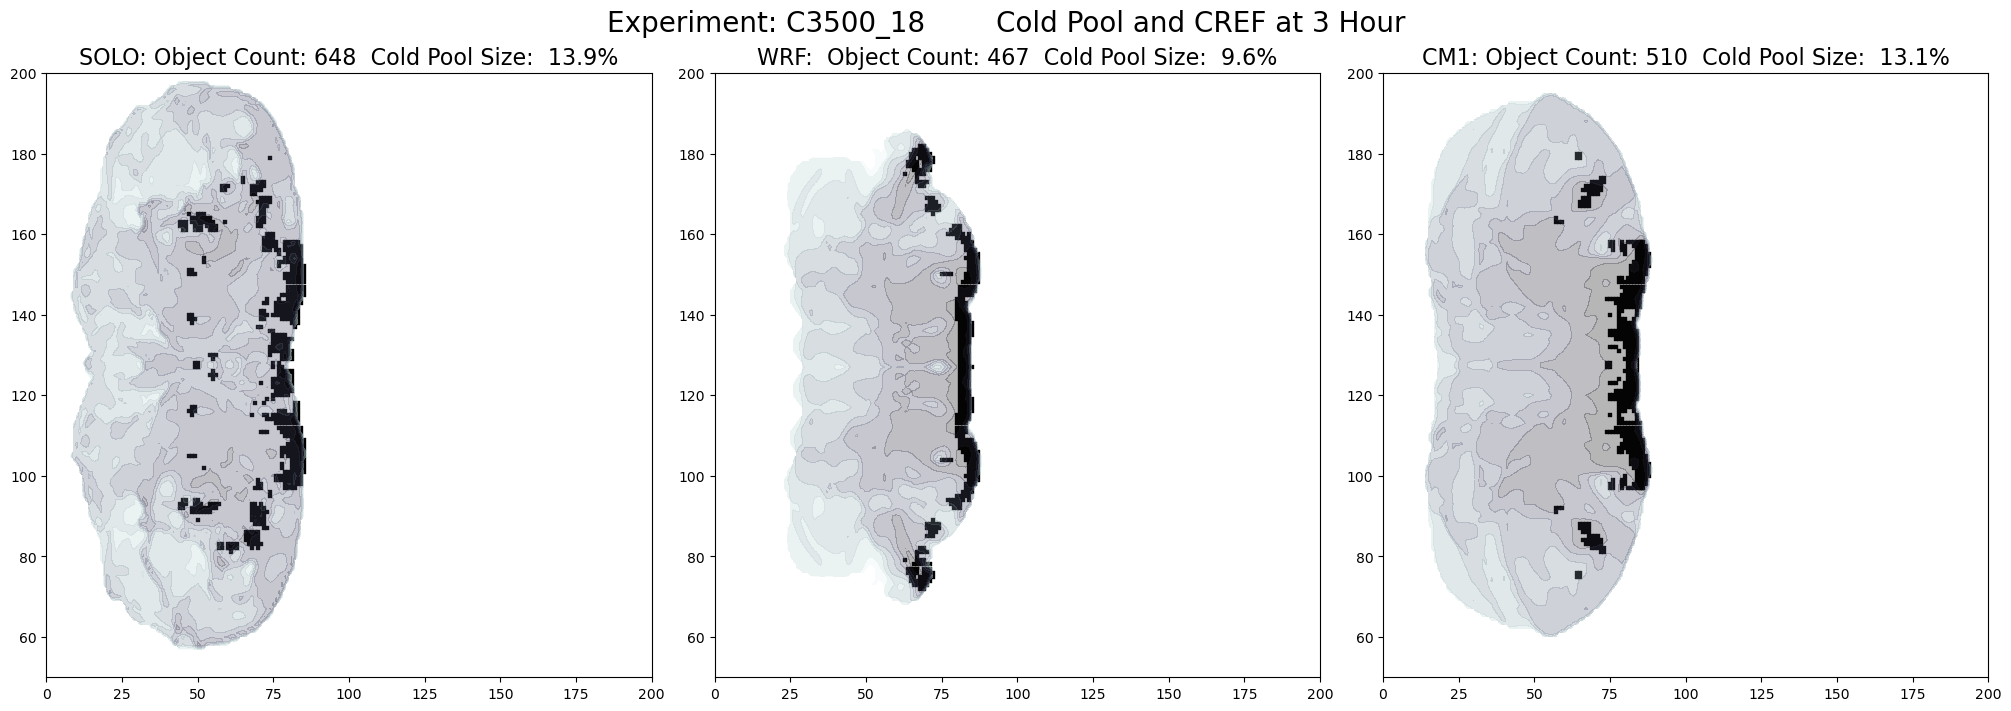

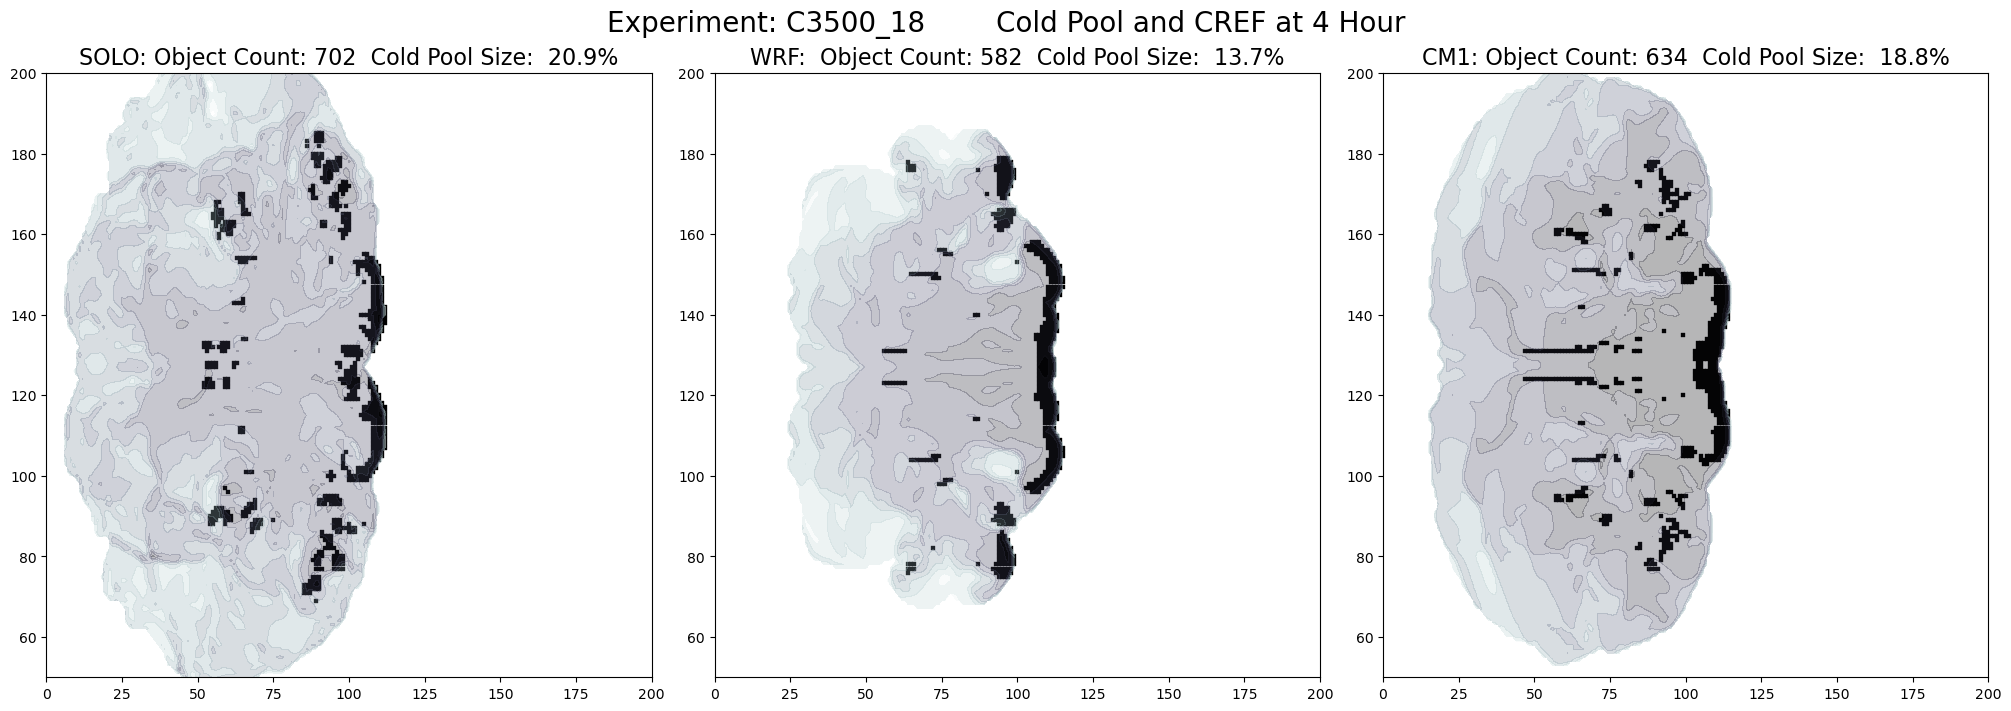

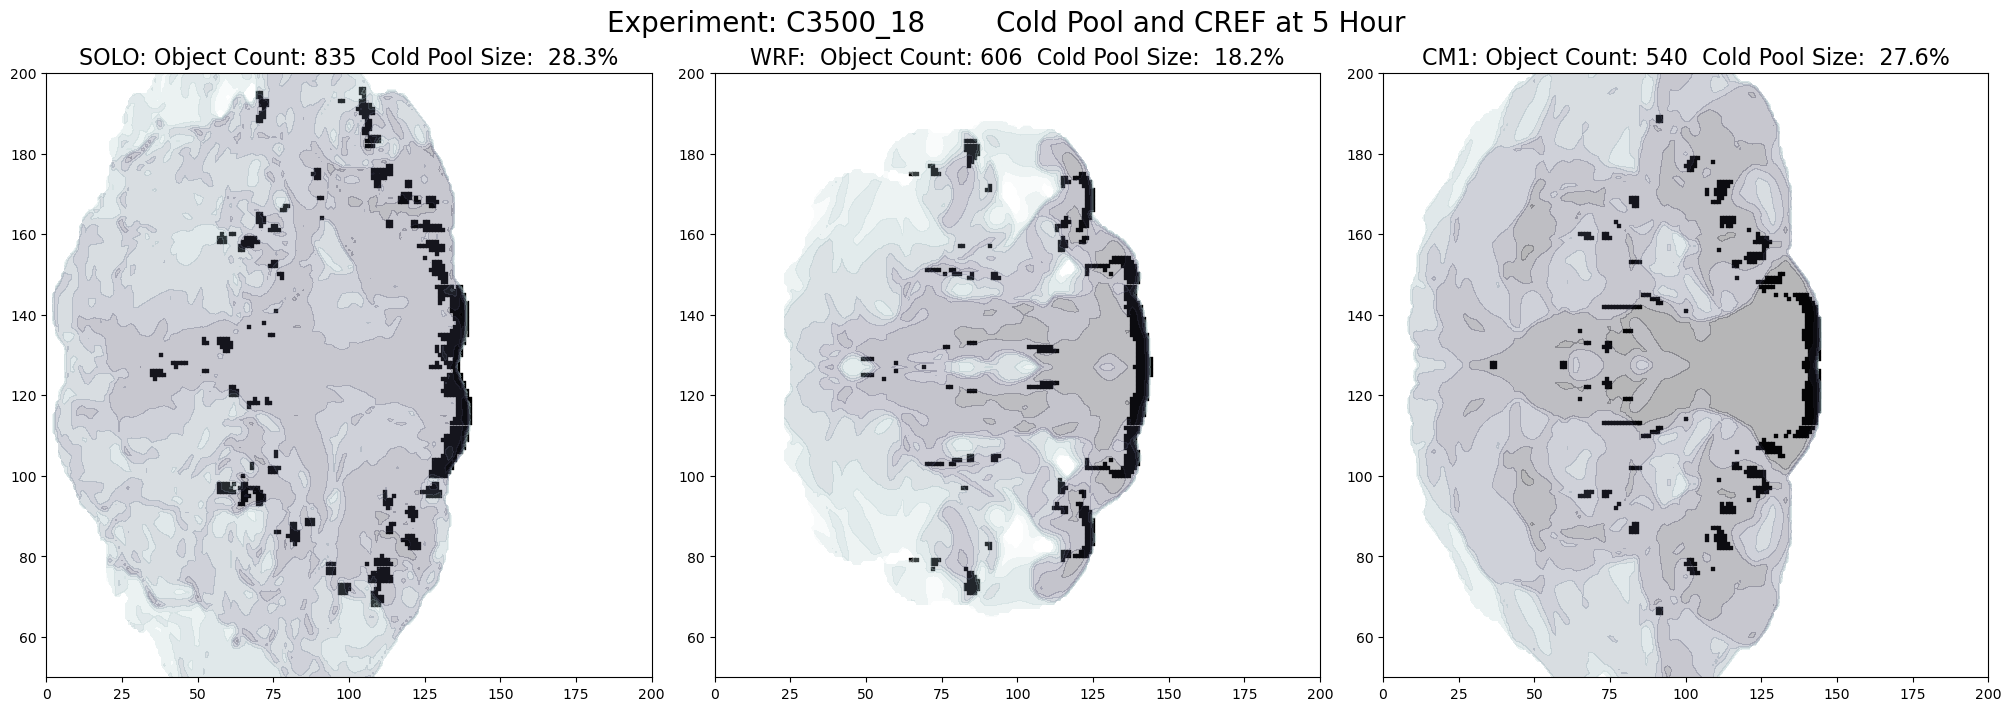

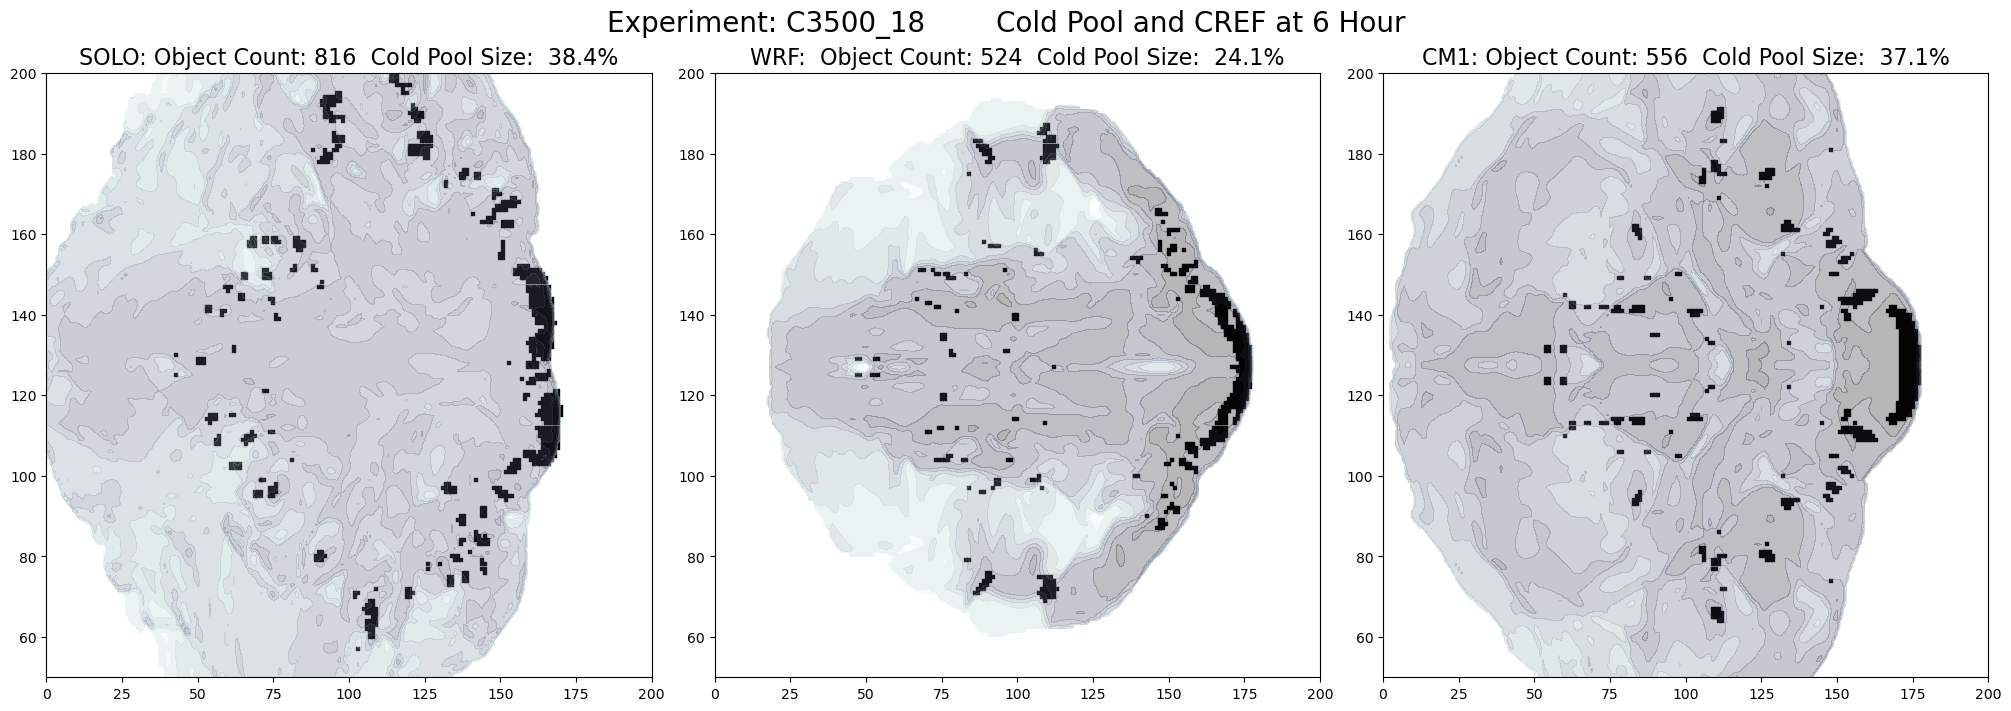

In [ ]:
# Just read stuff back in...
            
def plotobj(data, label, time = 8, ax = None, colors='k', alpha=1.0, cref_thresh = 35., marker="s", w_thresh=5.):
    
    DBZ  = data[label]['dbz'][time]
    W    = data[label]['w'][time]
    PRES = data[label]['pres'][time]
    THpert  = data[label]['pert_th'][time]
        
    mask_cref   = np.where(DBZ.max(axis=0) > cref_thresh, True, False)
    mask_w_3d   = np.where(PRES < 70000.0, W, np.nan)

    mask_w_2d   = np.nanmax(mask_w_3d, axis=0)
    mask_w_cref = (mask_w_2d > w_thresh) & mask_cref
    f_mask      = mask_w_cref.astype(np.int8)
    
    ctable = radar_colormap()
    levels = [5 + 5*n for n in range(15)]
    
    x = np.arange(DBZ.shape[1])
    y = np.arange(DBZ.shape[2])
    xx, yy = np.meshgrid(x,y)
    
    #ax.contour(DBZ.max(axis=0), levels=[35,], color='k')
    ax.scatter(xx[f_mask>0], yy[f_mask>0], s=10, c=colors, marker=marker, alpha=alpha, linewidths=0.25)
    
    #ax.contourf(np.where(THpert[0] < -1.0, THpert[0], np.nan), clevels=[-1,-2], color='b', alpha=0.5)
    ax.contourf(np.where(THpert[0] < -1.0, THpert[0], np.nan), clevels=[-1,], cmap=plt.get_cmap('bone'), alpha=0.3)

    ax.set_ylim(50., 200.)
    ax.set_xlim(0., 200.)
    
    return np.sum(f_mask > 0), 100*np.where(THpert[0] < -1.0, 1.0, 0.0).sum()/(THpert[0].shape[0]*THpert[0].shape[1])

#-----------------------------
allcape = ("C2000","C3500")
allshear = ("06","18")

for shear in allshear:
    for cape in allcape:
        
        for n in [1,2, 3, 4, 5, 6]:
            

            fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,7))

            label = "%s_%s" % (cape, shear)

            o4, pix = plotobj(solo, label, ax = ax[0], time=n*4-1, colors='k', marker="s")

            ax[0].set_title("SOLO: Object Count: %3.3d  Cold Pool Size:  %3.1f%%" % (o4, pix), fontsize=16)

            o4, pix = plotobj(wrf, label, ax = ax[1], time=1+n*4-1, colors='k', marker="s")

            ax[1].set_title("WRF:  Object Count: %3.3d  Cold Pool Size:  %3.1f%%" % (o4, pix), fontsize=16)

            o4, pix = plotobj(cm1, label, ax = ax[2], time=1+n*4-1, colors='k', marker="s")

            ax[2].set_title("CM1: Object Count: %3.3d  Cold Pool Size:  %3.1f%%" % (o4, pix), fontsize=16)

            plt.suptitle("Experiment: %s        Cold Pool and CREF at %d Hour" % (label, n), fontsize=20)
            
            plt.savefig("Experiment_%s_Marker_Hour%d.png" % (label, n))

            plt.show()

In [ ]:
#----------------------------------------------------
def plot_distribution(models, var='dbz', xlim = [0.,70.], thres=0.0, plabel=""):
    
    titles = ["0-6 Hour %s" % var, "0-2 Hour %s" % var, "2-6 Hour %s" %var]

    allcape = ("C2000", "C3500")
    allcape = ("C3500",)
    allshear = ("18",)
    
    step = [[0,-1], [0,8],[8,24]]

    for cape in allcape:

        for shear in allshear:   # create dictionary names
            
            label = "%s_%s" % (cape, shear)
            
            fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))
            
            for key in models:
                
                mdata = models[key]

                for n, s in enumerate(step):
                    
                    data = mdata[label][var][s[0]:s[1]].flatten()
                    data = data[data > thres]

                    ss = np.sort(data)

                    zhgt = np.arange(len(ss))/float(len(ss))

                    if key == 'solo':
                        ax[n].plot(ss, zhgt, color='r', label='FV3-NOR3', linewidth=2.0)
                        
                    if key == 'solo2':
                        ax[n].plot(ss, zhgt, color='g', label='FV3-NOR2', linewidth=2.0, linestyle='--')
                
                    if key == 'solo1':
                        ax[n].plot(ss, zhgt, color='g', label='FV3', linewidth=2.0, linestyle='-')
                        
                    if key == 'cm1':
                        ax[n].plot(ss, zhgt, color='b', label='CM1', linewidth=2.0)
                    
                    if key == 'wrf':
                        ax[n].plot(ss, zhgt, color='k', label='WRF', linewidth=2.0)
                    
                    if key == 'mpas':
                        ax[n].plot(ss, zhgt, color='g', label='MPAS', linewidth=2.0)

                    ax[n].set_title("%s - (%s Distribution)" % (titles[n],var), fontsize=14)
                    ax[n].axhline(y=0.5, color='k', linestyle='--')
                    ax[n].axhline(y=0.9,  color='k', linestyle='--')
                    ax[n].axvline(x=35.,  color='k', linestyle='--')

                    ax[n].set_ylim(0.0,1.1)
                    ax[n].set_xlim(xlim)
                    ax[n].legend(fontsize=14, loc='lower right')
            
            plt.suptitle("%s %s # of Samples %d" % (plabel, label, len(ss)), fontsize=18)
            
            if savePlots:  plt.savefig("Cumulative_Histo_%s_%s.png" % (var.upper(),label))
            


In [ ]:
plot_distribution( models, var='w', thres=5.0, xlim=[5.0, 35.], plabel = 'W' )